# Table of contents
- [pre-check](#pre-check)
- [merge CellChat objects together](#merge-CellChat-objects-together)
- [compare networks between two groups](#compare-networks-between-two-groups)
    - [total clusters](#total-clusters)
    - [signature clusters](#signature-clusters)
        - [boxplot](#boxplot)
        - [statistical significance](#statistical-significance)
        - [circle network plot](#circle-network-plot)
- [representative individual network](#representative-individual-network)
- [identify altered signaling pathways](#identify-altered-signaling-pathways)
    - [conserved and context-specific pathways](#conserved-and-context-specific-pathways)
    - [major senders and receivers](#major-senders-and-receivers)
        - [in specific pathway](#in-specific-pathway)
        - [in all pathways](#in-all-pathways)
    - [hierarchy network plot for specific signaling pathway](#hierarchy-network-plot-for-specific-signaling-pathway)
- [session info](#session-info)

This vignette shows how to apply CellChat to identify major signaling changes across different biological conditions. Firstly, input scRNA-seq data matrix was normalized by TPM (transcripts per million) method and log-transformed with pseudo count of 1. The assigned cell labels were the cell types identified from co-embedding. Ligand-receptor interaction database was CellChatDB v2 excluding non-protein signaling interactions, which finally includes ~2300 validated molecular interactions in the analysis. The default parameters were used following the standard CellChat pipeline. Finally, the intercellular communication networks were obtained for each individual and aggregated together for the downstream visualization.

# pre-check

1. set up your own working directory. 
2. make sure the packages are installed: `CellChat`, `RColorBrewer`, `ggplot2`, `dplyr`, `tibble`, `purrr`, `tidyr`, `data.table`, `pheatmap`
3. After running script `cellchat_analysis.r`, you will have an output folder storing all the cellchat objects. Each sample will have its own cellchat object.
4. make sure the following input files are inside:
    - `meta_kmeans_5.csv`: meta data with Kmeans grouping
    - `mycolors.rds`: color palette for meta data
    - `uni_high_65genes_cv2_high0.5.txt.txt`: curated gene list
    - `cellchat_67_samples.rds`: required if skipping [section 3](#merge-CellChat-objects-together)


In [8]:
# set working dir
maindir <- "/home/jupyter/paper_figures/cellchat"
setwd(maindir)

In [9]:
# import libraries
library(dplyr)
library(ggplot2)
library(CellChat)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [20]:
# set plot parameters, which is suitable for CNS publication
plot.format = theme(
    plot.background=element_blank(),
    panel.grid=element_blank(),
    panel.background=element_blank(),
    panel.border=element_rect(color="black", linewidth=0.5, fill=NA),
    axis.line=element_blank(),
    axis.ticks=element_line(color="black",linewidth=0.5),
    axis.text=element_text(color="black", size=7),
    axis.title=element_text(color="black", size=7),
    plot.title=element_text(color="black", size=7),
    legend.background=element_blank(),
    legend.key=element_blank(),
    legend.text=element_text(color="black", size=7),
    legend.title=element_text(color="black", size=7))

In [148]:
# import data
meta <- read.csv("meta_kmeans_5.csv", row.names = 1) |> mutate(preClust2=ifelse(preClust %in% c("B memory", "B naive", "B intermediate"), "B cell", ifelse(preClust %in% c("CD16 Mono", "CD14 Mono"), "Monocytes", preClust)))
mycolors <- readRDS('mycolors.rds')
genes_of_interest <- readLines('uni_high_65genes_cv2_high0.5.txt')

# merge CellChat objects together

Users need to first run CellChat on each sample separately and then merge together.

In [10]:
# this step takes ~20 min
files <- list.files(path='/home/jupyter/cellchat/',pattern = 'cellchat_obj.rds', full.names = T) # user needs to modify the `path`
object.list <- lapply(files, readRDS)
names(object.list) <- sub('.*/','',sub('_cellchat_obj.rds','',files))
save(object.list, file = "cellchat_object.list_67_samples.RData")

In [17]:
sub('.*/','',sub('_cellchat_obj.rds','',files[1]))

[1] "KT00001"

# compare networks between two groups

We want to answer the following questions:
- Whether the cell-cell communication is enhanced or not
- Which cell types are involved in significantly changed interaction

## total clusters

get total number of interactions and interaction strength per participant

In [21]:
meta_tmp <- meta |> distinct(sample.sampleKitGuid, subject.group2)
df <- data.frame(sample.id=names(object.list), count=unlist(lapply(object.list, function(x) sum(x@net$count))), weight=unlist(lapply(object.list, function(x) sum(x@net$weight)))) |> left_join(meta_tmp, by=c('sample.id'='sample.sampleKitGuid'))
head(df)
dim(df)                                                                                                                                     

,sample.id,count,weight,subject.group2
,<chr>,<dbl>,<dbl>,<chr>
1,KT00001,1599,0.06260832,CON
2,KT00006,7906,0.28217809,CON
3,KT00012,4976,0.12892482,CON
4,KT00015,119,0.01828132,CON
5,KT00023,2408,0.07646867,CON
6,KT00030,1020,0.33281811,CON


[1] 67  4

In [28]:
# summarize across two groups
df2 <- df |> tidyr::pivot_longer(cols = !c('sample.id','subject.group2'), names_to = 'measure', values_to = 'value')
df3 <- df2 |> group_by(subject.group2, measure) |> summarise(mean=mean(value), sd=sd(value))
head(df2)
head(df3)

`summarise()` has grouped output by 'subject.group2'. You can override using
the `.groups` argument.


sample.id,subject.group2,measure,value
<chr>,<chr>,<chr>,<dbl>
KT00001,CON,count,1.599000e+03
KT00001,CON,weight,6.260832e-02
KT00006,CON,count,7.906000e+03
KT00006,CON,weight,2.821781e-01
KT00012,CON,count,4.976000e+03
KT00012,CON,weight,1.289248e-01


subject.group2,measure,mean,sd
<chr>,<chr>,<dbl>,<dbl>
At-Risk/ERA,count,4730.4687500,3084.2526567
At-Risk/ERA,weight,0.3838989,0.3231157
CON,count,4555.5142857,2420.9368553
CON,weight,0.3743161,0.3476976


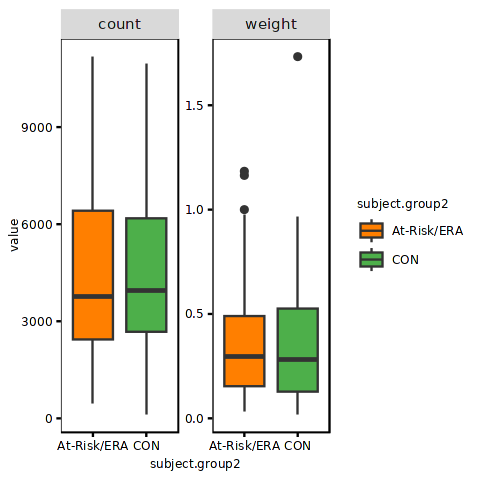

In [30]:
# plot across patients
options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(df2, aes(x=subject.group2, y=value, fill=subject.group2)) + 
    geom_boxplot()+
    facet_wrap(vars(measure), scales = 'free_y') + scale_fill_manual(values = mycolors$subject.group2)+
    plot.format
print(p)

In [ ]:
# save to file
pdf('summary_total_count_and_weight_two_groups.pdf', width = 4, height = 4)
print(p)
dev.off()

## signature clusters

Then we focus on communications within signature groups across all signaling pathways
- input: cellchat object list
- output: ligand-receptor list between signature clusters

In [39]:
prob2 <- data.table::rbindlist(lapply(1:length(object.list), function(i){
    # basic object and meta
    # print(i)
    object <- object.list[[i]]
    obj_name <- names(object.list)[i]
    obj_group <- meta |> filter(sample.sampleKitGuid==obj_name) |> pull(subject.group2) |> unique()
    sig_clusters <- meta |> filter(sample.sampleKitGuid==obj_name & kmeans=='G2') |> pull(cluster) |> unique()

    # some CONs have no signature clusters
    if (!is.null(sig_clusters)){
        obj_meta <- meta |> filter(sample.sampleKitGuid==obj_name) |> distinct(cluster, preClust)
        lrs <- object@net$LRs

        # get prob data
        prob <- data.table::rbindlist(lapply(lrs, function(lr){
            
            # some samples don't have the correponding pathways
            if (!is.na(match(lr,object@net$LRs))){
                # print(lr)
                prob <- object@net$prob[,,lr] 
                prob <- as.data.frame(prob[rowSums(prob)!=0,colSums(prob)!=0, drop=F]) # remove empty rows and columns
                # print(sum(dim(prob)))
                if (nrow(prob)>0){
                    prob <- prob |> tibble::rownames_to_column('source') |> tidyr::pivot_longer(!source,names_to = 'target', values_to = 'prob') |> 
                        filter(source %in% sig_clusters & target %in% sig_clusters) |> mutate(net=lr) # only consider communications between signature clusters
                }else{
                    # print('null')
                    prob <- data.frame(source=NA, target=NA, prob=NA, net=lr)
                }
            }else{
                    # print('null')
                    prob <- data.frame(source=NA, target=NA, prob=NA, net=lr)
                }
            
            return(prob)
        }))
        prob <- prob |> na.omit()
        if (nrow(prob)>0){
            prob <- prob |> left_join(obj_meta, by = c('source'='cluster')) |> left_join(obj_meta, by = c('target'='cluster')) |> 
                mutate(pair=paste0(preClust.x, ' -> ', preClust.y)) |> mutate(sample=obj_name, sample.group=obj_group)
            # print(head(prob))
        }else{
            prob <- data.frame(source=NA, target=NA, prob=NA, net=NA, preClust.x=NA, preClust.y=NA, pair=NA, sample=obj_name, sample.group=obj_group)
        }
        return(prob)
    }

}))

In [40]:
head(prob2)
dim(prob2)

source,target,prob,net,preClust.x,preClust.y,pair,sample,sample.group
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
C7,C7,1.529642e-06,MIF_CD74_CXCR4,CD4 TCM,CD4 TCM,CD4 TCM -> CD4 TCM,KT00001,CON
C7,C6,8.176287e-07,MIF_CD74_CXCR4,CD4 TCM,CD4 TCM,CD4 TCM -> CD4 TCM,KT00001,CON
C7,C14,1.704414e-05,MIF_CD74_CXCR4,CD4 TCM,B naive,CD4 TCM -> B naive,KT00001,CON
C9,C7,1.529642e-06,MIF_CD74_CXCR4,CD8 TEM,CD4 TCM,CD8 TEM -> CD4 TCM,KT00001,CON
C9,C6,8.176287e-07,MIF_CD74_CXCR4,CD8 TEM,CD4 TCM,CD8 TEM -> CD4 TCM,KT00001,CON
C9,C14,1.704414e-05,MIF_CD74_CXCR4,CD8 TEM,B naive,CD8 TEM -> B naive,KT00001,CON


[1] 52540     9

In [41]:
# save to file
saveRDS(prob2, "prob2_67samples_only_G2_clusters_all_lrs.rds")

### boxplot

We use boxplot to show the comparison of the total number of interactions and interaction strength

In [157]:
# load summary of cellular network between signature clusters across all patients
prob2 <- readRDS('prob2_67samples_only_G2_clusters_all_lrs.rds') |> na.omit()

In [43]:
df <- prob2 |> group_by(sample, sample.group) |> summarise(count=n(), weight=sum(prob))|> tidyr::pivot_longer(cols = !c('sample','sample.group'), names_to = 'measure', values_to = 'value')

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


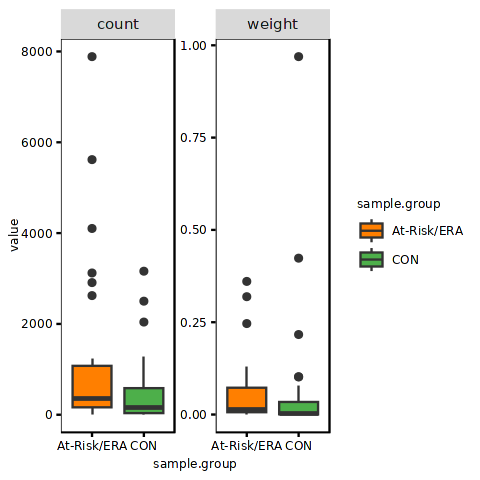

In [45]:
options(repr.plot.width=4, repr.plot.height=4)
p <- ggplot(df, aes(x=sample.group, y=value, fill=sample.group)) + 
    geom_boxplot()+
    facet_wrap(vars(measure), scales = 'free_y') + scale_fill_manual(values = mycolors$subject.group2)+
    plot.format
print(p)

In [ ]:
# save to file
pdf(paste0('summary_total_count_and_weight_two_groups_only_sig_all_pathways.pdf'), width = 6, height = 4)
print(p)
dev.off()

### statistical significance

We used Wilcoxon rank sum test to calculate the significance of the group difference.

In [48]:
# calculate p-value
l1 <- df |> filter(sample.group=='CON' & measure=='count') |> pull(value)
l2 <- df |> filter(sample.group=='At-Risk/ERA' & measure=='count') |> pull(value)
l3 <- df |> filter(sample.group=='CON' & measure=='weight') |> pull(value)
l4 <- df |> filter(sample.group=='At-Risk/ERA' & measure=='weight') |> pull(value)

wilcox.test(l2,l1, alternative = 'greater')
wilcox.test(l4,l3, alternative = 'greater')


Warning message in wilcox.test.default(l2, l1, alternative = "greater"):
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  l2 and l1
W = 672.5, p-value = 0.01584
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum exact test

data:  l4 and l3
W = 662, p-value = 0.02209
alternative hypothesis: true location shift is greater than 0


### circle network plot

To simplify the complicated network and gain insights at the group-level, we aggregated the cell-cell communication based on disease states of the samples and defined cell groups.
- input: cellchat object list
- output: updated cellchat object with new slots `count.merged.sig` and `weight.merged.sig`

First, we aggregated across defined cell groups `group.levels2`

In [57]:
group.levels = c('B cell','Monocytes',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","NK") # exclude Treg and MAIT
group.levels2 = do.call(c,lapply(group.levels, function(x) c(paste0('Sig-',x), paste0('noSig-',x))))
print(group.levels2)

 [1] "Sig-B cell"      "noSig-B cell"    "Sig-Monocytes"   "noSig-Monocytes"
 [5] "Sig-CD4 Naive"   "noSig-CD4 Naive" "Sig-CD8 Naive"   "noSig-CD8 Naive"
 [9] "Sig-CD4 TCM"     "noSig-CD4 TCM"   "Sig-CD8 TEM"     "noSig-CD8 TEM"  
[13] "Sig-NK"          "noSig-NK"       


In [89]:
object.list2 <- lapply(names(object.list), function(s){
    print(s)
    tmp = object.list[[s]]
    new_meta = meta |> filter(sample.sampleKitGuid==s & cluster %in% levels(tmp@idents)) |> dplyr::select(cluster, preClust2, kmeans) |> 
        arrange(factor(cluster, levels=levels(tmp@idents))) |>  mutate(new=ifelse(kmeans=='G2',paste0(cluster,'-Sig-',preClust2), paste0(cluster,'-noSig-',preClust2)))
    new_name = new_meta |> pull(new)
    new_order = new_meta |> arrange(preClust2) |> pull(new)
    tmp = updateClusterLabels(tmp, new.cluster.name = new_name, new.order = new_order)

    group.celltype = meta |> filter(sample.sampleKitGuid==s & preClust2 %in% group.levels) |> dplyr::select(cluster, preClust2, kmeans) |> 
        mutate(new=ifelse(kmeans=='G2',paste0('Sig-',preClust2), paste0('noSig-',preClust2)))|> arrange(factor(new, levels=levels(tmp@idents))) |> pull(new)
    group.celltype = factor(group.celltype, levels=group.levels2)
    
    # merge interactions
    tmp = mergeInteractions(tmp, group.celltype)
    
    # add another slot only within signature clusters
    obj = tmp@net$count.merged
    tmp@net$count.merged.sig=obj[!grepl('noSig',rownames(obj)),!grepl('noSig',colnames(obj))]
    obj = tmp@net$weight.merged
    tmp@net$weight.merged.sig=obj[!grepl('noSig',rownames(obj)),!grepl('noSig',colnames(obj))]
    
    return(tmp)
    
}) 
names(object.list2) <- names(object.list)
print(object.list2)

[1] "KT00001"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C1 C3 C8 C5 C2 C11 C10 C7 C9 C6 C14 
The cell group order after renaming is  C4-noSig-MAIT C1-noSig-Monocytes C3-noSig-B cell C8-noSig-CD8 TEM C5-noSig-Monocytes C2-noSig-NK C11-noSig-Monocytes C10-noSig-B cell C7-Sig-CD4 TCM C9-Sig-CD8 TEM C6-Sig-CD4 TCM C14-Sig-B cell 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-MAIT C1-noSig-Monocytes C3-noSig-B cell C8-noSig-CD8 TEM C5-noSig-Monocytes C2-noSig-NK C11-noSig-Monocytes C10-noSig-B cell C7-Sig-CD4 TCM C9-Sig-CD8 TEM C6-Sig-CD4 TCM C14-Sig-B cell 
The cell group order after reordering is  C3-noSig-B cell C10-noSig-B cell C14-Sig-B cell C7-Sig-CD4 TCM C6-Sig-CD4 TCM C8-noSig-CD8 TEM C9-Sig-CD8 TEM C4-noSig-MAIT C1-noSig-Monocytes C5-noSig-Monocytes C11-noSig-Monocytes C2-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00006"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C18 C1 C28 C20 C8 C10 C2 C12 C4 C16 C5 C6 C3 C23 C9 C19 C13 C14 C17 C21 C7 C11 C22 C15 C25 
The cell group order after renaming is  C18-noSig-Monocytes C1-noSig-CD8 TEM C28-noSig-cDC2 C20-noSig-Monocytes C8-noSig-CD8 Naive C10-noSig-CD4 TCM C2-noSig-Monocytes C12-noSig-Monocytes C4-noSig-CD8 Naive C16-noSig-Monocytes C5-noSig-CD8 Naive C6-noSig-CD8 Naive C3-noSig-B cell C23-Sig-NK C9-noSig-CD8 Naive C19-noSig-Monocytes C13-noSig-Monocytes C14-noSig-Monocytes C17-noSig-Monocytes C21-noSig-CD8 Naive C7-noSig-CD8 Naive C11-noSig-CD4 TCM C22-noSig-CD8 Naive C15-noSig-Monocytes C25-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C18-noSig-Monocytes C1-noSig-CD8 TEM C28-noSig-cDC2 C20-noSig-Monocytes C8-noSig-CD8 Naive C10-noSig-CD4 TCM C2-noSig-Monocytes C12-noSig-Monocytes C4-noSig-CD8 Naive C16-noSig-Monocytes C5-noSig-CD8 Naive C6-noSig-CD8 Naive C3-noSig-B cell C23-Sig-NK C9-noSig-CD8 Naive C19-noSig-Monocytes C13-noSig-Monocytes C14-noSig-Monocytes C17-noSig-Monocytes C21-noSig-CD8 Naive C7-noSig-CD8 Naive C11-noSig-CD4 TCM C22-noSig-CD8 Naive C15-noSig-Monocytes C25-Sig-NK 
The cell group order after reordering is  C3-noSig-B cell C10-noSig-CD4 TCM C11-noSig-CD4 TCM C8-noSig-CD8 Naive C4-noSig-CD8 Naive C5-noSig-CD8 Naive C6-noSig-CD8 Naive C9-noSig-CD8 Naive C21-noSig-CD8 Naive C7-noSig-CD8 Naive C22-noSig-CD8 Naive C1-noSig-CD8 TEM C18-noSig-Monocytes C20-noSig-Monocytes C2-noSig-Monocytes C12-noSig-Monocytes C16-noSig-Monocytes C19-noSig-Monocytes C13-noSig-Monocytes C14-noSig-Monocytes C17-noSig-Monocytes C15-noSig-Monocytes C23-Sig-NK C25-Sig-NK C28-noSig-c

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00012"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C1 C9 C5 C2 C8 C6 C16 C13 C4 C12 C18 C7 C21 C14 C17 C11 C24 C22 C19 C10 C15 C20 
The cell group order after renaming is  C3-noSig-Monocytes C1-noSig-CD8 TEM C9-noSig-CD4 TCM C5-noSig-CD4 TCM C2-noSig-B cell C8-noSig-NK C6-noSig-CD4 TCM C16-noSig-Monocytes C13-noSig-CD4 TCM C4-noSig-CD4 TCM C12-noSig-CD4 TCM C18-Sig-CD4 Naive C7-noSig-CD4 TCM C21-noSig-Monocytes C14-noSig-CD4 TCM C17-noSig-B cell C11-noSig-CD8 TEM C24-Sig-CD8 TEM C22-Sig-CD8 TEM C19-noSig-CD4 Proliferating C10-noSig-CD4 TCM C15-noSig-Monocytes C20-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-Monocytes C1-noSig-CD8 TEM C9-noSig-CD4 TCM C5-noSig-CD4 TCM C2-noSig-B cell C8-noSig-NK C6-noSig-CD4 TCM C16-noSig-Monocytes C13-noSig-CD4 TCM C4-noSig-CD4 TCM C12-noSig-CD4 TCM C18-Sig-CD4 Naive C7-noSig-CD4 TCM C21-noSig-Monocytes C14-noSig-CD4 TCM C17-noSig-B cell C11-noSig-CD8 TEM C24-Sig-CD8 TEM C22-Sig-CD8 TEM C19-noSig-CD4 Proliferating C10-noSig-CD4 TCM C15-noSig-Monocytes C20-Sig-CD4 Naive 
The cell group order after reordering is  C2-noSig-B cell C17-noSig-B cell C18-Sig-CD4 Naive C20-Sig-CD4 Naive C19-noSig-CD4 Proliferating C9-noSig-CD4 TCM C5-noSig-CD4 TCM C6-noSig-CD4 TCM C13-noSig-CD4 TCM C4-noSig-CD4 TCM C12-noSig-CD4 TCM C7-noSig-CD4 TCM C14-noSig-CD4 TCM C10-noSig-CD4 TCM C1-noSig-CD8 TEM C11-noSig-CD8 TEM C24-Sig-CD8 TEM C22-Sig-CD8 TEM C3-noSig-Monocytes C16-noSig-Monocytes C21-noSig-Monocytes C15-noSig-Monocytes C8-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00015"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C10 C7 C5 C6 C4 
The cell group order after renaming is  C10-noSig-Monocytes C7-Sig-CD4 TCM C5-noSig-CD4 TCM C6-Sig-CD4 TCM C4-noSig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C10-noSig-Monocytes C7-Sig-CD4 TCM C5-noSig-CD4 TCM C6-Sig-CD4 TCM C4-noSig-CD4 TCM 
The cell group order after reordering is  C7-Sig-CD4 TCM C5-noSig-CD4 TCM C6-Sig-CD4 TCM C4-noSig-CD4 TCM C10-noSig-Monocytes 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00023"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C4 C2 C3 C16 C6 C21 C5 C10 C17 C14 C7 C11 C13 C12 C22 C19 C8 C15 C24 C20 
The cell group order after renaming is  C1-noSig-Monocytes C4-noSig-B cell C2-noSig-CD8 TEM C3-noSig-NK C16-noSig-CD4 Naive C6-noSig-B cell C21-Sig-CD4 Naive C5-noSig-MAIT C10-Sig-CD4 TCM C17-Sig-CD4 Naive C14-noSig-CD4 Naive C7-noSig-CD4 TCM C11-noSig-CD4 Naive C13-Sig-CD4 Naive C12-Sig-CD4 TCM C22-Sig-CD4 Naive C19-Sig-CD4 Naive C8-noSig-Monocytes C15-Sig-CD4 Naive C24-Sig-CD4 Naive C20-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C4-noSig-B cell C2-noSig-CD8 TEM C3-noSig-NK C16-noSig-CD4 Naive C6-noSig-B cell C21-Sig-CD4 Naive C5-noSig-MAIT C10-Sig-CD4 TCM C17-Sig-CD4 Naive C14-noSig-CD4 Naive C7-noSig-CD4 TCM C11-noSig-CD4 Naive C13-Sig-CD4 Naive C12-Sig-CD4 TCM C22-Sig-CD4 Naive C19-Sig-CD4 Naive C8-noSig-Monocytes C15-Sig-CD4 Naive C24-Sig-CD4 Naive C20-Sig-CD4 TCM 
The cell group order after reordering is  C4-noSig-B cell C6-noSig-B cell C16-noSig-CD4 Naive C21-Sig-CD4 Naive C17-Sig-CD4 Naive C14-noSig-CD4 Naive C11-noSig-CD4 Naive C13-Sig-CD4 Naive C22-Sig-CD4 Naive C19-Sig-CD4 Naive C15-Sig-CD4 Naive C24-Sig-CD4 Naive C10-Sig-CD4 TCM C7-noSig-CD4 TCM C12-Sig-CD4 TCM C20-Sig-CD4 TCM C2-noSig-CD8 TEM C5-noSig-MAIT C1-noSig-Monocytes C8-noSig-Monocytes C3-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00030"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C2 C12 C10 C3 C19 C7 C8 C18 C15 C5 
The cell group order after renaming is  C6-noSig-CD8 TEM C2-noSig-NK C12-Sig-CD4 Naive C10-noSig-MAIT C3-noSig-CD4 TCM C19-noSig-CD4 Naive C7-Sig-CD4 Naive C8-Sig-CD4 Naive C18-Sig-NK C15-noSig-B cell C5-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-CD8 TEM C2-noSig-NK C12-Sig-CD4 Naive C10-noSig-MAIT C3-noSig-CD4 TCM C19-noSig-CD4 Naive C7-Sig-CD4 Naive C8-Sig-CD4 Naive C18-Sig-NK C15-noSig-B cell C5-noSig-Monocytes 
The cell group order after reordering is  C15-noSig-B cell C12-Sig-CD4 Naive C19-noSig-CD4 Naive C7-Sig-CD4 Naive C8-Sig-CD4 Naive C3-noSig-CD4 TCM C6-noSig-CD8 TEM C10-noSig-MAIT C5-noSig-Monocytes C2-noSig-NK C18-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00052"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C4 C14 C1 C5 C11 C2 C9 C10 C8 C7 C15 C17 C12 C16 
The cell group order after renaming is  C6-noSig-B cell C4-noSig-B cell C14-noSig-CD4 Naive C1-noSig-NK C5-noSig-CD8 TEM C11-Sig-CD4 Naive C2-noSig-CD4 TCM C9-Sig-CD4 Naive C10-noSig-CD4 Naive C8-Sig-CD4 Naive C7-Sig-CD4 Naive C15-Sig-NK C17-Sig-CD4 Naive C12-noSig-Monocytes C16-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-B cell C4-noSig-B cell C14-noSig-CD4 Naive C1-noSig-NK C5-noSig-CD8 TEM C11-Sig-CD4 Naive C2-noSig-CD4 TCM C9-Sig-CD4 Naive C10-noSig-CD4 Naive C8-Sig-CD4 Naive C7-Sig-CD4 Naive C15-Sig-NK C17-Sig-CD4 Naive C12-noSig-Monocytes C16-Sig-CD4 Naive 
The cell group order after reordering is  C6-noSig-B cell C4-noSig-B cell C14-noSig-CD4 Naive C11-Sig-CD4 Naive C9-Sig-CD4 Naive C10-noSig-CD4 Naive C8-Sig-CD4 Naive C7-Sig-CD4 Naive C17-Sig-CD4 Naive C16-Sig-CD4 Naive C2-noSig-CD4 TCM C5-noSig-CD8 TEM C12-noSig-Monocytes C1-noSig-NK C15-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00055"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C4 C6 C1 C2 C5 C11 C27 C9 C17 C8 C13 C18 C14 C15 C7 C16 C10 C19 C23 C21 C20 C12 C22 C24 
The cell group order after renaming is  C3-noSig-B cell C4-noSig-NK C6-noSig-CD4 TCM C1-noSig-Monocytes C2-noSig-CD8 TEM C5-noSig-CD4 TCM C11-noSig-CD4 TCM C27-noSig-pDC C9-noSig-CD4 TCM C17-noSig-CD8 TEM C8-noSig-CD4 TCM C13-noSig-CD4 TCM C18-noSig-CD8 TEM C14-noSig-B cell C15-noSig-Monocytes C7-noSig-CD4 TCM C16-noSig-Monocytes C10-noSig-CD4 TCM C19-Sig-CD8 TEM C23-Sig-CD8 TEM C21-Sig-CD8 TEM C20-Sig-CD8 TEM C12-noSig-CD4 TCM C22-Sig-CD8 TEM C24-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-B cell C4-noSig-NK C6-noSig-CD4 TCM C1-noSig-Monocytes C2-noSig-CD8 TEM C5-noSig-CD4 TCM C11-noSig-CD4 TCM C27-noSig-pDC C9-noSig-CD4 TCM C17-noSig-CD8 TEM C8-noSig-CD4 TCM C13-noSig-CD4 TCM C18-noSig-CD8 TEM C14-noSig-B cell C15-noSig-Monocytes C7-noSig-CD4 TCM C16-noSig-Monocytes C10-noSig-CD4 TCM C19-Sig-CD8 TEM C23-Sig-CD8 TEM C21-Sig-CD8 TEM C20-Sig-CD8 TEM C12-noSig-CD4 TCM C22-Sig-CD8 TEM C24-Sig-CD8 TEM 
The cell group order after reordering is  C3-noSig-B cell C14-noSig-B cell C6-noSig-CD4 TCM C5-noSig-CD4 TCM C11-noSig-CD4 TCM C9-noSig-CD4 TCM C8-noSig-CD4 TCM C13-noSig-CD4 TCM C7-noSig-CD4 TCM C10-noSig-CD4 TCM C12-noSig-CD4 TCM C2-noSig-CD8 TEM C17-noSig-CD8 TEM C18-noSig-CD8 TEM C19-Sig-CD8 TEM C23-Sig-CD8 TEM C21-Sig-CD8 TEM C20-Sig-CD8 TEM C22-Sig-CD8 TEM C24-Sig-CD8 TEM C1-noSig-Monocytes C15-noSig-Monocytes C16-noSig-Monocytes C4-noSig-NK C27-noSig-pDC 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00056"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C1 C8 C3 C23 C10 C11 C4 C22 C7 C12 C29 C24 C9 C20 C16 C5 C6 C18 C14 C17 C13 C19 C15 C35 C37 C26 C21 C25 C28 C32 C33 
The cell group order after renaming is  C2-noSig-B cell C1-noSig-Monocytes C8-noSig-CD4 TCM C3-noSig-CD8 TEM C23-noSig-Monocytes C10-noSig-CD4 Naive C11-noSig-CD4 Naive C4-noSig-NK C22-Sig-CD4 Naive C7-noSig-Monocytes C12-Sig-CD4 Naive C29-noSig-cDC2 C24-Sig-CD8 TEM C9-noSig-CD4 Naive C20-Sig-CD4 Naive C16-Sig-CD4 Naive C5-noSig-B cell C6-noSig-CD4 Naive C18-Sig-CD4 Naive C14-Sig-CD4 Naive C17-Sig-CD4 Naive C13-noSig-CD4 Naive C19-Sig-CD4 Naive C15-noSig-CD4 Naive C35-noSig-pDC C37-Sig-CD8 TEM C26-Sig-NK C21-Sig-CD4 Naive C25-Sig-NK C28-Sig-HSPC C32-Sig-NK C33-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C2-noSig-B cell C1-noSig-Monocytes C8-noSig-CD4 TCM C3-noSig-CD8 TEM C23-noSig-Monocytes C10-noSig-CD4 Naive C11-noSig-CD4 Naive C4-noSig-NK C22-Sig-CD4 Naive C7-noSig-Monocytes C12-Sig-CD4 Naive C29-noSig-cDC2 C24-Sig-CD8 TEM C9-noSig-CD4 Naive C20-Sig-CD4 Naive C16-Sig-CD4 Naive C5-noSig-B cell C6-noSig-CD4 Naive C18-Sig-CD4 Naive C14-Sig-CD4 Naive C17-Sig-CD4 Naive C13-noSig-CD4 Naive C19-Sig-CD4 Naive C15-noSig-CD4 Naive C35-noSig-pDC C37-Sig-CD8 TEM C26-Sig-NK C21-Sig-CD4 Naive C25-Sig-NK C28-Sig-HSPC C32-Sig-NK C33-Sig-NK 
The cell group order after reordering is  C2-noSig-B cell C5-noSig-B cell C10-noSig-CD4 Naive C11-noSig-CD4 Naive C22-Sig-CD4 Naive C12-Sig-CD4 Naive C9-noSig-CD4 Naive C20-Sig-CD4 Naive C16-Sig-CD4 Naive C6-noSig-CD4 Naive C18-Sig-CD4 Naive C14-Sig-CD4 Naive C17-Sig-CD4 Naive C13-noSig-CD4 Naive C19-Sig-CD4 Naive C15-noSig-CD4 Naive C21-Sig-CD4 Naive C8-noSig-CD4 TCM C3-noSig-CD8 TEM C24-Sig-CD8 TEM C37-Sig-CD8 TEM C2

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00057"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C8 C4 C3 C10 C7 C27 C2 C28 C20 C33 C29 C9 C22 C12 C25 C6 C38 C5 C11 C26 C23 C19 C32 C18 C31 C13 C30 C16 C17 C14 C34 C21 C15 
The cell group order after renaming is  C1-noSig-Monocytes C8-noSig-Monocytes C4-noSig-MAIT C3-noSig-NK C10-noSig-CD4 TCM C7-Sig-CD4 TCM C27-Sig-NK C2-noSig-B cell C28-Sig-NK C20-Sig-NK C33-Sig-NK C29-Sig-NK C9-noSig-CD4 TCM C22-Sig-CD4 TCM C12-Sig-CD4 TCM C25-Sig-NK C6-noSig-cDC2 C38-noSig-pDC C5-Sig-CD4 TCM C11-noSig-CD4 TCM C26-noSig-NK C23-Sig-CD4 TCM C19-Sig-CD4 TCM C32-Sig-NK C18-Sig-CD4 TCM C31-Sig-NK C13-Sig-CD4 TCM C30-Sig-NK C16-Sig-CD4 TCM C17-noSig-CD4 TCM C14-Sig-CD4 TCM C34-Sig-NK C21-Sig-CD4 TCM C15-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C8-noSig-Monocytes C4-noSig-MAIT C3-noSig-NK C10-noSig-CD4 TCM C7-Sig-CD4 TCM C27-Sig-NK C2-noSig-B cell C28-Sig-NK C20-Sig-NK C33-Sig-NK C29-Sig-NK C9-noSig-CD4 TCM C22-Sig-CD4 TCM C12-Sig-CD4 TCM C25-Sig-NK C6-noSig-cDC2 C38-noSig-pDC C5-Sig-CD4 TCM C11-noSig-CD4 TCM C26-noSig-NK C23-Sig-CD4 TCM C19-Sig-CD4 TCM C32-Sig-NK C18-Sig-CD4 TCM C31-Sig-NK C13-Sig-CD4 TCM C30-Sig-NK C16-Sig-CD4 TCM C17-noSig-CD4 TCM C14-Sig-CD4 TCM C34-Sig-NK C21-Sig-CD4 TCM C15-Sig-CD4 TCM 
The cell group order after reordering is  C2-noSig-B cell C10-noSig-CD4 TCM C7-Sig-CD4 TCM C9-noSig-CD4 TCM C22-Sig-CD4 TCM C12-Sig-CD4 TCM C5-Sig-CD4 TCM C11-noSig-CD4 TCM C23-Sig-CD4 TCM C19-Sig-CD4 TCM C18-Sig-CD4 TCM C13-Sig-CD4 TCM C16-Sig-CD4 TCM C17-noSig-CD4 TCM C14-Sig-CD4 TCM C21-Sig-CD4 TCM C15-Sig-CD4 TCM C4-noSig-MAIT C1-noSig-Monocytes C8-noSig-Monocytes C3-noSig-NK C27-Sig-NK C28-Sig-NK C20-Sig-NK C33-Sig-NK C29-Sig-NK C25-Sig-NK C26-noSig-NK C3

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00058"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C5 C6 C7 C3 C12 C16 C34 C13 C18 C15 C8 C11 
The cell group order after renaming is  C1-noSig-Monocytes C5-noSig-B cell C6-noSig-Monocytes C7-noSig-cDC2 C3-noSig-Monocytes C12-Sig-CD4 TCM C16-noSig-Monocytes C34-noSig-pDC C13-Sig-CD4 Naive C18-Sig-Monocytes C15-Sig-CD4 Naive C8-Sig-CD4 Naive C11-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C5-noSig-B cell C6-noSig-Monocytes C7-noSig-cDC2 C3-noSig-Monocytes C12-Sig-CD4 TCM C16-noSig-Monocytes C34-noSig-pDC C13-Sig-CD4 Naive C18-Sig-Monocytes C15-Sig-CD4 Naive C8-Sig-CD4 Naive C11-Sig-CD4 Naive 
The cell group order after reordering is  C5-noSig-B cell C13-Sig-CD4 Naive C15-Sig-CD4 Naive C8-Sig-CD4 Naive C11-Sig-CD4 Naive C12-Sig-CD4 TCM C1-noSig-Monocytes C6-noSig-Monocytes C3-noSig-Monocytes C16-noSig-Monocytes C18-Sig-Monocytes C7-noSig-cDC2 C34-noSig-pDC 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00060"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C15 C1 C14 C3 C11 C6 C13 C10 C12 C26 C5 C9 C7 C16 C8 C18 C19 C17 
The cell group order after renaming is  C2-noSig-Monocytes C15-noSig-Monocytes C1-noSig-NK C14-noSig-Monocytes C3-noSig-B cell C11-noSig-CD4 TCM C6-noSig-CD4 Naive C13-Sig-CD4 Naive C10-Sig-CD4 Naive C12-Sig-CD4 Naive C26-noSig-pDC C5-noSig-CD4 Naive C9-Sig-CD4 Naive C7-Sig-CD4 Naive C16-Sig-NK C8-Sig-CD4 Naive C18-Sig-CD4 TCM C19-Sig-NK C17-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C2-noSig-Monocytes C15-noSig-Monocytes C1-noSig-NK C14-noSig-Monocytes C3-noSig-B cell C11-noSig-CD4 TCM C6-noSig-CD4 Naive C13-Sig-CD4 Naive C10-Sig-CD4 Naive C12-Sig-CD4 Naive C26-noSig-pDC C5-noSig-CD4 Naive C9-Sig-CD4 Naive C7-Sig-CD4 Naive C16-Sig-NK C8-Sig-CD4 Naive C18-Sig-CD4 TCM C19-Sig-NK C17-noSig-Monocytes 
The cell group order after reordering is  C3-noSig-B cell C6-noSig-CD4 Naive C13-Sig-CD4 Naive C10-Sig-CD4 Naive C12-Sig-CD4 Naive C5-noSig-CD4 Naive C9-Sig-CD4 Naive C7-Sig-CD4 Naive C8-Sig-CD4 Naive C11-noSig-CD4 TCM C18-Sig-CD4 TCM C2-noSig-Monocytes C15-noSig-Monocytes C14-noSig-Monocytes C17-noSig-Monocytes C1-noSig-NK C16-Sig-NK C19-Sig-NK C26-noSig-pDC 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00064"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C0 C4 C2 C29 C5 C27 C24 C10 C8 C16 C14 C11 C21 C15 C17 C12 C7 C20 C9 C6 C33 C13 C26 C30 C32 
The cell group order after renaming is  C3-noSig-NK C0-noSig-Monocytes C4-noSig-Monocytes C2-noSig-CD8 TEM C29-noSig-cDC2 C5-noSig-B cell C27-noSig-NK C24-Sig-CD8 TEM C10-noSig-CD4 TCM C8-noSig-CD4 TCM C16-noSig-CD4 TCM C14-noSig-CD4 TCM C11-noSig-CD4 TCM C21-Sig-CD4 Naive C15-noSig-CD4 TCM C17-noSig-NK C12-noSig-CD4 TCM C7-noSig-B cell C20-Sig-CD4 Naive C9-noSig-CD4 TCM C6-noSig-NK C33-Sig-HSPC C13-noSig-CD4 TCM C26-Sig-CD4 Naive C30-Sig-CD4 Naive C32-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-NK C0-noSig-Monocytes C4-noSig-Monocytes C2-noSig-CD8 TEM C29-noSig-cDC2 C5-noSig-B cell C27-noSig-NK C24-Sig-CD8 TEM C10-noSig-CD4 TCM C8-noSig-CD4 TCM C16-noSig-CD4 TCM C14-noSig-CD4 TCM C11-noSig-CD4 TCM C21-Sig-CD4 Naive C15-noSig-CD4 TCM C17-noSig-NK C12-noSig-CD4 TCM C7-noSig-B cell C20-Sig-CD4 Naive C9-noSig-CD4 TCM C6-noSig-NK C33-Sig-HSPC C13-noSig-CD4 TCM C26-Sig-CD4 Naive C30-Sig-CD4 Naive C32-Sig-CD8 TEM 
The cell group order after reordering is  C5-noSig-B cell C7-noSig-B cell C21-Sig-CD4 Naive C20-Sig-CD4 Naive C26-Sig-CD4 Naive C30-Sig-CD4 Naive C10-noSig-CD4 TCM C8-noSig-CD4 TCM C16-noSig-CD4 TCM C14-noSig-CD4 TCM C11-noSig-CD4 TCM C15-noSig-CD4 TCM C12-noSig-CD4 TCM C9-noSig-CD4 TCM C13-noSig-CD4 TCM C2-noSig-CD8 TEM C24-Sig-CD8 TEM C32-Sig-CD8 TEM C33-Sig-HSPC C0-noSig-Monocytes C4-noSig-Monocytes C3-noSig-NK C27-noSig-NK C17-noSig-NK C6-noSig-NK C29-noSig-cDC2 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00065"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C3 C1 C12 C4 C10 C13 C2 C11 C9 C8 C5 C7 
The cell group order after renaming is  C6-noSig-CD8 Naive C3-noSig-NK C1-noSig-Monocytes C12-noSig-B cell C4-noSig-B cell C10-noSig-Monocytes C13-noSig-Monocytes C2-noSig-CD4 TCM C11-Sig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C5-noSig-CD4 Naive C7-noSig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-CD8 Naive C3-noSig-NK C1-noSig-Monocytes C12-noSig-B cell C4-noSig-B cell C10-noSig-Monocytes C13-noSig-Monocytes C2-noSig-CD4 TCM C11-Sig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C5-noSig-CD4 Naive C7-noSig-CD4 Naive 
The cell group order after reordering is  C12-noSig-B cell C4-noSig-B cell C11-Sig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C5-noSig-CD4 Naive C7-noSig-CD4 Naive C2-noSig-CD4 TCM C6-noSig-CD8 Naive C1-noSig-Monocytes C10-noSig-Monocytes C13-noSig-Monocytes C3-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00067"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C3 C11 C4 C6 C13 C12 C27 C7 C22 C21 C19 C31 C9 C14 C15 C26 C8 C18 C16 C23 C20 C28 C24 C25 C10 C29 C30 
The cell group order after renaming is  C0-noSig-B cell C3-noSig-Monocytes C11-Sig-CD4 Naive C4-noSig-NK C6-noSig-Monocytes C13-noSig-CD8 TEM C12-Sig-CD4 Naive C27-noSig-B cell C7-noSig-B cell C22-Sig-CD8 TEM C21-Sig-CD8 TEM C19-Sig-CD8 TEM C31-noSig-NK C9-noSig-CD4 Naive C14-Sig-CD4 Naive C15-Sig-CD4 Naive C26-noSig-NK C8-Sig-CD4 Naive C18-Sig-CD8 TEM C16-Sig-CD4 Naive C23-Sig-CD8 TEM C20-Sig-CD8 TEM C28-noSig-B cell C24-Sig-CD8 TEM C25-Sig-CD8 TEM C10-Sig-CD4 Naive C29-Sig-B cell C30-Sig-B cell 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-B cell C3-noSig-Monocytes C11-Sig-CD4 Naive C4-noSig-NK C6-noSig-Monocytes C13-noSig-CD8 TEM C12-Sig-CD4 Naive C27-noSig-B cell C7-noSig-B cell C22-Sig-CD8 TEM C21-Sig-CD8 TEM C19-Sig-CD8 TEM C31-noSig-NK C9-noSig-CD4 Naive C14-Sig-CD4 Naive C15-Sig-CD4 Naive C26-noSig-NK C8-Sig-CD4 Naive C18-Sig-CD8 TEM C16-Sig-CD4 Naive C23-Sig-CD8 TEM C20-Sig-CD8 TEM C28-noSig-B cell C24-Sig-CD8 TEM C25-Sig-CD8 TEM C10-Sig-CD4 Naive C29-Sig-B cell C30-Sig-B cell 
The cell group order after reordering is  C0-noSig-B cell C27-noSig-B cell C7-noSig-B cell C28-noSig-B cell C29-Sig-B cell C30-Sig-B cell C11-Sig-CD4 Naive C12-Sig-CD4 Naive C9-noSig-CD4 Naive C14-Sig-CD4 Naive C15-Sig-CD4 Naive C8-Sig-CD4 Naive C16-Sig-CD4 Naive C10-Sig-CD4 Naive C13-noSig-CD8 TEM C22-Sig-CD8 TEM C21-Sig-CD8 TEM C19-Sig-CD8 TEM C18-Sig-CD8 TEM C23-Sig-CD8 TEM C20-Sig-CD8 TEM C24-Sig-CD8 TEM C25-Sig-CD8 TEM C3-noSig-Monocytes C6-noSig-Monocytes C4-noSig-NK C31-noSig-NK C26

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00068"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C7 C4 C2 C3 C10 C11 C12 C6 C28 C14 C15 C8 C13 C16 C9 C20 
The cell group order after renaming is  C1-noSig-Monocytes C7-noSig-B cell C4-noSig-B cell C2-noSig-CD8 TEM C3-noSig-NK C10-Sig-CD4 Naive C11-Sig-CD4 Naive C12-Sig-CD4 Naive C6-Sig-CD4 Naive C28-noSig-NK_CD56bright C14-Sig-CD4 TCM C15-Sig-CD4 Naive C8-Sig-CD4 Naive C13-Sig-CD4 Naive C16-noSig-Monocytes C9-Sig-CD4 Naive C20-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C7-noSig-B cell C4-noSig-B cell C2-noSig-CD8 TEM C3-noSig-NK C10-Sig-CD4 Naive C11-Sig-CD4 Naive C12-Sig-CD4 Naive C6-Sig-CD4 Naive C28-noSig-NK_CD56bright C14-Sig-CD4 TCM C15-Sig-CD4 Naive C8-Sig-CD4 Naive C13-Sig-CD4 Naive C16-noSig-Monocytes C9-Sig-CD4 Naive C20-Sig-CD8 TEM 
The cell group order after reordering is  C7-noSig-B cell C4-noSig-B cell C10-Sig-CD4 Naive C11-Sig-CD4 Naive C12-Sig-CD4 Naive C6-Sig-CD4 Naive C15-Sig-CD4 Naive C8-Sig-CD4 Naive C13-Sig-CD4 Naive C9-Sig-CD4 Naive C14-Sig-CD4 TCM C2-noSig-CD8 TEM C20-Sig-CD8 TEM C1-noSig-Monocytes C16-noSig-Monocytes C3-noSig-NK C28-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00070"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C14 C1 C3 C2 C9 C12 C5 C8 C11 C7 C18 C16 C13 C6 C23 C4 
The cell group order after renaming is  C14-noSig-Monocytes C1-noSig-Monocytes C3-noSig-B cell C2-noSig-NK C9-Sig-CD4 Naive C12-noSig-Monocytes C5-Sig-CD4 Naive C8-Sig-CD4 TCM C11-Sig-CD4 TCM C7-Sig-CD4 Naive C18-Sig-NK C16-noSig-Monocytes C13-Sig-CD4 TCM C6-Sig-CD4 Naive C23-noSig-pDC C4-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C14-noSig-Monocytes C1-noSig-Monocytes C3-noSig-B cell C2-noSig-NK C9-Sig-CD4 Naive C12-noSig-Monocytes C5-Sig-CD4 Naive C8-Sig-CD4 TCM C11-Sig-CD4 TCM C7-Sig-CD4 Naive C18-Sig-NK C16-noSig-Monocytes C13-Sig-CD4 TCM C6-Sig-CD4 Naive C23-noSig-pDC C4-Sig-CD4 TCM 
The cell group order after reordering is  C3-noSig-B cell C9-Sig-CD4 Naive C5-Sig-CD4 Naive C7-Sig-CD4 Naive C6-Sig-CD4 Naive C8-Sig-CD4 TCM C11-Sig-CD4 TCM C13-Sig-CD4 TCM C4-Sig-CD4 TCM C14-noSig-Monocytes C1-noSig-Monocytes C12-noSig-Monocytes C16-noSig-Monocytes C2-noSig-NK C18-Sig-NK C23-noSig-pDC 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00072"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C0 C5 C8 C1 C3 C9 C10 C2 C14 C11 C13 C12 C19 C17 C7 C6 C20 C27 C16 C30 C15 C26 C18 C28 C24 C22 C23 C25 
The cell group order after renaming is  C4-noSig-CD4 TCM C0-noSig-CD4 Naive C5-noSig-Monocytes C8-noSig-CD4 Naive C1-noSig-Monocytes C3-noSig-B cell C9-noSig-CD4 Naive C10-noSig-CD4 Naive C2-noSig-NK C14-noSig-CD4 Naive C11-noSig-CD4 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C19-noSig-B cell C17-noSig-CD4 Naive C7-noSig-CD8 TEM C6-noSig-CD4 Naive C20-noSig-CD4 Naive C27-Sig-CD4 Naive C16-noSig-CD4 Naive C30-noSig-cDC2 C15-noSig-CD4 Naive C26-Sig-CD4 TCM C18-noSig-CD4 Naive C28-noSig-MAIT C24-noSig-CD4 TCM C22-Sig-CD4 TCM C23-Sig-CD4 Naive C25-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-CD4 TCM C0-noSig-CD4 Naive C5-noSig-Monocytes C8-noSig-CD4 Naive C1-noSig-Monocytes C3-noSig-B cell C9-noSig-CD4 Naive C10-noSig-CD4 Naive C2-noSig-NK C14-noSig-CD4 Naive C11-noSig-CD4 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C19-noSig-B cell C17-noSig-CD4 Naive C7-noSig-CD8 TEM C6-noSig-CD4 Naive C20-noSig-CD4 Naive C27-Sig-CD4 Naive C16-noSig-CD4 Naive C30-noSig-cDC2 C15-noSig-CD4 Naive C26-Sig-CD4 TCM C18-noSig-CD4 Naive C28-noSig-MAIT C24-noSig-CD4 TCM C22-Sig-CD4 TCM C23-Sig-CD4 Naive C25-Sig-CD4 Naive 
The cell group order after reordering is  C3-noSig-B cell C19-noSig-B cell C0-noSig-CD4 Naive C8-noSig-CD4 Naive C9-noSig-CD4 Naive C10-noSig-CD4 Naive C14-noSig-CD4 Naive C11-noSig-CD4 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C17-noSig-CD4 Naive C6-noSig-CD4 Naive C20-noSig-CD4 Naive C27-Sig-CD4 Naive C16-noSig-CD4 Naive C15-noSig-CD4 Naive C18-noSig-CD4 Naive C23-Sig-CD4 Naive C25-Sig-CD4 Naive C4-noSig-CD4 TCM C26-Sig

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00073"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C2 C1 C5 C13 C8 C15 C17 C12 C10 C20 C21 C18 C7 C16 C11 C14 C6 C24 C9 C23 
The cell group order after renaming is  C3-noSig-NK C2-noSig-B cell C1-noSig-Monocytes C5-noSig-Monocytes C13-Sig-CD4 Naive C8-noSig-Monocytes C15-noSig-CD4 TCM C17-noSig-B cell C12-Sig-CD4 Naive C10-Sig-CD4 Naive C20-Sig-CD4 TCM C21-noSig-CD4 TCM C18-Sig-CD4 TCM C7-Sig-CD4 Naive C16-Sig-CD4 Naive C11-Sig-CD4 Naive C14-Sig-CD4 Naive C6-Sig-CD4 Naive C24-noSig-B cell C9-Sig-CD4 Naive C23-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-NK C2-noSig-B cell C1-noSig-Monocytes C5-noSig-Monocytes C13-Sig-CD4 Naive C8-noSig-Monocytes C15-noSig-CD4 TCM C17-noSig-B cell C12-Sig-CD4 Naive C10-Sig-CD4 Naive C20-Sig-CD4 TCM C21-noSig-CD4 TCM C18-Sig-CD4 TCM C7-Sig-CD4 Naive C16-Sig-CD4 Naive C11-Sig-CD4 Naive C14-Sig-CD4 Naive C6-Sig-CD4 Naive C24-noSig-B cell C9-Sig-CD4 Naive C23-Sig-CD4 TCM 
The cell group order after reordering is  C2-noSig-B cell C17-noSig-B cell C24-noSig-B cell C13-Sig-CD4 Naive C12-Sig-CD4 Naive C10-Sig-CD4 Naive C7-Sig-CD4 Naive C16-Sig-CD4 Naive C11-Sig-CD4 Naive C14-Sig-CD4 Naive C6-Sig-CD4 Naive C9-Sig-CD4 Naive C15-noSig-CD4 TCM C20-Sig-CD4 TCM C21-noSig-CD4 TCM C18-Sig-CD4 TCM C23-Sig-CD4 TCM C1-noSig-Monocytes C5-noSig-Monocytes C8-noSig-Monocytes C3-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00075"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C8 C15 C9 C5 C7 C24 C13 C11 C22 
The cell group order after renaming is  C1-noSig-Monocytes C8-Sig-CD4 TCM C15-Sig-NK C9-Sig-CD4 TCM C5-Sig-CD4 TCM C7-Sig-CD4 TCM C24-noSig-CD4 TCM C13-noSig-Monocytes C11-noSig-Monocytes C22-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C8-Sig-CD4 TCM C15-Sig-NK C9-Sig-CD4 TCM C5-Sig-CD4 TCM C7-Sig-CD4 TCM C24-noSig-CD4 TCM C13-noSig-Monocytes C11-noSig-Monocytes C22-noSig-Monocytes 
The cell group order after reordering is  C8-Sig-CD4 TCM C9-Sig-CD4 TCM C5-Sig-CD4 TCM C7-Sig-CD4 TCM C24-noSig-CD4 TCM C1-noSig-Monocytes C13-noSig-Monocytes C11-noSig-Monocytes C22-noSig-Monocytes C15-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00077"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C11 C1 C2 C15 C7 C16 C4 C3 C19 C5 C13 C33 C18 C9 C10 C12 C23 C8 C6 C14 C27 C17 C29 C20 C22 C21 C28 C24 
The cell group order after renaming is  C11-Sig-CD4 Naive C1-noSig-Monocytes C2-noSig-B cell C15-noSig-MAIT C7-noSig-NK C16-noSig-CD8 TEM C4-noSig-CD4 Naive C3-noSig-CD8 TEM C19-noSig-Monocytes C5-Sig-CD4 Naive C13-noSig-CD8 TEM C33-Sig-pDC C18-Sig-CD4 Naive C9-noSig-CD8 TEM C10-Sig-CD4 Naive C12-Sig-CD4 Naive C23-Sig-CD4 TCM C8-Sig-CD4 Naive C6-Sig-CD4 Naive C14-noSig-CD4 Naive C27-Sig-Monocytes C17-Sig-CD8 Naive C29-Sig-B cell C20-Sig-CD8 TEM C22-Sig-CD8 TEM C21-Sig-CD4 TCM C28-Sig-B cell C24-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C11-Sig-CD4 Naive C1-noSig-Monocytes C2-noSig-B cell C15-noSig-MAIT C7-noSig-NK C16-noSig-CD8 TEM C4-noSig-CD4 Naive C3-noSig-CD8 TEM C19-noSig-Monocytes C5-Sig-CD4 Naive C13-noSig-CD8 TEM C33-Sig-pDC C18-Sig-CD4 Naive C9-noSig-CD8 TEM C10-Sig-CD4 Naive C12-Sig-CD4 Naive C23-Sig-CD4 TCM C8-Sig-CD4 Naive C6-Sig-CD4 Naive C14-noSig-CD4 Naive C27-Sig-Monocytes C17-Sig-CD8 Naive C29-Sig-B cell C20-Sig-CD8 TEM C22-Sig-CD8 TEM C21-Sig-CD4 TCM C28-Sig-B cell C24-Sig-CD4 TCM 
The cell group order after reordering is  C2-noSig-B cell C29-Sig-B cell C28-Sig-B cell C11-Sig-CD4 Naive C4-noSig-CD4 Naive C5-Sig-CD4 Naive C18-Sig-CD4 Naive C10-Sig-CD4 Naive C12-Sig-CD4 Naive C8-Sig-CD4 Naive C6-Sig-CD4 Naive C14-noSig-CD4 Naive C23-Sig-CD4 TCM C21-Sig-CD4 TCM C24-Sig-CD4 TCM C17-Sig-CD8 Naive C16-noSig-CD8 TEM C3-noSig-CD8 TEM C13-noSig-CD8 TEM C9-noSig-CD8 TEM C20-Sig-CD8 TEM C22-Sig-CD8 TEM C15-noSig-MAIT C1-noSig-Monocytes C19-noSig-Monocytes C27-Sig-Mono

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00084"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C11 C1 C2 C9 C3 C16 C12 C15 C17 C14 C10 C7 C8 C6 C21 C18 C22 C19 C24 C20 C13 
The cell group order after renaming is  C11-noSig-CD4 Naive C1-noSig-CD8 TEM C2-noSig-NK C9-noSig-B cell C3-noSig-B cell C16-noSig-CD4 TCM C12-noSig-CD4 Naive C15-noSig-CD4 Naive C17-noSig-CD4 Naive C14-noSig-MAIT C10-noSig-CD4 Naive C7-noSig-CD4 Naive C8-noSig-CD4 Naive C6-noSig-CD4 Naive C21-noSig-CD4 Naive C18-noSig-Treg C22-Sig-CD8 TEM C19-noSig-CD4 Naive C24-Sig-CD4 Naive C20-noSig-Monocytes C13-noSig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C11-noSig-CD4 Naive C1-noSig-CD8 TEM C2-noSig-NK C9-noSig-B cell C3-noSig-B cell C16-noSig-CD4 TCM C12-noSig-CD4 Naive C15-noSig-CD4 Naive C17-noSig-CD4 Naive C14-noSig-MAIT C10-noSig-CD4 Naive C7-noSig-CD4 Naive C8-noSig-CD4 Naive C6-noSig-CD4 Naive C21-noSig-CD4 Naive C18-noSig-Treg C22-Sig-CD8 TEM C19-noSig-CD4 Naive C24-Sig-CD4 Naive C20-noSig-Monocytes C13-noSig-CD4 TCM 
The cell group order after reordering is  C9-noSig-B cell C3-noSig-B cell C11-noSig-CD4 Naive C12-noSig-CD4 Naive C15-noSig-CD4 Naive C17-noSig-CD4 Naive C10-noSig-CD4 Naive C7-noSig-CD4 Naive C8-noSig-CD4 Naive C6-noSig-CD4 Naive C21-noSig-CD4 Naive C19-noSig-CD4 Naive C24-Sig-CD4 Naive C16-noSig-CD4 TCM C13-noSig-CD4 TCM C1-noSig-CD8 TEM C22-Sig-CD8 TEM C14-noSig-MAIT C20-noSig-Monocytes C2-noSig-NK C18-noSig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00087"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C2 C10 C4 C23 C21 C9 C5 C6 C3 C19 C14 C15 C7 C25 C17 C13 C12 C11 C22 C18 C20 C24 C16 
The cell group order after renaming is  C1-noSig-NK C2-noSig-B cell C10-noSig-CD4 Naive C4-noSig-CD4 Naive C23-Sig-B cell C21-noSig-B cell C9-noSig-CD4 Naive C5-noSig-CD4 Naive C6-noSig-CD4 Naive C3-noSig-Monocytes C19-noSig-Monocytes C14-noSig-CD8 TEM C15-noSig-CD4 TCM C7-noSig-CD4 TCM C25-noSig-B cell C17-noSig-CD8 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C11-noSig-CD4 Naive C22-Sig-CD4 TCM C18-Sig-CD4 Naive C20-Sig-CD4 Naive C24-Sig-NK C16-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-NK C2-noSig-B cell C10-noSig-CD4 Naive C4-noSig-CD4 Naive C23-Sig-B cell C21-noSig-B cell C9-noSig-CD4 Naive C5-noSig-CD4 Naive C6-noSig-CD4 Naive C3-noSig-Monocytes C19-noSig-Monocytes C14-noSig-CD8 TEM C15-noSig-CD4 TCM C7-noSig-CD4 TCM C25-noSig-B cell C17-noSig-CD8 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C11-noSig-CD4 Naive C22-Sig-CD4 TCM C18-Sig-CD4 Naive C20-Sig-CD4 Naive C24-Sig-NK C16-Sig-NK 
The cell group order after reordering is  C2-noSig-B cell C23-Sig-B cell C21-noSig-B cell C25-noSig-B cell C10-noSig-CD4 Naive C4-noSig-CD4 Naive C9-noSig-CD4 Naive C5-noSig-CD4 Naive C6-noSig-CD4 Naive C13-noSig-CD4 Naive C12-noSig-CD4 Naive C11-noSig-CD4 Naive C18-Sig-CD4 Naive C20-Sig-CD4 Naive C15-noSig-CD4 TCM C7-noSig-CD4 TCM C22-Sig-CD4 TCM C17-noSig-CD8 Naive C14-noSig-CD8 TEM C3-noSig-Monocytes C19-noSig-Monocytes C1-noSig-NK C24-Sig-NK C16-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00088"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C2 C3 C1 C11 C15 C6 C4 C7 C8 C16 C24 C13 C9 C19 C12 C10 C18 C17 C14 C21 C25 C20 C23 
The cell group order after renaming is  C0-noSig-CD4 TCM C2-noSig-NK C3-noSig-B cell C1-noSig-Monocytes C11-noSig-B cell C15-noSig-NK C6-noSig-CD4 TCM C4-noSig-NK C7-noSig-CD4 TCM C8-noSig-CD4 TEM C16-noSig-CD4 TCM C24-noSig-cDC2 C13-noSig-CD4 TCM C9-noSig-CD4 TCM C19-noSig-Monocytes C12-noSig-CD4 TCM C10-noSig-CD4 TCM C18-noSig-CD8 TEM C17-noSig-CD4 TCM C14-noSig-CD4 TCM C21-noSig-Monocytes C25-Sig-CD8 TEM C20-Sig-CD8 TEM C23-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-CD4 TCM C2-noSig-NK C3-noSig-B cell C1-noSig-Monocytes C11-noSig-B cell C15-noSig-NK C6-noSig-CD4 TCM C4-noSig-NK C7-noSig-CD4 TCM C8-noSig-CD4 TEM C16-noSig-CD4 TCM C24-noSig-cDC2 C13-noSig-CD4 TCM C9-noSig-CD4 TCM C19-noSig-Monocytes C12-noSig-CD4 TCM C10-noSig-CD4 TCM C18-noSig-CD8 TEM C17-noSig-CD4 TCM C14-noSig-CD4 TCM C21-noSig-Monocytes C25-Sig-CD8 TEM C20-Sig-CD8 TEM C23-Sig-CD8 TEM 
The cell group order after reordering is  C3-noSig-B cell C11-noSig-B cell C0-noSig-CD4 TCM C6-noSig-CD4 TCM C7-noSig-CD4 TCM C16-noSig-CD4 TCM C13-noSig-CD4 TCM C9-noSig-CD4 TCM C12-noSig-CD4 TCM C10-noSig-CD4 TCM C17-noSig-CD4 TCM C14-noSig-CD4 TCM C8-noSig-CD4 TEM C18-noSig-CD8 TEM C25-Sig-CD8 TEM C20-Sig-CD8 TEM C23-Sig-CD8 TEM C1-noSig-Monocytes C19-noSig-Monocytes C21-noSig-Monocytes C2-noSig-NK C15-noSig-NK C4-noSig-NK C24-noSig-cDC2 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00107"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C22 C6 C7 C19 C13 C30 C11 C3 C10 C1 C4 C9 C17 C20 C16 C25 C14 C18 C8 C29 C5 C26 C23 C27 C24 C21 C31 C15 C33 C12 C32 C34 C28 C37 C35 C36 
The cell group order after renaming is  C0-noSig-CD4 Naive C22-noSig-CD4 Naive C6-noSig-CD8 TEM C7-noSig-CD4 Naive C19-noSig-CD4 Naive C13-noSig-CD4 Naive C30-Sig-CD4 TCM C11-noSig-CD4 Naive C3-noSig-B cell C10-noSig-NK C1-noSig-NK C4-noSig-CD4 Naive C9-noSig-CD4 Naive C17-noSig-Treg C20-noSig-CD4 Naive C16-noSig-CD4 Naive C25-noSig-B cell C14-noSig-CD4 Naive C18-noSig-CD4 Naive C8-noSig-CD8 Naive C29-Sig-CD4 TCM C5-noSig-B cell C26-Sig-CD4 TCM C23-noSig-CD4 Naive C27-Sig-CD4 TCM C24-Sig-CD4 TCM C21-noSig-CD4 Naive C31-Sig-CD4 TCM C15-noSig-CD4 Naive C33-Sig-CD4 TCM C12-noSig-CD4 Naive C32-noSig-B cell C34-Sig-CD4 TCM C28-Sig-CD4 TCM C37-Sig-CD4 TCM C35-Sig-CD4 TCM C36-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-CD4 Naive C22-noSig-CD4 Naive C6-noSig-CD8 TEM C7-noSig-CD4 Naive C19-noSig-CD4 Naive C13-noSig-CD4 Naive C30-Sig-CD4 TCM C11-noSig-CD4 Naive C3-noSig-B cell C10-noSig-NK C1-noSig-NK C4-noSig-CD4 Naive C9-noSig-CD4 Naive C17-noSig-Treg C20-noSig-CD4 Naive C16-noSig-CD4 Naive C25-noSig-B cell C14-noSig-CD4 Naive C18-noSig-CD4 Naive C8-noSig-CD8 Naive C29-Sig-CD4 TCM C5-noSig-B cell C26-Sig-CD4 TCM C23-noSig-CD4 Naive C27-Sig-CD4 TCM C24-Sig-CD4 TCM C21-noSig-CD4 Naive C31-Sig-CD4 TCM C15-noSig-CD4 Naive C33-Sig-CD4 TCM C12-noSig-CD4 Naive C32-noSig-B cell C34-Sig-CD4 TCM C28-Sig-CD4 TCM C37-Sig-CD4 TCM C35-Sig-CD4 TCM C36-Sig-CD4 TCM 
The cell group order after reordering is  C3-noSig-B cell C25-noSig-B cell C5-noSig-B cell C32-noSig-B cell C0-noSig-CD4 Naive C22-noSig-CD4 Naive C7-noSig-CD4 Naive C19-noSig-CD4 Naive C13-noSig-CD4 Naive C11-noSig-CD4 Naive C4-noSig-CD4 Naive C9-noSig-CD4 Naive C20-noSig-CD4 Naive C16-noSig-CD4 Naive C1

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00114"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C14 C3 C8 C10 C2 C27 C13 C0 C11 C4 C12 C1 C20 C30 C15 C5 C33 C24 C28 C31 C23 C35 C22 C26 C9 C16 C19 C7 C17 C18 C34 C40 C37 C25 C36 C29 
The cell group order after renaming is  C14-noSig-CD8 Naive C3-noSig-CD4 Naive C8-noSig-B cell C10-noSig-CD4 Naive C2-noSig-NK C27-Sig-CD4 Naive C13-noSig-CD4 TCM C0-noSig-B cell C11-noSig-CD4 TCM C4-noSig-B cell C12-noSig-CD4 Naive C1-noSig-CD8 TEM C20-noSig-B cell C30-noSig-CD4 Naive C15-noSig-CD4 TCM C5-noSig-CD4 TCM C33-noSig-CD8 Naive C24-noSig-CD4 Naive C28-noSig-Monocytes C31-noSig-CD4 Naive C23-noSig-CD4 Naive C35-noSig-CD4 Naive C22-noSig-CD4 TCM C26-noSig-CD4 Naive C9-noSig-CD4 TCM C16-noSig-CD4 TCM C19-noSig-CD4 Naive C7-noSig-CD8 Naive C17-noSig-MAIT C18-noSig-CD4 Naive C34-noSig-CD4 Naive C40-Sig-CD8 Naive C37-Sig-CD8 Naive C25-noSig-CD4 Naive C36-Sig-CD4 TCM C29-noSig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C14-noSig-CD8 Naive C3-noSig-CD4 Naive C8-noSig-B cell C10-noSig-CD4 Naive C2-noSig-NK C27-Sig-CD4 Naive C13-noSig-CD4 TCM C0-noSig-B cell C11-noSig-CD4 TCM C4-noSig-B cell C12-noSig-CD4 Naive C1-noSig-CD8 TEM C20-noSig-B cell C30-noSig-CD4 Naive C15-noSig-CD4 TCM C5-noSig-CD4 TCM C33-noSig-CD8 Naive C24-noSig-CD4 Naive C28-noSig-Monocytes C31-noSig-CD4 Naive C23-noSig-CD4 Naive C35-noSig-CD4 Naive C22-noSig-CD4 TCM C26-noSig-CD4 Naive C9-noSig-CD4 TCM C16-noSig-CD4 TCM C19-noSig-CD4 Naive C7-noSig-CD8 Naive C17-noSig-MAIT C18-noSig-CD4 Naive C34-noSig-CD4 Naive C40-Sig-CD8 Naive C37-Sig-CD8 Naive C25-noSig-CD4 Naive C36-Sig-CD4 TCM C29-noSig-CD4 Naive 
The cell group order after reordering is  C8-noSig-B cell C0-noSig-B cell C4-noSig-B cell C20-noSig-B cell C3-noSig-CD4 Naive C10-noSig-CD4 Naive C27-Sig-CD4 Naive C12-noSig-CD4 Naive C30-noSig-CD4 Naive C24-noSig-CD4 Naive C31-noSig-CD4 Naive C23-noSig-CD4 Naive C35-noSig-CD4 Naive C26-noSig-C

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00118"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C8 C13 C2 C5 C17 C18 C4 C3 C25 C10 C14 C9 C16 C7 C19 C6 C23 C11 C12 C26 C20 C24 
The cell group order after renaming is  C8-noSig-CD4 TCM C13-noSig-B cell C2-noSig-CD8 TEM C5-noSig-CD4 TCM C17-noSig-MAIT C18-noSig-CD8 Naive C4-noSig-B cell C3-noSig-NK C25-Sig-CD8 Naive C10-noSig-CD4 TCM C14-noSig-CD4 TCM C9-noSig-CD4 TCM C16-noSig-CD8 Naive C7-noSig-CD4 TCM C19-noSig-CD8 Naive C6-noSig-CD4 TCM C23-Sig-CD4 Naive C11-noSig-CD4 TCM C12-noSig-CD4 TCM C26-Sig-CD8 Naive C20-Sig-CD4 Naive C24-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C8-noSig-CD4 TCM C13-noSig-B cell C2-noSig-CD8 TEM C5-noSig-CD4 TCM C17-noSig-MAIT C18-noSig-CD8 Naive C4-noSig-B cell C3-noSig-NK C25-Sig-CD8 Naive C10-noSig-CD4 TCM C14-noSig-CD4 TCM C9-noSig-CD4 TCM C16-noSig-CD8 Naive C7-noSig-CD4 TCM C19-noSig-CD8 Naive C6-noSig-CD4 TCM C23-Sig-CD4 Naive C11-noSig-CD4 TCM C12-noSig-CD4 TCM C26-Sig-CD8 Naive C20-Sig-CD4 Naive C24-Sig-CD4 Naive 
The cell group order after reordering is  C13-noSig-B cell C4-noSig-B cell C23-Sig-CD4 Naive C20-Sig-CD4 Naive C24-Sig-CD4 Naive C8-noSig-CD4 TCM C5-noSig-CD4 TCM C10-noSig-CD4 TCM C14-noSig-CD4 TCM C9-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD4 TCM C11-noSig-CD4 TCM C12-noSig-CD4 TCM C18-noSig-CD8 Naive C25-Sig-CD8 Naive C16-noSig-CD8 Naive C19-noSig-CD8 Naive C26-Sig-CD8 Naive C2-noSig-CD8 TEM C17-noSig-MAIT C3-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00120"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C5 C3 C1 C6 C8 C2 C7 C9 C29 C12 C4 C13 C15 C16 C10 C17 C21 C18 C11 C22 C25 C26 C20 C19 
The cell group order after renaming is  C5-noSig-Monocytes C3-noSig-CD4 Naive C1-noSig-NK C6-noSig-CD8 Naive C8-noSig-CD4 TCM C2-noSig-B cell C7-noSig-CD8 TEM C9-noSig-B cell C29-Sig-CD4 TCM C12-noSig-MAIT C4-noSig-CD4 TCM C13-Sig-CD4 Naive C15-Sig-CD4 Naive C16-Sig-CD4 TCM C10-noSig-CD4 Naive C17-noSig-CD4 TCM C21-Sig-CD4 Naive C18-Sig-CD4 Naive C11-Sig-CD4 Naive C22-Sig-CD4 Naive C25-Sig-NK C26-Sig-CD4 Naive C20-Sig-CD4 Naive C19-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C5-noSig-Monocytes C3-noSig-CD4 Naive C1-noSig-NK C6-noSig-CD8 Naive C8-noSig-CD4 TCM C2-noSig-B cell C7-noSig-CD8 TEM C9-noSig-B cell C29-Sig-CD4 TCM C12-noSig-MAIT C4-noSig-CD4 TCM C13-Sig-CD4 Naive C15-Sig-CD4 Naive C16-Sig-CD4 TCM C10-noSig-CD4 Naive C17-noSig-CD4 TCM C21-Sig-CD4 Naive C18-Sig-CD4 Naive C11-Sig-CD4 Naive C22-Sig-CD4 Naive C25-Sig-NK C26-Sig-CD4 Naive C20-Sig-CD4 Naive C19-Sig-CD4 Naive 
The cell group order after reordering is  C2-noSig-B cell C9-noSig-B cell C3-noSig-CD4 Naive C13-Sig-CD4 Naive C15-Sig-CD4 Naive C10-noSig-CD4 Naive C21-Sig-CD4 Naive C18-Sig-CD4 Naive C11-Sig-CD4 Naive C22-Sig-CD4 Naive C26-Sig-CD4 Naive C20-Sig-CD4 Naive C19-Sig-CD4 Naive C8-noSig-CD4 TCM C29-Sig-CD4 TCM C4-noSig-CD4 TCM C16-Sig-CD4 TCM C17-noSig-CD4 TCM C6-noSig-CD8 Naive C7-noSig-CD8 TEM C12-noSig-MAIT C5-noSig-Monocytes C1-noSig-NK C25-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00334"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C14 C3 C5 C9 C1 C8 C11 C10 C0 C23 C6 C21 C20 C4 C16 C19 C2 C25 C15 C12 C7 C17 C13 C22 C26 C18 
The cell group order after renaming is  C14-noSig-CD4 Naive C3-noSig-B cell C5-noSig-CD4 Naive C9-noSig-CD4 TCM C1-noSig-NK C8-noSig-CD4 TCM C11-noSig-CD4 Naive C10-noSig-CD4 Naive C0-noSig-Monocytes C23-noSig-Monocytes C6-noSig-B cell C21-noSig-CD4 Proliferating C20-noSig-NK_CD56bright C4-noSig-CD8 TEM C16-noSig-CD4 Naive C19-noSig-MAIT C2-noSig-CD4 TCM C25-noSig-CD8 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C7-noSig-CD4 TCM C17-noSig-CD4 Naive C13-noSig-CD4 Naive C22-noSig-Monocytes C26-noSig-Monocytes C18-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C14-noSig-CD4 Naive C3-noSig-B cell C5-noSig-CD4 Naive C9-noSig-CD4 TCM C1-noSig-NK C8-noSig-CD4 TCM C11-noSig-CD4 Naive C10-noSig-CD4 Naive C0-noSig-Monocytes C23-noSig-Monocytes C6-noSig-B cell C21-noSig-CD4 Proliferating C20-noSig-NK_CD56bright C4-noSig-CD8 TEM C16-noSig-CD4 Naive C19-noSig-MAIT C2-noSig-CD4 TCM C25-noSig-CD8 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C7-noSig-CD4 TCM C17-noSig-CD4 Naive C13-noSig-CD4 Naive C22-noSig-Monocytes C26-noSig-Monocytes C18-Sig-CD8 TEM 
The cell group order after reordering is  C3-noSig-B cell C6-noSig-B cell C14-noSig-CD4 Naive C5-noSig-CD4 Naive C11-noSig-CD4 Naive C10-noSig-CD4 Naive C16-noSig-CD4 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C17-noSig-CD4 Naive C13-noSig-CD4 Naive C21-noSig-CD4 Proliferating C9-noSig-CD4 TCM C8-noSig-CD4 TCM C2-noSig-CD4 TCM C7-noSig-CD4 TCM C25-noSig-CD8 Naive C4-noSig-CD8 TEM C18-Sig-CD8 TEM C19-noSig-MAIT C0-noSig-Monocytes C23-noSig-Monocytes C22-noSig-

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00337"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C3 C2 C25 C19 C13 C7 C4 C15 C6 C9 C8 C10 C5 C17 C16 C12 C14 C24 C11 C22 C20 C21 C18 C23 
The cell group order after renaming is  C1-noSig-Monocytes C3-noSig-CD8 TEM C2-noSig-B cell C25-Sig-CD4 TCM C19-Sig-CD4 TCM C13-noSig-CD4 Naive C7-noSig-CD4 TCM C4-noSig-NK C15-noSig-CD4 Naive C6-noSig-B cell C9-noSig-CD8 Naive C8-noSig-CD4 TCM C10-noSig-Monocytes C5-noSig-MAIT C17-Sig-CD4 TCM C16-noSig-CD4 Naive C12-Sig-CD4 Naive C14-Sig-CD8 Naive C24-Sig-CD4 TCM C11-noSig-CD8 Naive C22-Sig-CD4 TCM C20-Sig-CD4 TCM C21-Sig-CD4 TCM C18-Sig-CD4 TCM C23-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C3-noSig-CD8 TEM C2-noSig-B cell C25-Sig-CD4 TCM C19-Sig-CD4 TCM C13-noSig-CD4 Naive C7-noSig-CD4 TCM C4-noSig-NK C15-noSig-CD4 Naive C6-noSig-B cell C9-noSig-CD8 Naive C8-noSig-CD4 TCM C10-noSig-Monocytes C5-noSig-MAIT C17-Sig-CD4 TCM C16-noSig-CD4 Naive C12-Sig-CD4 Naive C14-Sig-CD8 Naive C24-Sig-CD4 TCM C11-noSig-CD8 Naive C22-Sig-CD4 TCM C20-Sig-CD4 TCM C21-Sig-CD4 TCM C18-Sig-CD4 TCM C23-Sig-CD4 TCM 
The cell group order after reordering is  C2-noSig-B cell C6-noSig-B cell C13-noSig-CD4 Naive C15-noSig-CD4 Naive C16-noSig-CD4 Naive C12-Sig-CD4 Naive C25-Sig-CD4 TCM C19-Sig-CD4 TCM C7-noSig-CD4 TCM C8-noSig-CD4 TCM C17-Sig-CD4 TCM C24-Sig-CD4 TCM C22-Sig-CD4 TCM C20-Sig-CD4 TCM C21-Sig-CD4 TCM C18-Sig-CD4 TCM C23-Sig-CD4 TCM C9-noSig-CD8 Naive C14-Sig-CD8 Naive C11-noSig-CD8 Naive C3-noSig-CD8 TEM C5-noSig-MAIT C1-noSig-Monocytes C10-noSig-Monocytes C4-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00345"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C16 C14 C6 C5 C1 C22 C2 C8 C31 C9 C29 C18 C17 C13 C4 C24 C27 C3 C7 C20 C11 C10 C12 C15 C25 C23 C26 C34 C28 C30 C37 
The cell group order after renaming is  C16-noSig-NK C14-noSig-CD4 Naive C6-noSig-MAIT C5-noSig-NK C1-noSig-Monocytes C22-Sig-MAIT C2-noSig-B cell C8-noSig-CD4 Naive C31-Sig-NK C9-noSig-CD4 Naive C29-Sig-CD8 Naive C18-noSig-CD8 Naive C17-noSig-NK_CD56bright C13-noSig-CD4 Naive C4-noSig-B cell C24-noSig-CD8 Naive C27-Sig-NK C3-noSig-CD8 TEM C7-noSig-CD4 Naive C20-noSig-Monocytes C11-noSig-CD4 Naive C10-noSig-CD4 Naive C12-noSig-CD4 Naive C15-noSig-CD4 Naive C25-noSig-CD8 Naive C23-Sig-CD8 Naive C26-noSig-CD8 Naive C34-Sig-MAIT C28-Sig-CD8 Naive C30-Sig-NK C37-Sig-MAIT 


Reorder cell groups! 



The cell group order before reordering is  C16-noSig-NK C14-noSig-CD4 Naive C6-noSig-MAIT C5-noSig-NK C1-noSig-Monocytes C22-Sig-MAIT C2-noSig-B cell C8-noSig-CD4 Naive C31-Sig-NK C9-noSig-CD4 Naive C29-Sig-CD8 Naive C18-noSig-CD8 Naive C17-noSig-NK_CD56bright C13-noSig-CD4 Naive C4-noSig-B cell C24-noSig-CD8 Naive C27-Sig-NK C3-noSig-CD8 TEM C7-noSig-CD4 Naive C20-noSig-Monocytes C11-noSig-CD4 Naive C10-noSig-CD4 Naive C12-noSig-CD4 Naive C15-noSig-CD4 Naive C25-noSig-CD8 Naive C23-Sig-CD8 Naive C26-noSig-CD8 Naive C34-Sig-MAIT C28-Sig-CD8 Naive C30-Sig-NK C37-Sig-MAIT 
The cell group order after reordering is  C2-noSig-B cell C4-noSig-B cell C14-noSig-CD4 Naive C8-noSig-CD4 Naive C9-noSig-CD4 Naive C13-noSig-CD4 Naive C7-noSig-CD4 Naive C11-noSig-CD4 Naive C10-noSig-CD4 Naive C12-noSig-CD4 Naive C15-noSig-CD4 Naive C29-Sig-CD8 Naive C18-noSig-CD8 Naive C24-noSig-CD8 Naive C25-noSig-CD8 Naive C23-Sig-CD8 Naive C26-noSig-CD8 Naive C28-Sig-CD8 Naive C3-noSig-CD8 TEM C6-noSig-MAIT C22-Si

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00349"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C0 C4 C17 C1 C2 C12 C18 C28 C23 C5 C7 C6 C14 C24 C15 C9 C10 C11 C8 C16 C21 C19 
The cell group order after renaming is  C3-noSig-NK C0-noSig-CD4 TCM C4-noSig-B cell C17-noSig-CD8 Naive C1-noSig-Monocytes C2-noSig-CD8 TEM C12-noSig-CD4 TCM C18-noSig-Monocytes C28-Sig-CD8 Naive C23-noSig-CD4 TCM C5-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD4 TCM C14-noSig-MAIT C24-Sig-CD8 TEM C15-noSig-CD4 Naive C9-noSig-CD4 TCM C10-noSig-CD4 TCM C11-noSig-CD4 TCM C8-noSig-CD4 TCM C16-Sig-CD4 TCM C21-noSig-NK C19-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-NK C0-noSig-CD4 TCM C4-noSig-B cell C17-noSig-CD8 Naive C1-noSig-Monocytes C2-noSig-CD8 TEM C12-noSig-CD4 TCM C18-noSig-Monocytes C28-Sig-CD8 Naive C23-noSig-CD4 TCM C5-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD4 TCM C14-noSig-MAIT C24-Sig-CD8 TEM C15-noSig-CD4 Naive C9-noSig-CD4 TCM C10-noSig-CD4 TCM C11-noSig-CD4 TCM C8-noSig-CD4 TCM C16-Sig-CD4 TCM C21-noSig-NK C19-noSig-Monocytes 
The cell group order after reordering is  C4-noSig-B cell C15-noSig-CD4 Naive C0-noSig-CD4 TCM C12-noSig-CD4 TCM C23-noSig-CD4 TCM C5-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD4 TCM C9-noSig-CD4 TCM C10-noSig-CD4 TCM C11-noSig-CD4 TCM C8-noSig-CD4 TCM C16-Sig-CD4 TCM C17-noSig-CD8 Naive C28-Sig-CD8 Naive C2-noSig-CD8 TEM C24-Sig-CD8 TEM C14-noSig-MAIT C1-noSig-Monocytes C18-noSig-Monocytes C19-noSig-Monocytes C3-noSig-NK C21-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00350"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C11 C3 C1 C0 C5 C4 C13 C18 C8 C31 C6 C15 C30 C16 C24 C28 C7 C29 C37 C9 C23 C19 C34 C10 C35 C17 C26 C12 C40 C33 C36 C39 C25 C20 C21 C38 C22 C41 
The cell group order after renaming is  C11-noSig-CD4 Naive C3-noSig-CD8 TEM C1-noSig-NK C0-noSig-CD4 Naive C5-noSig-B cell C4-noSig-MAIT C13-Sig-CD4 TCM C18-noSig-CD4 TCM C8-noSig-CD4 Naive C31-noSig-CD4 Naive C6-noSig-NK C15-noSig-CD4 TCM C30-noSig-CD4 Naive C16-noSig-CD4 TCM C24-noSig-CD4 TCM C28-noSig-CD4 Naive C7-noSig-CD4 TCM C29-noSig-CD4 Naive C37-noSig-CD4 Naive C9-noSig-CD4 TCM C23-Sig-CD4 TCM C19-Sig-CD4 TCM C34-noSig-CD4 Naive C10-noSig-CD4 TCM C35-noSig-CD4 Naive C17-Sig-CD4 TCM C26-noSig-CD4 Naive C12-noSig-CD4 TCM C40-Sig-CD4 Naive C33-noSig-CD4 Naive C36-noSig-CD4 Naive C39-noSig-CD4 Naive C25-noSig-CD4 TCM C20-noSig-CD4 TCM C21-noSig-CD4 TCM C38-noSig-CD4 Naive C22-Sig-CD4 TCM C41-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C11-noSig-CD4 Naive C3-noSig-CD8 TEM C1-noSig-NK C0-noSig-CD4 Naive C5-noSig-B cell C4-noSig-MAIT C13-Sig-CD4 TCM C18-noSig-CD4 TCM C8-noSig-CD4 Naive C31-noSig-CD4 Naive C6-noSig-NK C15-noSig-CD4 TCM C30-noSig-CD4 Naive C16-noSig-CD4 TCM C24-noSig-CD4 TCM C28-noSig-CD4 Naive C7-noSig-CD4 TCM C29-noSig-CD4 Naive C37-noSig-CD4 Naive C9-noSig-CD4 TCM C23-Sig-CD4 TCM C19-Sig-CD4 TCM C34-noSig-CD4 Naive C10-noSig-CD4 TCM C35-noSig-CD4 Naive C17-Sig-CD4 TCM C26-noSig-CD4 Naive C12-noSig-CD4 TCM C40-Sig-CD4 Naive C33-noSig-CD4 Naive C36-noSig-CD4 Naive C39-noSig-CD4 Naive C25-noSig-CD4 TCM C20-noSig-CD4 TCM C21-noSig-CD4 TCM C38-noSig-CD4 Naive C22-Sig-CD4 TCM C41-Sig-CD4 TCM 
The cell group order after reordering is  C5-noSig-B cell C11-noSig-CD4 Naive C0-noSig-CD4 Naive C8-noSig-CD4 Naive C31-noSig-CD4 Naive C30-noSig-CD4 Naive C28-noSig-CD4 Naive C29-noSig-CD4 Naive C37-noSig-CD4 Naive C34-noSig-CD4 Naive C35-noSig-CD4 Naive C26-noSig-CD4 Naive C

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00352"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C24 C3 C1 C12 C6 C4 C14 C17 C8 C13 C11 C22 C19 C16 C23 C9 C15 C18 C25 C10 C20 
The cell group order after renaming is  C2-noSig-CD8 TEM C24-Sig-Treg C3-noSig-NK C1-noSig-Monocytes C12-noSig-MAIT C6-noSig-B cell C4-Sig-CD4 TCM C14-noSig-B cell C17-noSig-Monocytes C8-noSig-CD4 Naive C13-Sig-CD4 Naive C11-Sig-CD4 TCM C22-Sig-CD4 Naive C19-noSig-Monocytes C16-Sig-CD8 TEM C23-Sig-CD4 Naive C9-noSig-CD4 Naive C15-Sig-CD4 Naive C18-Sig-CD4 Naive C25-Sig-CD8 TEM C10-Sig-CD8 TEM C20-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C2-noSig-CD8 TEM C24-Sig-Treg C3-noSig-NK C1-noSig-Monocytes C12-noSig-MAIT C6-noSig-B cell C4-Sig-CD4 TCM C14-noSig-B cell C17-noSig-Monocytes C8-noSig-CD4 Naive C13-Sig-CD4 Naive C11-Sig-CD4 TCM C22-Sig-CD4 Naive C19-noSig-Monocytes C16-Sig-CD8 TEM C23-Sig-CD4 Naive C9-noSig-CD4 Naive C15-Sig-CD4 Naive C18-Sig-CD4 Naive C25-Sig-CD8 TEM C10-Sig-CD8 TEM C20-Sig-CD4 Naive 
The cell group order after reordering is  C6-noSig-B cell C14-noSig-B cell C8-noSig-CD4 Naive C13-Sig-CD4 Naive C22-Sig-CD4 Naive C23-Sig-CD4 Naive C9-noSig-CD4 Naive C15-Sig-CD4 Naive C18-Sig-CD4 Naive C20-Sig-CD4 Naive C4-Sig-CD4 TCM C11-Sig-CD4 TCM C2-noSig-CD8 TEM C16-Sig-CD8 TEM C25-Sig-CD8 TEM C10-Sig-CD8 TEM C12-noSig-MAIT C1-noSig-Monocytes C17-noSig-Monocytes C19-noSig-Monocytes C3-noSig-NK C24-Sig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00353"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C8 C2 C3 C20 C18 C6 C23 C10 C21 C9 C5 C12 C16 C13 C14 C11 C15 C19 C24 C17 C22 C25 C7 C28 
The cell group order after renaming is  C4-noSig-B cell C8-Sig-CD8 TEM C2-noSig-MAIT C3-noSig-NK C20-noSig-NK C18-Sig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C10-Sig-CD4 Naive C21-Sig-CD8 Naive C9-noSig-MAIT C5-noSig-CD4 TCM C12-Sig-CD4 Naive C16-Sig-CD8 TEM C13-noSig-CD8 Naive C14-Sig-CD8 TEM C11-Sig-CD8 TEM C15-Sig-CD4 Naive C19-Sig-CD4 Naive C24-Sig-CD4 Naive C17-Sig-CD4 Naive C22-Sig-CD4 TCM C25-Sig-CD4 Naive C7-noSig-Monocytes C28-Sig-MAIT 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-B cell C8-Sig-CD8 TEM C2-noSig-MAIT C3-noSig-NK C20-noSig-NK C18-Sig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C10-Sig-CD4 Naive C21-Sig-CD8 Naive C9-noSig-MAIT C5-noSig-CD4 TCM C12-Sig-CD4 Naive C16-Sig-CD8 TEM C13-noSig-CD8 Naive C14-Sig-CD8 TEM C11-Sig-CD8 TEM C15-Sig-CD4 Naive C19-Sig-CD4 Naive C24-Sig-CD4 Naive C17-Sig-CD4 Naive C22-Sig-CD4 TCM C25-Sig-CD4 Naive C7-noSig-Monocytes C28-Sig-MAIT 
The cell group order after reordering is  C4-noSig-B cell C18-Sig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C10-Sig-CD4 Naive C12-Sig-CD4 Naive C15-Sig-CD4 Naive C19-Sig-CD4 Naive C24-Sig-CD4 Naive C17-Sig-CD4 Naive C25-Sig-CD4 Naive C5-noSig-CD4 TCM C22-Sig-CD4 TCM C21-Sig-CD8 Naive C13-noSig-CD8 Naive C8-Sig-CD8 TEM C16-Sig-CD8 TEM C14-Sig-CD8 TEM C11-Sig-CD8 TEM C2-noSig-MAIT C9-noSig-MAIT C28-Sig-MAIT C7-noSig-Monocytes C3-noSig-NK C20-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00366"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C19 C1 C3 C28 C16 C6 C5 C14 C12 C4 C23 C21 C13 C27 C11 C2 C9 C20 C26 C22 C7 C18 C8 C24 C15 C10 C25 
The cell group order after renaming is  C19-noSig-CD4 TCM C1-noSig-Monocytes C3-noSig-CD8 TEM C28-Sig-Eryth C16-noSig-Monocytes C6-noSig-CD4 Naive C5-noSig-MAIT C14-noSig-B cell C12-noSig-CD4 Naive C4-noSig-NK C23-noSig-CD4 TCM C21-noSig-CD4 TCM C13-noSig-CD4 Naive C27-noSig-NK_CD56bright C11-noSig-CD4 Naive C2-noSig-B cell C9-noSig-CD4 Naive C20-noSig-CD4 TCM C26-Sig-CD4 TCM C22-noSig-CD4 TCM C7-noSig-CD4 Naive C18-noSig-CD4 TCM C8-noSig-CD4 Naive C24-Sig-CD4 TCM C15-noSig-CD4 Naive C10-noSig-CD4 Naive C25-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C19-noSig-CD4 TCM C1-noSig-Monocytes C3-noSig-CD8 TEM C28-Sig-Eryth C16-noSig-Monocytes C6-noSig-CD4 Naive C5-noSig-MAIT C14-noSig-B cell C12-noSig-CD4 Naive C4-noSig-NK C23-noSig-CD4 TCM C21-noSig-CD4 TCM C13-noSig-CD4 Naive C27-noSig-NK_CD56bright C11-noSig-CD4 Naive C2-noSig-B cell C9-noSig-CD4 Naive C20-noSig-CD4 TCM C26-Sig-CD4 TCM C22-noSig-CD4 TCM C7-noSig-CD4 Naive C18-noSig-CD4 TCM C8-noSig-CD4 Naive C24-Sig-CD4 TCM C15-noSig-CD4 Naive C10-noSig-CD4 Naive C25-Sig-CD4 TCM 
The cell group order after reordering is  C14-noSig-B cell C2-noSig-B cell C6-noSig-CD4 Naive C12-noSig-CD4 Naive C13-noSig-CD4 Naive C11-noSig-CD4 Naive C9-noSig-CD4 Naive C7-noSig-CD4 Naive C8-noSig-CD4 Naive C15-noSig-CD4 Naive C10-noSig-CD4 Naive C19-noSig-CD4 TCM C23-noSig-CD4 TCM C21-noSig-CD4 TCM C20-noSig-CD4 TCM C26-Sig-CD4 TCM C22-noSig-CD4 TCM C18-noSig-CD4 TCM C24-Sig-CD4 TCM C25-Sig-CD4 TCM C3-noSig-CD8 TEM C28-Sig-Eryth C5-noSig-MAIT C1-noSig-Monocytes 

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00368"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C1 C13 C4 C17 C3 C16 C20 C5 C7 C9 C15 C6 C8 C19 C12 C14 C11 C2 C18 C10 C21 
The cell group order after renaming is  C0-noSig-CD4 Naive C1-noSig-Monocytes C13-noSig-CD4 Naive C4-noSig-B cell C17-noSig-CD4 TCM C3-noSig-CD8 TEM C16-noSig-CD4 Naive C20-Sig-Treg C5-noSig-CD8 TEM C7-noSig-CD4 Naive C9-noSig-CD4 Naive C15-noSig-CD4 Naive C6-noSig-CD8 TEM C8-noSig-CD4 Naive C19-noSig-CD4 Naive C12-noSig-CD4 TCM C14-noSig-Monocytes C11-noSig-CD4 Naive C2-noSig-NK C18-noSig-B cell C10-noSig-CD4 TCM C21-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-CD4 Naive C1-noSig-Monocytes C13-noSig-CD4 Naive C4-noSig-B cell C17-noSig-CD4 TCM C3-noSig-CD8 TEM C16-noSig-CD4 Naive C20-Sig-Treg C5-noSig-CD8 TEM C7-noSig-CD4 Naive C9-noSig-CD4 Naive C15-noSig-CD4 Naive C6-noSig-CD8 TEM C8-noSig-CD4 Naive C19-noSig-CD4 Naive C12-noSig-CD4 TCM C14-noSig-Monocytes C11-noSig-CD4 Naive C2-noSig-NK C18-noSig-B cell C10-noSig-CD4 TCM C21-Sig-CD4 TCM 
The cell group order after reordering is  C4-noSig-B cell C18-noSig-B cell C0-noSig-CD4 Naive C13-noSig-CD4 Naive C16-noSig-CD4 Naive C7-noSig-CD4 Naive C9-noSig-CD4 Naive C15-noSig-CD4 Naive C8-noSig-CD4 Naive C19-noSig-CD4 Naive C11-noSig-CD4 Naive C17-noSig-CD4 TCM C12-noSig-CD4 TCM C10-noSig-CD4 TCM C21-Sig-CD4 TCM C3-noSig-CD8 TEM C5-noSig-CD8 TEM C6-noSig-CD8 TEM C1-noSig-Monocytes C14-noSig-Monocytes C2-noSig-NK C20-Sig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00369"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C13 C2 C18 C3 C5 C8 C10 C14 C6 C9 C20 C15 C12 C19 C16 C17 
The cell group order after renaming is  C4-noSig-B cell C13-Sig-CD4 Naive C2-noSig-NK C18-noSig-NK_CD56bright C3-noSig-CD8 TEM C5-Sig-CD4 Naive C8-noSig-CD4 TCM C10-Sig-CD4 Naive C14-noSig-Monocytes C6-noSig-CD4 Naive C9-Sig-CD4 Naive C20-noSig-B cell C15-Sig-CD8 TEM C12-noSig-CD4 TCM C19-Sig-CD4 Naive C16-Sig-CD8 TEM C17-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-B cell C13-Sig-CD4 Naive C2-noSig-NK C18-noSig-NK_CD56bright C3-noSig-CD8 TEM C5-Sig-CD4 Naive C8-noSig-CD4 TCM C10-Sig-CD4 Naive C14-noSig-Monocytes C6-noSig-CD4 Naive C9-Sig-CD4 Naive C20-noSig-B cell C15-Sig-CD8 TEM C12-noSig-CD4 TCM C19-Sig-CD4 Naive C16-Sig-CD8 TEM C17-Sig-CD4 Naive 
The cell group order after reordering is  C4-noSig-B cell C20-noSig-B cell C13-Sig-CD4 Naive C5-Sig-CD4 Naive C10-Sig-CD4 Naive C6-noSig-CD4 Naive C9-Sig-CD4 Naive C19-Sig-CD4 Naive C17-Sig-CD4 Naive C8-noSig-CD4 TCM C12-noSig-CD4 TCM C3-noSig-CD8 TEM C15-Sig-CD8 TEM C16-Sig-CD8 TEM C14-noSig-Monocytes C2-noSig-NK C18-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00377"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C13 C2 C18 C6 C15 C12 C14 C4 C3 C7 C5 C10 C9 C8 C11 C17 C19 
The cell group order after renaming is  C1-noSig-NK C13-noSig-CD4 Naive C2-noSig-Monocytes C18-noSig-B cell C6-noSig-CD4 Naive C15-noSig-CD8 TEM C12-noSig-CD4 Naive C14-noSig-CD4 TCM C4-noSig-B cell C3-noSig-CD4 TCM C7-noSig-CD4 Naive C5-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C11-noSig-CD4 Naive C17-noSig-Monocytes C19-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-NK C13-noSig-CD4 Naive C2-noSig-Monocytes C18-noSig-B cell C6-noSig-CD4 Naive C15-noSig-CD8 TEM C12-noSig-CD4 Naive C14-noSig-CD4 TCM C4-noSig-B cell C3-noSig-CD4 TCM C7-noSig-CD4 Naive C5-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C11-noSig-CD4 Naive C17-noSig-Monocytes C19-Sig-CD4 TCM 
The cell group order after reordering is  C18-noSig-B cell C4-noSig-B cell C13-noSig-CD4 Naive C6-noSig-CD4 Naive C12-noSig-CD4 Naive C7-noSig-CD4 Naive C5-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C8-noSig-CD4 Naive C11-noSig-CD4 Naive C14-noSig-CD4 TCM C3-noSig-CD4 TCM C19-Sig-CD4 TCM C15-noSig-CD8 TEM C2-noSig-Monocytes C17-noSig-Monocytes C1-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00386"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C1 C13 C12 C3 C10 C17 C5 C0 C8 C9 C20 C11 C18 C16 C19 C7 C2 C15 C23 C21 C33 C6 
The cell group order after renaming is  C4-noSig-CD4 Naive C1-noSig-CD8 TEM C13-noSig-B cell C12-noSig-NK C3-noSig-CD4 Naive C10-noSig-NK C17-noSig-Monocytes C5-noSig-CD4 Naive C0-noSig-Monocytes C8-noSig-CD4 Naive C9-noSig-B cell C20-Sig-CD4 TCM C11-noSig-CD4 TCM C18-noSig-CD4 TCM C16-noSig-CD4 TCM C19-noSig-CD4 TCM C7-noSig-CD8 TEM C2-noSig-NK C15-noSig-NK C23-noSig-cDC2 C21-noSig-CD4 TCM C33-noSig-pDC C6-noSig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-CD4 Naive C1-noSig-CD8 TEM C13-noSig-B cell C12-noSig-NK C3-noSig-CD4 Naive C10-noSig-NK C17-noSig-Monocytes C5-noSig-CD4 Naive C0-noSig-Monocytes C8-noSig-CD4 Naive C9-noSig-B cell C20-Sig-CD4 TCM C11-noSig-CD4 TCM C18-noSig-CD4 TCM C16-noSig-CD4 TCM C19-noSig-CD4 TCM C7-noSig-CD8 TEM C2-noSig-NK C15-noSig-NK C23-noSig-cDC2 C21-noSig-CD4 TCM C33-noSig-pDC C6-noSig-CD4 TCM 
The cell group order after reordering is  C13-noSig-B cell C9-noSig-B cell C4-noSig-CD4 Naive C3-noSig-CD4 Naive C5-noSig-CD4 Naive C8-noSig-CD4 Naive C20-Sig-CD4 TCM C11-noSig-CD4 TCM C18-noSig-CD4 TCM C16-noSig-CD4 TCM C19-noSig-CD4 TCM C21-noSig-CD4 TCM C6-noSig-CD4 TCM C1-noSig-CD8 TEM C7-noSig-CD8 TEM C17-noSig-Monocytes C0-noSig-Monocytes C12-noSig-NK C10-noSig-NK C2-noSig-NK C15-noSig-NK C23-noSig-cDC2 C33-noSig-pDC 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00387"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C26 C0 C25 C3 C8 C2 C5 C19 C18 C13 C6 C4 C20 C9 C11 C16 C17 C14 C22 C23 C10 C12 C15 C7 C24 C21 C28 
The cell group order after renaming is  C1-noSig-CD4 TCM C26-noSig-NK_CD56bright C0-noSig-Monocytes C25-noSig-Monocytes C3-noSig-CD8 TEM C8-noSig-B cell C2-noSig-CD8 TEM C5-noSig-CD4 TCM C19-noSig-CD4 Naive C18-noSig-CD4 Naive C13-noSig-CD4 Naive C6-noSig-NK C4-noSig-CD8 TEM C20-noSig-CD4 Naive C9-noSig-CD8 TEM C11-noSig-CD8 TEM C16-noSig-CD4 Naive C17-noSig-CD4 Naive C14-noSig-CD4 Naive C22-noSig-CD4 Naive C23-noSig-CD4 Naive C10-noSig-B cell C12-noSig-CD4 Naive C15-noSig-CD4 Naive C7-noSig-CD8 Naive C24-noSig-CD4 Naive C21-noSig-CD4 TCM C28-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-CD4 TCM C26-noSig-NK_CD56bright C0-noSig-Monocytes C25-noSig-Monocytes C3-noSig-CD8 TEM C8-noSig-B cell C2-noSig-CD8 TEM C5-noSig-CD4 TCM C19-noSig-CD4 Naive C18-noSig-CD4 Naive C13-noSig-CD4 Naive C6-noSig-NK C4-noSig-CD8 TEM C20-noSig-CD4 Naive C9-noSig-CD8 TEM C11-noSig-CD8 TEM C16-noSig-CD4 Naive C17-noSig-CD4 Naive C14-noSig-CD4 Naive C22-noSig-CD4 Naive C23-noSig-CD4 Naive C10-noSig-B cell C12-noSig-CD4 Naive C15-noSig-CD4 Naive C7-noSig-CD8 Naive C24-noSig-CD4 Naive C21-noSig-CD4 TCM C28-Sig-CD4 TCM 
The cell group order after reordering is  C8-noSig-B cell C10-noSig-B cell C19-noSig-CD4 Naive C18-noSig-CD4 Naive C13-noSig-CD4 Naive C20-noSig-CD4 Naive C16-noSig-CD4 Naive C17-noSig-CD4 Naive C14-noSig-CD4 Naive C22-noSig-CD4 Naive C23-noSig-CD4 Naive C12-noSig-CD4 Naive C15-noSig-CD4 Naive C24-noSig-CD4 Naive C1-noSig-CD4 TCM C5-noSig-CD4 TCM C21-noSig-CD4 TCM C28-Sig-CD4 TCM C7-noSig-CD8 Naive C3-noSig-CD8 TEM C2-noSig-CD8 TEM

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00393"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C9 C5 C4 C1 C3 C7 C2 C6 C18 C12 C8 C13 C15 C19 C11 C14 C28 C24 C25 C17 
The cell group order after renaming is  C0-noSig-CD4 TCM C9-noSig-B cell C5-noSig-CD4 TCM C4-noSig-B cell C1-noSig-CD4 Naive C3-noSig-Monocytes C7-noSig-CD8 TEM C2-noSig-NK C6-noSig-CD4 TCM C18-Sig-NK_CD56bright C12-noSig-gdT C8-noSig-CD4 Naive C13-noSig-Monocytes C15-Sig-CD4 Naive C19-noSig-B cell C11-noSig-CD4 TCM C14-Sig-CD4 TCM C28-Sig-CD4 TCM C24-Sig-B cell C25-Sig-Monocytes C17-noSig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-CD4 TCM C9-noSig-B cell C5-noSig-CD4 TCM C4-noSig-B cell C1-noSig-CD4 Naive C3-noSig-Monocytes C7-noSig-CD8 TEM C2-noSig-NK C6-noSig-CD4 TCM C18-Sig-NK_CD56bright C12-noSig-gdT C8-noSig-CD4 Naive C13-noSig-Monocytes C15-Sig-CD4 Naive C19-noSig-B cell C11-noSig-CD4 TCM C14-Sig-CD4 TCM C28-Sig-CD4 TCM C24-Sig-B cell C25-Sig-Monocytes C17-noSig-CD4 TCM 
The cell group order after reordering is  C9-noSig-B cell C4-noSig-B cell C19-noSig-B cell C24-Sig-B cell C1-noSig-CD4 Naive C8-noSig-CD4 Naive C15-Sig-CD4 Naive C0-noSig-CD4 TCM C5-noSig-CD4 TCM C6-noSig-CD4 TCM C11-noSig-CD4 TCM C14-Sig-CD4 TCM C28-Sig-CD4 TCM C17-noSig-CD4 TCM C7-noSig-CD8 TEM C3-noSig-Monocytes C13-noSig-Monocytes C25-Sig-Monocytes C2-noSig-NK C18-Sig-NK_CD56bright C12-noSig-gdT 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00420"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C17 C4 C2 C9 C5 C12 
The cell group order after renaming is  C6-noSig-CD4 TCM C17-noSig-NK_CD56bright C4-noSig-B cell C2-noSig-NK C9-noSig-MAIT C5-noSig-B cell C12-Sig-CD4 TCM 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-CD4 TCM C17-noSig-NK_CD56bright C4-noSig-B cell C2-noSig-NK C9-noSig-MAIT C5-noSig-B cell C12-Sig-CD4 TCM 
The cell group order after reordering is  C4-noSig-B cell C5-noSig-B cell C6-noSig-CD4 TCM C12-Sig-CD4 TCM C9-noSig-MAIT C2-noSig-NK C17-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00436"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C11 C3 C8 C9 C15 C4 C14 C2 C6 C22 C10 C23 C33 C16 C28 C20 C21 C12 C13 C30 C18 C31 C39 C17 C19 C27 C25 C26 C29 
The cell group order after renaming is  C11-Sig-CD4 TCM C3-noSig-B cell C8-noSig-CD4 TCM C9-Sig-CD8 TEM C15-Sig-CD4 TCM C4-noSig-B cell C14-Sig-CD4 TCM C2-noSig-NK C6-noSig-CD4 TCM C22-noSig-CD8 TEM C10-Sig-CD4 TCM C23-Sig-CD4 Naive C33-Sig-CD4 Naive C16-Sig-CD8 TEM C28-Sig-CD4 Naive C20-Sig-CD8 TEM C21-Sig-CD8 TEM C12-Sig-CD4 TCM C13-Sig-CD8 TEM C30-Sig-CD4 Naive C18-Sig-CD8 TEM C31-Sig-CD4 Naive C39-Sig-Treg C17-Sig-CD4 TCM C19-Sig-CD4 TCM C27-Sig-CD4 Naive C25-Sig-CD4 Naive C26-Sig-CD8 TEM C29-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C11-Sig-CD4 TCM C3-noSig-B cell C8-noSig-CD4 TCM C9-Sig-CD8 TEM C15-Sig-CD4 TCM C4-noSig-B cell C14-Sig-CD4 TCM C2-noSig-NK C6-noSig-CD4 TCM C22-noSig-CD8 TEM C10-Sig-CD4 TCM C23-Sig-CD4 Naive C33-Sig-CD4 Naive C16-Sig-CD8 TEM C28-Sig-CD4 Naive C20-Sig-CD8 TEM C21-Sig-CD8 TEM C12-Sig-CD4 TCM C13-Sig-CD8 TEM C30-Sig-CD4 Naive C18-Sig-CD8 TEM C31-Sig-CD4 Naive C39-Sig-Treg C17-Sig-CD4 TCM C19-Sig-CD4 TCM C27-Sig-CD4 Naive C25-Sig-CD4 Naive C26-Sig-CD8 TEM C29-Sig-CD8 TEM 
The cell group order after reordering is  C3-noSig-B cell C4-noSig-B cell C23-Sig-CD4 Naive C33-Sig-CD4 Naive C28-Sig-CD4 Naive C30-Sig-CD4 Naive C31-Sig-CD4 Naive C27-Sig-CD4 Naive C25-Sig-CD4 Naive C11-Sig-CD4 TCM C8-noSig-CD4 TCM C15-Sig-CD4 TCM C14-Sig-CD4 TCM C6-noSig-CD4 TCM C10-Sig-CD4 TCM C12-Sig-CD4 TCM C17-Sig-CD4 TCM C19-Sig-CD4 TCM C9-Sig-CD8 TEM C22-noSig-CD8 TEM C16-Sig-CD8 TEM C20-Sig-CD8 TEM C21-Sig-CD8 TEM C13-Sig-CD8 TEM C18-Sig-CD8 TEM C26-Sig-CD8 TEM C29-Sig

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00443"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C9 C20 C4 C7 C3 C6 C1 C24 C16 C8 C17 C12 C25 C27 C14 C33 
The cell group order after renaming is  C9-Sig-CD8 Naive C20-noSig-MAIT C4-noSig-B cell C7-noSig-NK_CD56bright C3-noSig-CD8 TEM C6-noSig-B cell C1-noSig-NK C24-Sig-CD8 Naive C16-Sig-CD4 TCM C8-Sig-CD8 Naive C17-noSig-CD8 Naive C12-Sig-CD4 TCM C25-Sig-CD8 Naive C27-Sig-CD8 Naive C14-Sig-CD4 TCM C33-Sig-CD8 Naive 


Reorder cell groups! 



The cell group order before reordering is  C9-Sig-CD8 Naive C20-noSig-MAIT C4-noSig-B cell C7-noSig-NK_CD56bright C3-noSig-CD8 TEM C6-noSig-B cell C1-noSig-NK C24-Sig-CD8 Naive C16-Sig-CD4 TCM C8-Sig-CD8 Naive C17-noSig-CD8 Naive C12-Sig-CD4 TCM C25-Sig-CD8 Naive C27-Sig-CD8 Naive C14-Sig-CD4 TCM C33-Sig-CD8 Naive 
The cell group order after reordering is  C4-noSig-B cell C6-noSig-B cell C16-Sig-CD4 TCM C12-Sig-CD4 TCM C14-Sig-CD4 TCM C9-Sig-CD8 Naive C24-Sig-CD8 Naive C8-Sig-CD8 Naive C17-noSig-CD8 Naive C25-Sig-CD8 Naive C27-Sig-CD8 Naive C33-Sig-CD8 Naive C3-noSig-CD8 TEM C20-noSig-MAIT C1-noSig-NK C7-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00447"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C5 C10 C3 C12 C8 C1 C22 C4 C6 C11 C15 C21 C9 C17 C14 C20 C7 C19 C18 C25 
The cell group order after renaming is  C5-noSig-CD4 Naive C10-noSig-CD8 Naive C3-noSig-B cell C12-noSig-B cell C8-noSig-CD4 Naive C1-noSig-NK C22-Sig-CD4 TCM C4-noSig-CD8 TEM C6-noSig-CD4 Naive C11-noSig-CD4 Naive C15-noSig-CD4 Naive C21-noSig-CD4 TCM C9-noSig-CD4 Naive C17-noSig-NK_CD56bright C14-noSig-CD4 Naive C20-noSig-CD4 Naive C7-noSig-CD4 Naive C19-noSig-Monocytes C18-noSig-CD4 TCM C25-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C5-noSig-CD4 Naive C10-noSig-CD8 Naive C3-noSig-B cell C12-noSig-B cell C8-noSig-CD4 Naive C1-noSig-NK C22-Sig-CD4 TCM C4-noSig-CD8 TEM C6-noSig-CD4 Naive C11-noSig-CD4 Naive C15-noSig-CD4 Naive C21-noSig-CD4 TCM C9-noSig-CD4 Naive C17-noSig-NK_CD56bright C14-noSig-CD4 Naive C20-noSig-CD4 Naive C7-noSig-CD4 Naive C19-noSig-Monocytes C18-noSig-CD4 TCM C25-Sig-CD4 Naive 
The cell group order after reordering is  C3-noSig-B cell C12-noSig-B cell C5-noSig-CD4 Naive C8-noSig-CD4 Naive C6-noSig-CD4 Naive C11-noSig-CD4 Naive C15-noSig-CD4 Naive C9-noSig-CD4 Naive C14-noSig-CD4 Naive C20-noSig-CD4 Naive C7-noSig-CD4 Naive C25-Sig-CD4 Naive C22-Sig-CD4 TCM C21-noSig-CD4 TCM C18-noSig-CD4 TCM C10-noSig-CD8 Naive C4-noSig-CD8 TEM C19-noSig-Monocytes C1-noSig-NK C17-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00465"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C1 C9 C11 C7 C5 C4 C8 C13 C12 C15 C21 C3 C6 C17 C10 C14 C19 C22 
The cell group order after renaming is  C2-noSig-CD8 TEM C1-noSig-CD4 Naive C9-noSig-CD4 TCM C11-noSig-CD4 TCM C7-noSig-CD4 TCM C5-noSig-CD4 TCM C4-noSig-B cell C8-noSig-CD4 TCM C13-noSig-CD8 TEM C12-noSig-CD4 TCM C15-noSig-MAIT C21-noSig-Treg C3-noSig-NK C6-noSig-CD4 TCM C17-noSig-NK C10-noSig-CD4 TCM C14-noSig-CD4 TCM C19-noSig-NK_CD56bright C22-Sig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C2-noSig-CD8 TEM C1-noSig-CD4 Naive C9-noSig-CD4 TCM C11-noSig-CD4 TCM C7-noSig-CD4 TCM C5-noSig-CD4 TCM C4-noSig-B cell C8-noSig-CD4 TCM C13-noSig-CD8 TEM C12-noSig-CD4 TCM C15-noSig-MAIT C21-noSig-Treg C3-noSig-NK C6-noSig-CD4 TCM C17-noSig-NK C10-noSig-CD4 TCM C14-noSig-CD4 TCM C19-noSig-NK_CD56bright C22-Sig-CD8 TEM 
The cell group order after reordering is  C4-noSig-B cell C1-noSig-CD4 Naive C9-noSig-CD4 TCM C11-noSig-CD4 TCM C7-noSig-CD4 TCM C5-noSig-CD4 TCM C8-noSig-CD4 TCM C12-noSig-CD4 TCM C6-noSig-CD4 TCM C10-noSig-CD4 TCM C14-noSig-CD4 TCM C2-noSig-CD8 TEM C13-noSig-CD8 TEM C22-Sig-CD8 TEM C15-noSig-MAIT C3-noSig-NK C17-noSig-NK C19-noSig-NK_CD56bright C21-noSig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00480"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C8 C1 C5 C0 C24 C6 C3 C17 C19 C16 C7 C20 C10 C18 C11 C14 C12 C9 C23 C22 C15 C26 
The cell group order after renaming is  C4-noSig-CD8 TEM C8-noSig-CD4 TCM C1-noSig-B cell C5-noSig-CD4 TCM C0-noSig-CD4 TCM C24-Sig-CD8 TEM C6-noSig-CD4 TCM C3-noSig-NK C17-noSig-CD8 TEM C19-noSig-CD8 TEM C16-noSig-CD8 TEM C7-noSig-B cell C20-noSig-CD8 TEM C10-noSig-CD4 TCM C18-noSig-CD8 TEM C11-noSig-CD4 TCM C14-noSig-CD4 TCM C12-noSig-CD4 TCM C9-noSig-CD4 TCM C23-Sig-CD8 TEM C22-noSig-NK_CD56bright C15-noSig-CD8 TEM C26-Sig-CD8 TCM 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-CD8 TEM C8-noSig-CD4 TCM C1-noSig-B cell C5-noSig-CD4 TCM C0-noSig-CD4 TCM C24-Sig-CD8 TEM C6-noSig-CD4 TCM C3-noSig-NK C17-noSig-CD8 TEM C19-noSig-CD8 TEM C16-noSig-CD8 TEM C7-noSig-B cell C20-noSig-CD8 TEM C10-noSig-CD4 TCM C18-noSig-CD8 TEM C11-noSig-CD4 TCM C14-noSig-CD4 TCM C12-noSig-CD4 TCM C9-noSig-CD4 TCM C23-Sig-CD8 TEM C22-noSig-NK_CD56bright C15-noSig-CD8 TEM C26-Sig-CD8 TCM 
The cell group order after reordering is  C1-noSig-B cell C7-noSig-B cell C8-noSig-CD4 TCM C5-noSig-CD4 TCM C0-noSig-CD4 TCM C6-noSig-CD4 TCM C10-noSig-CD4 TCM C11-noSig-CD4 TCM C14-noSig-CD4 TCM C12-noSig-CD4 TCM C9-noSig-CD4 TCM C26-Sig-CD8 TCM C4-noSig-CD8 TEM C24-Sig-CD8 TEM C17-noSig-CD8 TEM C19-noSig-CD8 TEM C16-noSig-CD8 TEM C20-noSig-CD8 TEM C18-noSig-CD8 TEM C23-Sig-CD8 TEM C15-noSig-CD8 TEM C3-noSig-NK C22-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00501"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C5 C7 C0 C1 C11 C2 C6 C12 C13 C3 C16 C8 C9 C10 C15 C23 C18 C17 C20 C24 
The cell group order after renaming is  C4-noSig-B cell C5-noSig-CD4 Naive C7-noSig-B cell C0-noSig-CD4 Naive C1-noSig-CD4 TCM C11-noSig-CD4 Naive C2-noSig-Monocytes C6-noSig-CD4 TCM C12-noSig-Monocytes C13-noSig-CD4 Proliferating C3-noSig-NK C16-noSig-Monocytes C8-noSig-CD4 Naive C9-noSig-CD8 TEM C10-noSig-CD8 TEM C15-noSig-MAIT C23-noSig-B cell C18-noSig-CD4 Naive C17-Sig-CD4 Proliferating C20-noSig-NK_CD56bright C24-Sig-B cell 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-B cell C5-noSig-CD4 Naive C7-noSig-B cell C0-noSig-CD4 Naive C1-noSig-CD4 TCM C11-noSig-CD4 Naive C2-noSig-Monocytes C6-noSig-CD4 TCM C12-noSig-Monocytes C13-noSig-CD4 Proliferating C3-noSig-NK C16-noSig-Monocytes C8-noSig-CD4 Naive C9-noSig-CD8 TEM C10-noSig-CD8 TEM C15-noSig-MAIT C23-noSig-B cell C18-noSig-CD4 Naive C17-Sig-CD4 Proliferating C20-noSig-NK_CD56bright C24-Sig-B cell 
The cell group order after reordering is  C4-noSig-B cell C7-noSig-B cell C23-noSig-B cell C24-Sig-B cell C5-noSig-CD4 Naive C0-noSig-CD4 Naive C11-noSig-CD4 Naive C8-noSig-CD4 Naive C18-noSig-CD4 Naive C13-noSig-CD4 Proliferating C17-Sig-CD4 Proliferating C1-noSig-CD4 TCM C6-noSig-CD4 TCM C9-noSig-CD8 TEM C10-noSig-CD8 TEM C15-noSig-MAIT C2-noSig-Monocytes C12-noSig-Monocytes C16-noSig-Monocytes C3-noSig-NK C20-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00516"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C5 C19 C2 C22 C11 C8 C10 C26 C9 C15 C6 C20 C4 C18 C14 C17 C13 C25 C28 C21 C7 C32 C29 C23 C16 C24 C12 
The cell group order after renaming is  C5-noSig-B cell C19-Sig-CD8 TEM C2-noSig-NK C22-Sig-CD4 Naive C11-Sig-CD8 Naive C8-noSig-CD8 TEM C10-noSig-Monocytes C26-Sig-CD4 Naive C9-noSig-CD4 Naive C15-noSig-MAIT C6-Sig-CD4 TCM C20-noSig-CD4 Naive C4-Sig-CD4 TCM C18-Sig-CD8 TEM C14-Sig-CD4 Naive C17-Sig-CD4 Naive C13-Sig-CD8 TEM C25-Sig-CD4 Naive C28-Sig-CD4 Naive C21-Sig-CD4 Naive C7-Sig-CD8 TEM C32-Sig-CD4 Naive C29-Sig-CD8 TEM C23-Sig-B cell C16-Sig-CD8 TEM C24-Sig-CD8 TEM C12-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C5-noSig-B cell C19-Sig-CD8 TEM C2-noSig-NK C22-Sig-CD4 Naive C11-Sig-CD8 Naive C8-noSig-CD8 TEM C10-noSig-Monocytes C26-Sig-CD4 Naive C9-noSig-CD4 Naive C15-noSig-MAIT C6-Sig-CD4 TCM C20-noSig-CD4 Naive C4-Sig-CD4 TCM C18-Sig-CD8 TEM C14-Sig-CD4 Naive C17-Sig-CD4 Naive C13-Sig-CD8 TEM C25-Sig-CD4 Naive C28-Sig-CD4 Naive C21-Sig-CD4 Naive C7-Sig-CD8 TEM C32-Sig-CD4 Naive C29-Sig-CD8 TEM C23-Sig-B cell C16-Sig-CD8 TEM C24-Sig-CD8 TEM C12-noSig-Monocytes 
The cell group order after reordering is  C5-noSig-B cell C23-Sig-B cell C22-Sig-CD4 Naive C26-Sig-CD4 Naive C9-noSig-CD4 Naive C20-noSig-CD4 Naive C14-Sig-CD4 Naive C17-Sig-CD4 Naive C25-Sig-CD4 Naive C28-Sig-CD4 Naive C21-Sig-CD4 Naive C32-Sig-CD4 Naive C6-Sig-CD4 TCM C4-Sig-CD4 TCM C11-Sig-CD8 Naive C19-Sig-CD8 TEM C8-noSig-CD8 TEM C18-Sig-CD8 TEM C13-Sig-CD8 TEM C7-Sig-CD8 TEM C29-Sig-CD8 TEM C16-Sig-CD8 TEM C24-Sig-CD8 TEM C15-noSig-MAIT C10-noSig-Monocytes C12-noSig-Monocytes C2-noSig-NK 

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00552"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C21 C3 C22 C25 C2 C9 C17 C8 C5 C14 C7 C20 C19 C15 C24 C27 C13 C26 C4 C6 C12 C23 C29 C16 C10 C28 C18 
The cell group order after renaming is  C21-noSig-CD8 Naive C3-noSig-B cell C22-Sig-CD8 Naive C25-noSig-Treg C2-noSig-NK C9-noSig-Monocytes C17-noSig-CD8 Naive C8-noSig-B cell C5-noSig-CD8 TEM C14-noSig-CD8 Naive C7-noSig-Monocytes C20-noSig-CD4 Naive C19-noSig-CD8 Naive C15-noSig-CD8 Naive C24-Sig-CD4 Naive C27-noSig-NK_CD56bright C13-noSig-CD8 Naive C26-noSig-CD4 Naive C4-noSig-CD4 TCM C6-noSig-CD8 Naive C12-noSig-CD8 Naive C23-noSig-CD4 Naive C29-Sig-CD4 Naive C16-noSig-CD8 Naive C10-noSig-CD4 TEM C28-Sig-CD4 Naive C18-Sig-CD8 Naive 


Reorder cell groups! 



The cell group order before reordering is  C21-noSig-CD8 Naive C3-noSig-B cell C22-Sig-CD8 Naive C25-noSig-Treg C2-noSig-NK C9-noSig-Monocytes C17-noSig-CD8 Naive C8-noSig-B cell C5-noSig-CD8 TEM C14-noSig-CD8 Naive C7-noSig-Monocytes C20-noSig-CD4 Naive C19-noSig-CD8 Naive C15-noSig-CD8 Naive C24-Sig-CD4 Naive C27-noSig-NK_CD56bright C13-noSig-CD8 Naive C26-noSig-CD4 Naive C4-noSig-CD4 TCM C6-noSig-CD8 Naive C12-noSig-CD8 Naive C23-noSig-CD4 Naive C29-Sig-CD4 Naive C16-noSig-CD8 Naive C10-noSig-CD4 TEM C28-Sig-CD4 Naive C18-Sig-CD8 Naive 
The cell group order after reordering is  C3-noSig-B cell C8-noSig-B cell C20-noSig-CD4 Naive C24-Sig-CD4 Naive C26-noSig-CD4 Naive C23-noSig-CD4 Naive C29-Sig-CD4 Naive C28-Sig-CD4 Naive C4-noSig-CD4 TCM C10-noSig-CD4 TEM C21-noSig-CD8 Naive C22-Sig-CD8 Naive C17-noSig-CD8 Naive C14-noSig-CD8 Naive C19-noSig-CD8 Naive C15-noSig-CD8 Naive C13-noSig-CD8 Naive C6-noSig-CD8 Naive C12-noSig-CD8 Naive C16-noSig-CD8 Naive C18-Sig-CD8 Naive C5-noSig-CD8 TEM

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00568"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C1 C15 C4 C7 C12 C13 C17 C20 C9 C14 C8 C5 C24 C21 C18 C22 C11 C6 C23 C19 
The cell group order after renaming is  C2-noSig-B cell C1-noSig-CD4 TCM C15-noSig-Treg C4-noSig-CD8 TEM C7-noSig-CD4 Naive C12-noSig-Monocytes C13-noSig-CD4 Naive C17-noSig-B cell C20-noSig-CD4 Naive C9-noSig-CD4 Naive C14-noSig-CD4 Naive C8-noSig-CD8 Naive C5-noSig-NK C24-noSig-MAIT C21-noSig-CD4 Naive C18-noSig-CD4 Naive C22-noSig-NK C11-noSig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C19-Sig-B cell 


Reorder cell groups! 



The cell group order before reordering is  C2-noSig-B cell C1-noSig-CD4 TCM C15-noSig-Treg C4-noSig-CD8 TEM C7-noSig-CD4 Naive C12-noSig-Monocytes C13-noSig-CD4 Naive C17-noSig-B cell C20-noSig-CD4 Naive C9-noSig-CD4 Naive C14-noSig-CD4 Naive C8-noSig-CD8 Naive C5-noSig-NK C24-noSig-MAIT C21-noSig-CD4 Naive C18-noSig-CD4 Naive C22-noSig-NK C11-noSig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C19-Sig-B cell 
The cell group order after reordering is  C2-noSig-B cell C17-noSig-B cell C19-Sig-B cell C7-noSig-CD4 Naive C13-noSig-CD4 Naive C20-noSig-CD4 Naive C9-noSig-CD4 Naive C14-noSig-CD4 Naive C21-noSig-CD4 Naive C18-noSig-CD4 Naive C11-noSig-CD4 Naive C6-noSig-CD4 Naive C23-Sig-CD4 Naive C1-noSig-CD4 TCM C8-noSig-CD8 Naive C4-noSig-CD8 TEM C24-noSig-MAIT C12-noSig-Monocytes C5-noSig-NK C22-noSig-NK C15-noSig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00569"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C4 C14 C1 C3 C12 C2 C6 C7 C8 C5 C20 C13 C15 C24 C26 C23 C18 C9 C16 C22 C25 C17 C21 
The cell group order after renaming is  C4-noSig-CD4 TCM C14-noSig-CD4 Naive C1-noSig-CD8 TEM C3-noSig-NK C12-noSig-CD4 Naive C2-noSig-Monocytes C6-noSig-B cell C7-noSig-CD4 TCM C8-noSig-CD4 TCM C5-noSig-B cell C20-noSig-CD4 Naive C13-noSig-MAIT C15-Sig-CD4 Naive C24-Sig-CD4 Naive C26-Sig-CD4 Naive C23-Sig-CD4 Naive C18-Sig-CD4 Naive C9-noSig-CD4 Naive C16-Sig-CD4 TCM C22-Sig-CD8 Naive C25-Sig-CD4 Naive C17-Sig-CD4 Naive C21-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C4-noSig-CD4 TCM C14-noSig-CD4 Naive C1-noSig-CD8 TEM C3-noSig-NK C12-noSig-CD4 Naive C2-noSig-Monocytes C6-noSig-B cell C7-noSig-CD4 TCM C8-noSig-CD4 TCM C5-noSig-B cell C20-noSig-CD4 Naive C13-noSig-MAIT C15-Sig-CD4 Naive C24-Sig-CD4 Naive C26-Sig-CD4 Naive C23-Sig-CD4 Naive C18-Sig-CD4 Naive C9-noSig-CD4 Naive C16-Sig-CD4 TCM C22-Sig-CD8 Naive C25-Sig-CD4 Naive C17-Sig-CD4 Naive C21-Sig-CD4 Naive 
The cell group order after reordering is  C6-noSig-B cell C5-noSig-B cell C14-noSig-CD4 Naive C12-noSig-CD4 Naive C20-noSig-CD4 Naive C15-Sig-CD4 Naive C24-Sig-CD4 Naive C26-Sig-CD4 Naive C23-Sig-CD4 Naive C18-Sig-CD4 Naive C9-noSig-CD4 Naive C25-Sig-CD4 Naive C17-Sig-CD4 Naive C21-Sig-CD4 Naive C4-noSig-CD4 TCM C7-noSig-CD4 TCM C8-noSig-CD4 TCM C16-Sig-CD4 TCM C22-Sig-CD8 Naive C1-noSig-CD8 TEM C13-noSig-MAIT C2-noSig-Monocytes C3-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT00777"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C2 C47 C45 C14 C11 C0 C5 C7 C3 C32 C1 C28 C37 C38 C41 C23 C17 C44 C42 C9 C30 C19 C13 C35 C21 C4 C12 C43 C33 C31 C26 C24 C18 C6 C48 C25 C34 C8 C16 C20 C10 C40 C29 C39 C27 C22 C46 C36 C15 
The cell group order after renaming is  C2-noSig-CD4 TCM C47-noSig-NK C45-noSig-NK C14-Sig-CD8 Naive C11-noSig-NK C0-noSig-Monocytes C5-noSig-CD8 Naive C7-noSig-CD8 Naive C3-noSig-CD8 TEM C32-noSig-CD8 Naive C1-noSig-B cell C28-noSig-CD8 Naive C37-noSig-NK C38-Sig-CD8 Naive C41-Sig-CD8 Naive C23-noSig-Monocytes C17-noSig-CD8 Naive C44-Sig-CD8 Naive C42-noSig-NK C9-noSig-NK C30-Sig-CD8 Naive C19-Sig-CD8 Naive C13-noSig-NK C35-Sig-CD4 Naive C21-Sig-CD8 Naive C4-noSig-CD4 TCM C12-noSig-CD8 Naive C43-Sig-CD8 Naive C33-noSig-CD4 Naive C31-Sig-CD8 Naive C26-noSig-NK C24-Sig-CD8 Naive C18-Sig-CD8 Naive C6-noSig-CD8 Naive C48-noSig-NK C25-Sig-CD8 Naive C34-noSig-CD8 Naive C8-noSig-MAIT C16-Sig-CD8 Naive C20-Sig-CD8 Naive C10-noSig-NK C40-Sig-CD8 Naive C29-Sig-CD8 Naive 

Reorder cell groups! 



The cell group order before reordering is  C2-noSig-CD4 TCM C47-noSig-NK C45-noSig-NK C14-Sig-CD8 Naive C11-noSig-NK C0-noSig-Monocytes C5-noSig-CD8 Naive C7-noSig-CD8 Naive C3-noSig-CD8 TEM C32-noSig-CD8 Naive C1-noSig-B cell C28-noSig-CD8 Naive C37-noSig-NK C38-Sig-CD8 Naive C41-Sig-CD8 Naive C23-noSig-Monocytes C17-noSig-CD8 Naive C44-Sig-CD8 Naive C42-noSig-NK C9-noSig-NK C30-Sig-CD8 Naive C19-Sig-CD8 Naive C13-noSig-NK C35-Sig-CD4 Naive C21-Sig-CD8 Naive C4-noSig-CD4 TCM C12-noSig-CD8 Naive C43-Sig-CD8 Naive C33-noSig-CD4 Naive C31-Sig-CD8 Naive C26-noSig-NK C24-Sig-CD8 Naive C18-Sig-CD8 Naive C6-noSig-CD8 Naive C48-noSig-NK C25-Sig-CD8 Naive C34-noSig-CD8 Naive C8-noSig-MAIT C16-Sig-CD8 Naive C20-Sig-CD8 Naive C10-noSig-NK C40-Sig-CD8 Naive C29-Sig-CD8 Naive C39-noSig-NK C27-Sig-CD8 Naive C22-noSig-CD8 Naive C46-Sig-NK C36-Sig-CD8 Naive C15-noSig-CD8 Naive 
The cell group order after reordering is  C1-noSig-B cell C35-Sig-CD4 Naive C33-noSig-CD4 Naive C2-noSig-CD4 TCM C4-noSig-CD

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02139"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C9 C19 C1 C5 C8 C6 C2 C13 C15 C12 C17 C11 C10 C3 C18 C21 C20 C7 C22 C16 C23 
The cell group order after renaming is  C9-noSig-CD8 TEM C19-noSig-CD4 Naive C1-noSig-CD4 TCM C5-noSig-CD4 TCM C8-noSig-NK C6-noSig-CD8 Naive C2-noSig-NK C13-noSig-CD4 TCM C15-noSig-CD4 Naive C12-noSig-B cell C17-noSig-CD4 Naive C11-noSig-B cell C10-noSig-NK C3-noSig-MAIT C18-noSig-CD4 Naive C21-noSig-CD4 Naive C20-noSig-NK C7-noSig-CD4 TCM C22-noSig-NK_CD56bright C16-noSig-CD4 TCM C23-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C9-noSig-CD8 TEM C19-noSig-CD4 Naive C1-noSig-CD4 TCM C5-noSig-CD4 TCM C8-noSig-NK C6-noSig-CD8 Naive C2-noSig-NK C13-noSig-CD4 TCM C15-noSig-CD4 Naive C12-noSig-B cell C17-noSig-CD4 Naive C11-noSig-B cell C10-noSig-NK C3-noSig-MAIT C18-noSig-CD4 Naive C21-noSig-CD4 Naive C20-noSig-NK C7-noSig-CD4 TCM C22-noSig-NK_CD56bright C16-noSig-CD4 TCM C23-Sig-NK 
The cell group order after reordering is  C12-noSig-B cell C11-noSig-B cell C19-noSig-CD4 Naive C15-noSig-CD4 Naive C17-noSig-CD4 Naive C18-noSig-CD4 Naive C21-noSig-CD4 Naive C1-noSig-CD4 TCM C5-noSig-CD4 TCM C13-noSig-CD4 TCM C7-noSig-CD4 TCM C16-noSig-CD4 TCM C6-noSig-CD8 Naive C9-noSig-CD8 TEM C3-noSig-MAIT C8-noSig-NK C2-noSig-NK C10-noSig-NK C20-noSig-NK C23-Sig-NK C22-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02140"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C12 C5 C9 C3 C0 C11 C8 C4 C19 C2 C17 C1 C13 C14 C26 C10 C22 C16 C24 C6 C31 C28 C18 C15 C20 C7 C29 C21 C30 C23 C25 C27 
The cell group order after renaming is  C12-noSig-CD8 TEM C5-noSig-B cell C9-noSig-CD8 TEM C3-noSig-CD4 TCM C0-noSig-Monocytes C11-noSig-B cell C8-noSig-Monocytes C4-noSig-CD4 TCM C19-noSig-CD8 TEM C2-noSig-NK C17-noSig-CD8 TEM C1-noSig-B cell C13-noSig-B cell C14-noSig-CD8 TEM C26-Sig-CD8 TEM C10-noSig-B cell C22-noSig-CD8 TEM C16-noSig-CD8 TEM C24-noSig-CD8 TEM C6-noSig-CD4 Naive C31-Sig-NK_CD56bright C28-noSig-CD8 TEM C18-noSig-CD8 TEM C15-noSig-CD4 TCM C20-noSig-CD4 TCM C7-noSig-Monocytes C29-Sig-CD8 TEM C21-noSig-CD8 TEM C30-noSig-B cell C23-noSig-CD8 TEM C25-Sig-CD8 TEM C27-noSig-CD8 TEM 


Reorder cell groups! 



The cell group order before reordering is  C12-noSig-CD8 TEM C5-noSig-B cell C9-noSig-CD8 TEM C3-noSig-CD4 TCM C0-noSig-Monocytes C11-noSig-B cell C8-noSig-Monocytes C4-noSig-CD4 TCM C19-noSig-CD8 TEM C2-noSig-NK C17-noSig-CD8 TEM C1-noSig-B cell C13-noSig-B cell C14-noSig-CD8 TEM C26-Sig-CD8 TEM C10-noSig-B cell C22-noSig-CD8 TEM C16-noSig-CD8 TEM C24-noSig-CD8 TEM C6-noSig-CD4 Naive C31-Sig-NK_CD56bright C28-noSig-CD8 TEM C18-noSig-CD8 TEM C15-noSig-CD4 TCM C20-noSig-CD4 TCM C7-noSig-Monocytes C29-Sig-CD8 TEM C21-noSig-CD8 TEM C30-noSig-B cell C23-noSig-CD8 TEM C25-Sig-CD8 TEM C27-noSig-CD8 TEM 
The cell group order after reordering is  C5-noSig-B cell C11-noSig-B cell C1-noSig-B cell C13-noSig-B cell C10-noSig-B cell C30-noSig-B cell C6-noSig-CD4 Naive C3-noSig-CD4 TCM C4-noSig-CD4 TCM C15-noSig-CD4 TCM C20-noSig-CD4 TCM C12-noSig-CD8 TEM C9-noSig-CD8 TEM C19-noSig-CD8 TEM C17-noSig-CD8 TEM C14-noSig-CD8 TEM C26-Sig-CD8 TEM C22-noSig-CD8 TEM C16-noSig-CD8 TEM C24-noSig-CD8 TEM C28-n

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02141"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C1 C0 C19 C12 C9 C2 C20 C7 C3 C13 C6 C14 C5 C23 C8 C17 C11 C10 C16 C15 C18 C24 C22 
The cell group order after renaming is  C1-noSig-Monocytes C0-noSig-CD4 TCM C19-noSig-Monocytes C12-noSig-CD4 Naive C9-noSig-CD8 Naive C2-noSig-NK C20-noSig-CD8 Naive C7-noSig-CD4 Naive C3-noSig-MAIT C13-noSig-CD4 Naive C6-noSig-CD4 Naive C14-noSig-CD4 Naive C5-noSig-CD4 Naive C23-Sig-CD8 Naive C8-noSig-B cell C17-noSig-CD4 Naive C11-noSig-CD4 Naive C10-noSig-CD4 Naive C16-noSig-NK_CD56bright C15-noSig-CD4 Naive C18-Sig-CD4 Naive C24-Sig-CD4 TCM C22-Sig-CD8 Naive 


Reorder cell groups! 



The cell group order before reordering is  C1-noSig-Monocytes C0-noSig-CD4 TCM C19-noSig-Monocytes C12-noSig-CD4 Naive C9-noSig-CD8 Naive C2-noSig-NK C20-noSig-CD8 Naive C7-noSig-CD4 Naive C3-noSig-MAIT C13-noSig-CD4 Naive C6-noSig-CD4 Naive C14-noSig-CD4 Naive C5-noSig-CD4 Naive C23-Sig-CD8 Naive C8-noSig-B cell C17-noSig-CD4 Naive C11-noSig-CD4 Naive C10-noSig-CD4 Naive C16-noSig-NK_CD56bright C15-noSig-CD4 Naive C18-Sig-CD4 Naive C24-Sig-CD4 TCM C22-Sig-CD8 Naive 
The cell group order after reordering is  C8-noSig-B cell C12-noSig-CD4 Naive C7-noSig-CD4 Naive C13-noSig-CD4 Naive C6-noSig-CD4 Naive C14-noSig-CD4 Naive C5-noSig-CD4 Naive C17-noSig-CD4 Naive C11-noSig-CD4 Naive C10-noSig-CD4 Naive C15-noSig-CD4 Naive C18-Sig-CD4 Naive C0-noSig-CD4 TCM C24-Sig-CD4 TCM C9-noSig-CD8 Naive C20-noSig-CD8 Naive C23-Sig-CD8 Naive C22-Sig-CD8 Naive C3-noSig-MAIT C1-noSig-Monocytes C19-noSig-Monocytes C2-noSig-NK C16-noSig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02952"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C0 C3 C14 C34 C7 C1 C20 C12 C11 C4 C6 C33 C5 C15 C2 C10 C9 C22 C13 C30 C29 C18 C19 C21 C17 C24 C8 C25 C23 C28 C16 C26 C27 C31 C32 
The cell group order after renaming is  C0-noSig-Monocytes C3-noSig-CD4 Naive C14-noSig-B cell C34-noSig-cDC2 C7-noSig-CD8 TEM C1-noSig-B cell C20-noSig-CD8 TEM C12-noSig-CD4 Naive C11-noSig-CD8 TEM C4-noSig-CD4 Naive C6-noSig-CD8 TEM C33-Sig-Eryth C5-noSig-CD4 Naive C15-noSig-NK C2-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C22-noSig-CD8 TEM C13-noSig-CD4 Naive C30-noSig-NK C29-noSig-NK C18-noSig-CD4 Naive C19-noSig-CD8 TEM C21-noSig-Monocytes C17-noSig-CD8 TEM C24-noSig-NK C8-noSig-CD8 TEM C25-noSig-NK C23-noSig-CD8 TEM C28-Sig-CD8 TEM C16-noSig-CD4 TCM C26-noSig-NK C27-noSig-NK C31-Sig-NK C32-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C0-noSig-Monocytes C3-noSig-CD4 Naive C14-noSig-B cell C34-noSig-cDC2 C7-noSig-CD8 TEM C1-noSig-B cell C20-noSig-CD8 TEM C12-noSig-CD4 Naive C11-noSig-CD8 TEM C4-noSig-CD4 Naive C6-noSig-CD8 TEM C33-Sig-Eryth C5-noSig-CD4 Naive C15-noSig-NK C2-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C22-noSig-CD8 TEM C13-noSig-CD4 Naive C30-noSig-NK C29-noSig-NK C18-noSig-CD4 Naive C19-noSig-CD8 TEM C21-noSig-Monocytes C17-noSig-CD8 TEM C24-noSig-NK C8-noSig-CD8 TEM C25-noSig-NK C23-noSig-CD8 TEM C28-Sig-CD8 TEM C16-noSig-CD4 TCM C26-noSig-NK C27-noSig-NK C31-Sig-NK C32-Sig-NK 
The cell group order after reordering is  C14-noSig-B cell C1-noSig-B cell C3-noSig-CD4 Naive C12-noSig-CD4 Naive C4-noSig-CD4 Naive C5-noSig-CD4 Naive C2-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C13-noSig-CD4 Naive C18-noSig-CD4 Naive C16-noSig-CD4 TCM C7-noSig-CD8 TEM C20-noSig-CD8 TEM C11-noSig-CD8 TEM C6-noSig-CD8 TEM C22-noSig-CD8 TEM C19-noSig-CD8 TEM 

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02953"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C3 C8 C14 C13 C0 C11 C5 C9 C7 C1 C28 C18 C16 C4 C26 C23 C20 C2 C10 C21 C17 C29 C27 C22 C25 C12 C15 C19 C24 C30 
The cell group order after renaming is  C6-noSig-CD4 TCM C3-noSig-CD4 TCM C8-noSig-CD4 TCM C14-noSig-CD4 TCM C13-noSig-CD4 TCM C0-noSig-B cell C11-noSig-CD4 TCM C5-noSig-CD4 TCM C9-noSig-CD8 TEM C7-noSig-CD4 TCM C1-noSig-B cell C28-noSig-NK_CD56bright C18-noSig-Monocytes C16-noSig-CD4 TCM C4-noSig-CD4 TCM C26-noSig-Treg C23-noSig-MAIT C20-noSig-NK C2-noSig-CD4 TCM C10-noSig-CD4 TCM C21-noSig-NK C17-noSig-CD4 TCM C29-noSig-CD8 Naive C27-noSig-CD8 Naive C22-noSig-NK C25-noSig-NK C12-noSig-CD4 TCM C15-noSig-CD4 TCM C19-noSig-CD4 TCM C24-noSig-CD4 Naive C30-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-CD4 TCM C3-noSig-CD4 TCM C8-noSig-CD4 TCM C14-noSig-CD4 TCM C13-noSig-CD4 TCM C0-noSig-B cell C11-noSig-CD4 TCM C5-noSig-CD4 TCM C9-noSig-CD8 TEM C7-noSig-CD4 TCM C1-noSig-B cell C28-noSig-NK_CD56bright C18-noSig-Monocytes C16-noSig-CD4 TCM C4-noSig-CD4 TCM C26-noSig-Treg C23-noSig-MAIT C20-noSig-NK C2-noSig-CD4 TCM C10-noSig-CD4 TCM C21-noSig-NK C17-noSig-CD4 TCM C29-noSig-CD8 Naive C27-noSig-CD8 Naive C22-noSig-NK C25-noSig-NK C12-noSig-CD4 TCM C15-noSig-CD4 TCM C19-noSig-CD4 TCM C24-noSig-CD4 Naive C30-noSig-Monocytes 
The cell group order after reordering is  C0-noSig-B cell C1-noSig-B cell C24-noSig-CD4 Naive C6-noSig-CD4 TCM C3-noSig-CD4 TCM C8-noSig-CD4 TCM C14-noSig-CD4 TCM C13-noSig-CD4 TCM C11-noSig-CD4 TCM C5-noSig-CD4 TCM C7-noSig-CD4 TCM C16-noSig-CD4 TCM C4-noSig-CD4 TCM C2-noSig-CD4 TCM C10-noSig-CD4 TCM C17-noSig-CD4 TCM C12-noSig-CD4 TCM C15-noSig-CD4 TCM C19-noSig-CD4 TCM C29-noSig-CD8 Naive C27-noSig-CD8 Naive C9-no

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02957"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C6 C4 C15 C12 C7 C3 C11 C8 C5 C19 C1 C13 C2 C10 C16 C9 C17 C24 C22 C14 C18 C20 C21 C23 
The cell group order after renaming is  C6-noSig-CD8 TEM C4-noSig-CD4 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C7-noSig-NK C3-noSig-CD4 Naive C11-noSig-MAIT C8-noSig-B cell C5-noSig-CD4 Naive C19-noSig-CD4 TCM C1-noSig-Monocytes C13-noSig-CD4 Naive C2-noSig-NK C10-noSig-CD4 Naive C16-noSig-CD4 TCM C9-noSig-CD4 Naive C17-noSig-CD4 TCM C24-Sig-CD8 Naive C22-noSig-Monocytes C14-noSig-CD4 TCM C18-noSig-CD4 TCM C20-noSig-CD4 Naive C21-noSig-CD4 TCM C23-Sig-Treg 


Reorder cell groups! 



The cell group order before reordering is  C6-noSig-CD8 TEM C4-noSig-CD4 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C7-noSig-NK C3-noSig-CD4 Naive C11-noSig-MAIT C8-noSig-B cell C5-noSig-CD4 Naive C19-noSig-CD4 TCM C1-noSig-Monocytes C13-noSig-CD4 Naive C2-noSig-NK C10-noSig-CD4 Naive C16-noSig-CD4 TCM C9-noSig-CD4 Naive C17-noSig-CD4 TCM C24-Sig-CD8 Naive C22-noSig-Monocytes C14-noSig-CD4 TCM C18-noSig-CD4 TCM C20-noSig-CD4 Naive C21-noSig-CD4 TCM C23-Sig-Treg 
The cell group order after reordering is  C8-noSig-B cell C4-noSig-CD4 Naive C15-noSig-CD4 Naive C12-noSig-CD4 Naive C3-noSig-CD4 Naive C5-noSig-CD4 Naive C13-noSig-CD4 Naive C10-noSig-CD4 Naive C9-noSig-CD4 Naive C20-noSig-CD4 Naive C19-noSig-CD4 TCM C16-noSig-CD4 TCM C17-noSig-CD4 TCM C14-noSig-CD4 TCM C18-noSig-CD4 TCM C21-noSig-CD4 TCM C24-Sig-CD8 Naive C6-noSig-CD8 TEM C11-noSig-MAIT C1-noSig-Monocytes C22-noSig-Monocytes C7-noSig-NK C2-noSig-NK C23-Sig-Treg 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02958"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C24 C5 C6 C23 C4 C10 C0 C15 C8 C2 C17 C11 C3 C21 C12 C27 C31 C9 C1 C29 C18 C20 C7 C22 C30 C13 C14 C32 C19 C34 C38 C16 C26 C40 C28 C33 C37 C25 C36 C35 C39 
The cell group order after renaming is  C24-Sig-CD4 Naive C5-noSig-CD4 TCM C6-noSig-CD8 TEM C23-Sig-CD4 TCM C4-noSig-B cell C10-noSig-CD4 TCM C0-noSig-Monocytes C15-noSig-CD4 TCM C8-noSig-CD4 TCM C2-noSig-CD8 TEM C17-noSig-MAIT C11-noSig-CD4 TCM C3-noSig-NK C21-noSig-CD4 TCM C12-noSig-CD4 TCM C27-Sig-MAIT C31-Sig-MAIT C9-noSig-CD4 TCM C1-noSig-CD8 Naive C29-Sig-MAIT C18-noSig-Monocytes C20-noSig-CD4 TCM C7-noSig-CD8 TEM C22-noSig-CD4 TCM C30-Sig-MAIT C13-noSig-CD4 TCM C14-noSig-CD4 TCM C32-Sig-MAIT C19-noSig-CD4 TCM C34-Sig-MAIT C38-Sig-MAIT C16-noSig-CD4 TCM C26-noSig-MAIT C40-Sig-MAIT C28-Sig-MAIT C33-Sig-MAIT C37-Sig-MAIT C25-noSig-NK C36-Sig-MAIT C35-Sig-MAIT C39-Sig-MAIT 


Reorder cell groups! 



The cell group order before reordering is  C24-Sig-CD4 Naive C5-noSig-CD4 TCM C6-noSig-CD8 TEM C23-Sig-CD4 TCM C4-noSig-B cell C10-noSig-CD4 TCM C0-noSig-Monocytes C15-noSig-CD4 TCM C8-noSig-CD4 TCM C2-noSig-CD8 TEM C17-noSig-MAIT C11-noSig-CD4 TCM C3-noSig-NK C21-noSig-CD4 TCM C12-noSig-CD4 TCM C27-Sig-MAIT C31-Sig-MAIT C9-noSig-CD4 TCM C1-noSig-CD8 Naive C29-Sig-MAIT C18-noSig-Monocytes C20-noSig-CD4 TCM C7-noSig-CD8 TEM C22-noSig-CD4 TCM C30-Sig-MAIT C13-noSig-CD4 TCM C14-noSig-CD4 TCM C32-Sig-MAIT C19-noSig-CD4 TCM C34-Sig-MAIT C38-Sig-MAIT C16-noSig-CD4 TCM C26-noSig-MAIT C40-Sig-MAIT C28-Sig-MAIT C33-Sig-MAIT C37-Sig-MAIT C25-noSig-NK C36-Sig-MAIT C35-Sig-MAIT C39-Sig-MAIT 
The cell group order after reordering is  C4-noSig-B cell C24-Sig-CD4 Naive C5-noSig-CD4 TCM C23-Sig-CD4 TCM C10-noSig-CD4 TCM C15-noSig-CD4 TCM C8-noSig-CD4 TCM C11-noSig-CD4 TCM C21-noSig-CD4 TCM C12-noSig-CD4 TCM C9-noSig-CD4 TCM C20-noSig-CD4 TCM C22-noSig-CD4 TCM C13-noSig-CD4 TCM C14-noSig-CD4 TCM C19-no

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02969"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C18 C1 C7 C4 C2 C0 C26 C9 C8 C14 C6 C17 C5 C16 C11 C10 C23 C13 C15 C24 C19 C25 C20 
The cell group order after renaming is  C3-noSig-CD4 TCM C18-Sig-NK_CD56bright C1-noSig-CD4 TCM C7-noSig-NK C4-noSig-CD4 TCM C2-noSig-CD4 TCM C0-noSig-CD4 TCM C26-Sig-MAIT C9-noSig-B cell C8-noSig-B cell C14-noSig-CD4 TCM C6-noSig-CD4 TCM C17-noSig-CD4 TCM C5-noSig-CD4 TCM C16-noSig-CD8 TEM C11-noSig-CD8 TEM C10-noSig-CD4 Naive C23-noSig-CD8 Naive C13-noSig-CD4 Naive C15-noSig-MAIT C24-Sig-MAIT C19-Sig-CD8 TEM C25-Sig-CD8 Naive C20-Sig-MAIT 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-CD4 TCM C18-Sig-NK_CD56bright C1-noSig-CD4 TCM C7-noSig-NK C4-noSig-CD4 TCM C2-noSig-CD4 TCM C0-noSig-CD4 TCM C26-Sig-MAIT C9-noSig-B cell C8-noSig-B cell C14-noSig-CD4 TCM C6-noSig-CD4 TCM C17-noSig-CD4 TCM C5-noSig-CD4 TCM C16-noSig-CD8 TEM C11-noSig-CD8 TEM C10-noSig-CD4 Naive C23-noSig-CD8 Naive C13-noSig-CD4 Naive C15-noSig-MAIT C24-Sig-MAIT C19-Sig-CD8 TEM C25-Sig-CD8 Naive C20-Sig-MAIT 
The cell group order after reordering is  C9-noSig-B cell C8-noSig-B cell C10-noSig-CD4 Naive C13-noSig-CD4 Naive C3-noSig-CD4 TCM C1-noSig-CD4 TCM C4-noSig-CD4 TCM C2-noSig-CD4 TCM C0-noSig-CD4 TCM C14-noSig-CD4 TCM C6-noSig-CD4 TCM C17-noSig-CD4 TCM C5-noSig-CD4 TCM C23-noSig-CD8 Naive C25-Sig-CD8 Naive C16-noSig-CD8 TEM C11-noSig-CD8 TEM C19-Sig-CD8 TEM C26-Sig-MAIT C15-noSig-MAIT C24-Sig-MAIT C20-Sig-MAIT C7-noSig-NK C18-Sig-NK_CD56bright 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02970"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C15 C13 C11 C12 C2 C17 C5 C6 C0 C4 C1 C24 C16 C19 C22 C10 C20 C9 C21 C7 C8 C18 C14 C23 C26 C27 C28 
The cell group order after renaming is  C15-noSig-CD4 Naive C13-noSig-CD4 Naive C11-noSig-CD4 Naive C12-noSig-CD4 Naive C2-noSig-CD4 TCM C17-noSig-CD4 Naive C5-noSig-CD4 Naive C6-noSig-CD8 Naive C0-noSig-CD4 Naive C4-noSig-NK C1-noSig-B cell C24-noSig-CD4 TCM C16-noSig-CD4 Naive C19-noSig-CD4 Naive C22-noSig-CD4 Naive C10-noSig-CD8 TEM C20-noSig-CD4 Naive C9-noSig-CD4 Naive C21-noSig-CD4 Naive C7-noSig-CD4 TCM C8-noSig-CD4 TCM C18-noSig-CD4 Naive C14-noSig-CD4 Naive C23-noSig-CD4 Naive C26-noSig-CD4 Naive C27-noSig-NK_CD56bright C28-Sig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C15-noSig-CD4 Naive C13-noSig-CD4 Naive C11-noSig-CD4 Naive C12-noSig-CD4 Naive C2-noSig-CD4 TCM C17-noSig-CD4 Naive C5-noSig-CD4 Naive C6-noSig-CD8 Naive C0-noSig-CD4 Naive C4-noSig-NK C1-noSig-B cell C24-noSig-CD4 TCM C16-noSig-CD4 Naive C19-noSig-CD4 Naive C22-noSig-CD4 Naive C10-noSig-CD8 TEM C20-noSig-CD4 Naive C9-noSig-CD4 Naive C21-noSig-CD4 Naive C7-noSig-CD4 TCM C8-noSig-CD4 TCM C18-noSig-CD4 Naive C14-noSig-CD4 Naive C23-noSig-CD4 Naive C26-noSig-CD4 Naive C27-noSig-NK_CD56bright C28-Sig-CD4 Naive 
The cell group order after reordering is  C1-noSig-B cell C15-noSig-CD4 Naive C13-noSig-CD4 Naive C11-noSig-CD4 Naive C12-noSig-CD4 Naive C17-noSig-CD4 Naive C5-noSig-CD4 Naive C0-noSig-CD4 Naive C16-noSig-CD4 Naive C19-noSig-CD4 Naive C22-noSig-CD4 Naive C20-noSig-CD4 Naive C9-noSig-CD4 Naive C21-noSig-CD4 Naive C18-noSig-CD4 Naive C14-noSig-CD4 Naive C23-noSig-CD4 Naive C26-noSig-CD4 Naive C28-Sig-CD4 Naive C2-noSig-CD4 TCM C24-noSig-CD4

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02974"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C17 C12 C21 C1 C7 C6 C4 C15 C9 C10 C2 C3 C19 C14 C20 C5 C8 C11 C24 C22 C27 C26 C25 C16 
The cell group order after renaming is  C17-noSig-MAIT C12-noSig-CD4 TCM C21-noSig-NK C1-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD8 TEM C4-noSig-CD4 TCM C15-noSig-B cell C9-noSig-CD4 TCM C10-noSig-CD4 TCM C2-noSig-B cell C3-noSig-NK C19-noSig-NK C14-noSig-NK C20-noSig-NK C5-noSig-CD4 TCM C8-noSig-CD4 TCM C11-noSig-CD4 TCM C24-Sig-NK C22-noSig-NK C27-noSig-CD4 TCM C26-Sig-NK C25-Sig-NK C16-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C17-noSig-MAIT C12-noSig-CD4 TCM C21-noSig-NK C1-noSig-CD4 TCM C7-noSig-CD4 TCM C6-noSig-CD8 TEM C4-noSig-CD4 TCM C15-noSig-B cell C9-noSig-CD4 TCM C10-noSig-CD4 TCM C2-noSig-B cell C3-noSig-NK C19-noSig-NK C14-noSig-NK C20-noSig-NK C5-noSig-CD4 TCM C8-noSig-CD4 TCM C11-noSig-CD4 TCM C24-Sig-NK C22-noSig-NK C27-noSig-CD4 TCM C26-Sig-NK C25-Sig-NK C16-noSig-Monocytes 
The cell group order after reordering is  C15-noSig-B cell C2-noSig-B cell C12-noSig-CD4 TCM C1-noSig-CD4 TCM C7-noSig-CD4 TCM C4-noSig-CD4 TCM C9-noSig-CD4 TCM C10-noSig-CD4 TCM C5-noSig-CD4 TCM C8-noSig-CD4 TCM C11-noSig-CD4 TCM C27-noSig-CD4 TCM C6-noSig-CD8 TEM C17-noSig-MAIT C16-noSig-Monocytes C21-noSig-NK C3-noSig-NK C19-noSig-NK C14-noSig-NK C20-noSig-NK C24-Sig-NK C22-noSig-NK C26-Sig-NK C25-Sig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02978"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C3 C5 C2 C4 C22 C7 C15 C21 C6 C12 C25 C27 C26 C8 C19 C10 C20 C18 C11 C16 C24 C14 C17 C9 C23 C30 C13 
The cell group order after renaming is  C3-noSig-B cell C5-noSig-CD4 Naive C2-noSig-NK C4-noSig-CD8 TEM C22-noSig-CD4 Naive C7-noSig-CD4 Naive C15-noSig-CD4 TCM C21-noSig-CD4 Naive C6-noSig-NK C12-noSig-CD4 Naive C25-noSig-CD4 TCM C27-Sig-CD8 TEM C26-noSig-B cell C8-noSig-CD4 Naive C19-noSig-CD4 Naive C10-noSig-CD4 Naive C20-noSig-CD4 Naive C18-noSig-CD4 Naive C11-noSig-CD4 Naive C16-noSig-CD4 TCM C24-noSig-CD4 Naive C14-noSig-CD4 TCM C17-noSig-CD4 Naive C9-noSig-CD4 Naive C23-noSig-CD4 Naive C30-Sig-CD4 TCM C13-noSig-CD4 Naive 


Reorder cell groups! 



The cell group order before reordering is  C3-noSig-B cell C5-noSig-CD4 Naive C2-noSig-NK C4-noSig-CD8 TEM C22-noSig-CD4 Naive C7-noSig-CD4 Naive C15-noSig-CD4 TCM C21-noSig-CD4 Naive C6-noSig-NK C12-noSig-CD4 Naive C25-noSig-CD4 TCM C27-Sig-CD8 TEM C26-noSig-B cell C8-noSig-CD4 Naive C19-noSig-CD4 Naive C10-noSig-CD4 Naive C20-noSig-CD4 Naive C18-noSig-CD4 Naive C11-noSig-CD4 Naive C16-noSig-CD4 TCM C24-noSig-CD4 Naive C14-noSig-CD4 TCM C17-noSig-CD4 Naive C9-noSig-CD4 Naive C23-noSig-CD4 Naive C30-Sig-CD4 TCM C13-noSig-CD4 Naive 
The cell group order after reordering is  C3-noSig-B cell C26-noSig-B cell C5-noSig-CD4 Naive C22-noSig-CD4 Naive C7-noSig-CD4 Naive C21-noSig-CD4 Naive C12-noSig-CD4 Naive C8-noSig-CD4 Naive C19-noSig-CD4 Naive C10-noSig-CD4 Naive C20-noSig-CD4 Naive C18-noSig-CD4 Naive C11-noSig-CD4 Naive C24-noSig-CD4 Naive C17-noSig-CD4 Naive C9-noSig-CD4 Naive C23-noSig-CD4 Naive C13-noSig-CD4 Naive C15-noSig-CD4 TCM C25-noSig-CD4 TCM C16-noSig-CD4 TCM C14-noSig-CD4 TCM

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02985"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C17 C14 C0 C10 C5 C3 C21 C2 C1 C20 C8 C12 C24 C11 C18 C23 C7 C9 C26 C6 C15 C16 C13 C4 C22 C19 C27 C25 C29 C28 
The cell group order after renaming is  C17-noSig-CD8 TEM C14-noSig-CD4 Naive C0-noSig-Monocytes C10-noSig-CD4 Naive C5-noSig-CD4 Naive C3-noSig-CD4 TCM C21-noSig-NK C2-noSig-CD4 Naive C1-noSig-CD4 Naive C20-Sig-CD4 TCM C8-noSig-CD4 Naive C12-noSig-CD4 Naive C24-noSig-NK C11-noSig-CD4 Naive C18-noSig-NK C23-noSig-NK_CD56bright C7-noSig-CD4 Naive C9-noSig-CD4 Naive C26-Sig-NK C6-noSig-CD4 Naive C15-noSig-CD4 Naive C16-noSig-CD4 Naive C13-noSig-CD4 TCM C4-noSig-CD4 Naive C22-noSig-Monocytes C19-noSig-B cell C27-Sig-NK C25-Sig-NK C29-Sig-NK C28-Sig-NK 


Reorder cell groups! 



The cell group order before reordering is  C17-noSig-CD8 TEM C14-noSig-CD4 Naive C0-noSig-Monocytes C10-noSig-CD4 Naive C5-noSig-CD4 Naive C3-noSig-CD4 TCM C21-noSig-NK C2-noSig-CD4 Naive C1-noSig-CD4 Naive C20-Sig-CD4 TCM C8-noSig-CD4 Naive C12-noSig-CD4 Naive C24-noSig-NK C11-noSig-CD4 Naive C18-noSig-NK C23-noSig-NK_CD56bright C7-noSig-CD4 Naive C9-noSig-CD4 Naive C26-Sig-NK C6-noSig-CD4 Naive C15-noSig-CD4 Naive C16-noSig-CD4 Naive C13-noSig-CD4 TCM C4-noSig-CD4 Naive C22-noSig-Monocytes C19-noSig-B cell C27-Sig-NK C25-Sig-NK C29-Sig-NK C28-Sig-NK 
The cell group order after reordering is  C19-noSig-B cell C14-noSig-CD4 Naive C10-noSig-CD4 Naive C5-noSig-CD4 Naive C2-noSig-CD4 Naive C1-noSig-CD4 Naive C8-noSig-CD4 Naive C12-noSig-CD4 Naive C11-noSig-CD4 Naive C7-noSig-CD4 Naive C9-noSig-CD4 Naive C6-noSig-CD4 Naive C15-noSig-CD4 Naive C16-noSig-CD4 Naive C4-noSig-CD4 Naive C3-noSig-CD4 TCM C20-Sig-CD4 TCM C13-noSig-CD4 TCM C17-noSig-CD8 TEM C0-noSig-Monocytes C22-noSig-Monocytes C2

We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



[1] "KT02992"


Rename cell groups but do not change the order! 



The cell group order before renaming is  C11 C10 C20 C4 C15 C8 C2 C7 C12 C18 C3 C22 C16 C17 C9 C13 C5 C14 C23 C19 C24 C21 
The cell group order after renaming is  C11-noSig-CD4 Naive C10-noSig-CD4 Naive C20-noSig-CD4 TCM C4-noSig-NK C15-noSig-CD4 TCM C8-noSig-CD4 Naive C2-noSig-CD8 TEM C7-noSig-CD4 Naive C12-noSig-CD4 Naive C18-noSig-CD4 TCM C3-noSig-B cell C22-noSig-CD4 TCM C16-noSig-CD4 TCM C17-noSig-CD4 TCM C9-noSig-CD4 Naive C13-noSig-CD4 Naive C5-noSig-CD4 Naive C14-noSig-CD4 Naive C23-noSig-CD4 TCM C19-noSig-CD4 TCM C24-noSig-CD4 TCM C21-noSig-Monocytes 


Reorder cell groups! 



The cell group order before reordering is  C11-noSig-CD4 Naive C10-noSig-CD4 Naive C20-noSig-CD4 TCM C4-noSig-NK C15-noSig-CD4 TCM C8-noSig-CD4 Naive C2-noSig-CD8 TEM C7-noSig-CD4 Naive C12-noSig-CD4 Naive C18-noSig-CD4 TCM C3-noSig-B cell C22-noSig-CD4 TCM C16-noSig-CD4 TCM C17-noSig-CD4 TCM C9-noSig-CD4 Naive C13-noSig-CD4 Naive C5-noSig-CD4 Naive C14-noSig-CD4 Naive C23-noSig-CD4 TCM C19-noSig-CD4 TCM C24-noSig-CD4 TCM C21-noSig-Monocytes 
The cell group order after reordering is  C3-noSig-B cell C11-noSig-CD4 Naive C10-noSig-CD4 Naive C8-noSig-CD4 Naive C7-noSig-CD4 Naive C12-noSig-CD4 Naive C9-noSig-CD4 Naive C13-noSig-CD4 Naive C5-noSig-CD4 Naive C14-noSig-CD4 Naive C20-noSig-CD4 TCM C15-noSig-CD4 TCM C18-noSig-CD4 TCM C22-noSig-CD4 TCM C16-noSig-CD4 TCM C17-noSig-CD4 TCM C23-noSig-CD4 TCM C19-noSig-CD4 TCM C24-noSig-CD4 TCM C2-noSig-CD8 TEM C21-noSig-Monocytes C4-noSig-NK 


We now re-run computeCommunProbPathway`,`aggregateNet`, and `netAnalysis_computeCentrality`...



$KT00001
An object of class CellChat created from a single dataset 
 33538 genes.
 10330 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00006
An object of class CellChat created from a single dataset 
 33538 genes.
 12148 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00012
An object of class CellChat created from a single dataset 
 33538 genes.
 10264 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00015
An object of class CellChat created from a single dataset 
 33538 genes.
 821 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00023
An object of class CellChat created from a single dataset 
 33538 genes.
 12372 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00030
An object of class CellChat created from a single dataset 
 33538 genes.
 4431 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00052
An object of class CellChat created from a single dataset 
 33538 genes.
 5946 cells. 
CellChat analysis of single cel

In [249]:
# save to file, takes ~10 min
saveRDS(object.list2, 'cellchat_object.list_67_samples_v2.RData')

To accomodate cellchat requirement, we created a pseudo object containing two random sample objects, only `count.merged` and `weight.merged` is what we care


In [90]:
cons <- meta |> filter(subject.group2=='CON') |> pull(sample.sampleKitGuid) |> unique() 
arks <- meta |> filter(!subject.group2=='CON') |> pull(sample.sampleKitGuid) |> unique() 

In [91]:
library(purrr)
tmp <- lapply(cons, function(x) object.list2[[x]]@net$count.merged.sig)
con_count <- tmp %>% reduce(`+`)
tmp <- lapply(arks, function(x) object.list2[[x]]@net$count.merged.sig)
ark_count <- tmp %>% reduce(`+`) 
              
tmp <- lapply(cons, function(x) object.list2[[x]]@net$weight.merged.sig)
con_weight <- tmp %>% reduce(`+`)
tmp <- lapply(arks, function(x) object.list2[[x]]@net$weight.merged.sig)
ark_weight <- tmp %>% reduce(`+`) 

In [92]:
object.list3 <- list(object.list2[[1]],object.list2[[2]])
names(object.list3) = c('CON','At-Risk/ERA')
object.list3[['CON']]@net$count.merged = con_count
object.list3[['At-Risk/ERA']]@net$count.merged = ark_count
object.list3[['CON']]@net$weight.merged = con_weight
object.list3[['At-Risk/ERA']]@net$weight.merged = ark_weight
cellchat <- mergeCellChat(object.list3, add.names = names(object.list3))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



In [93]:
# separate signature and non-signature clusters
group.levels = c('B cell','Monocytes',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","NK") # exclude Treg and MAIT
group.levels2 = paste0('Sig-',group.levels)
colors = RColorBrewer::brewer.pal('Paired',n=12)[c(2,4:8,10)]
names(colors) = group.levels2
colors

Sig-B cell Sig-Monocytes Sig-CD4 Naive Sig-CD8 Naive   Sig-CD4 TCM 
    "#1F78B4"     "#33A02C"     "#FB9A99"     "#E31A1C"     "#FDBF6F" 
  Sig-CD8 TEM        Sig-NK 
    "#FF7F00"     "#6A3D9A"

We used circle plot to visualize the differential number of interactions or interaction strength, where <span style='color:red'>red</span> colored edges represent <span style='color:red'>increased</span> signaling in At-Risk/ERA and <span style='color:blue'>blue</span> represents <span style='color:blue'>decreased</span> signaling in At-Risk/ERA.

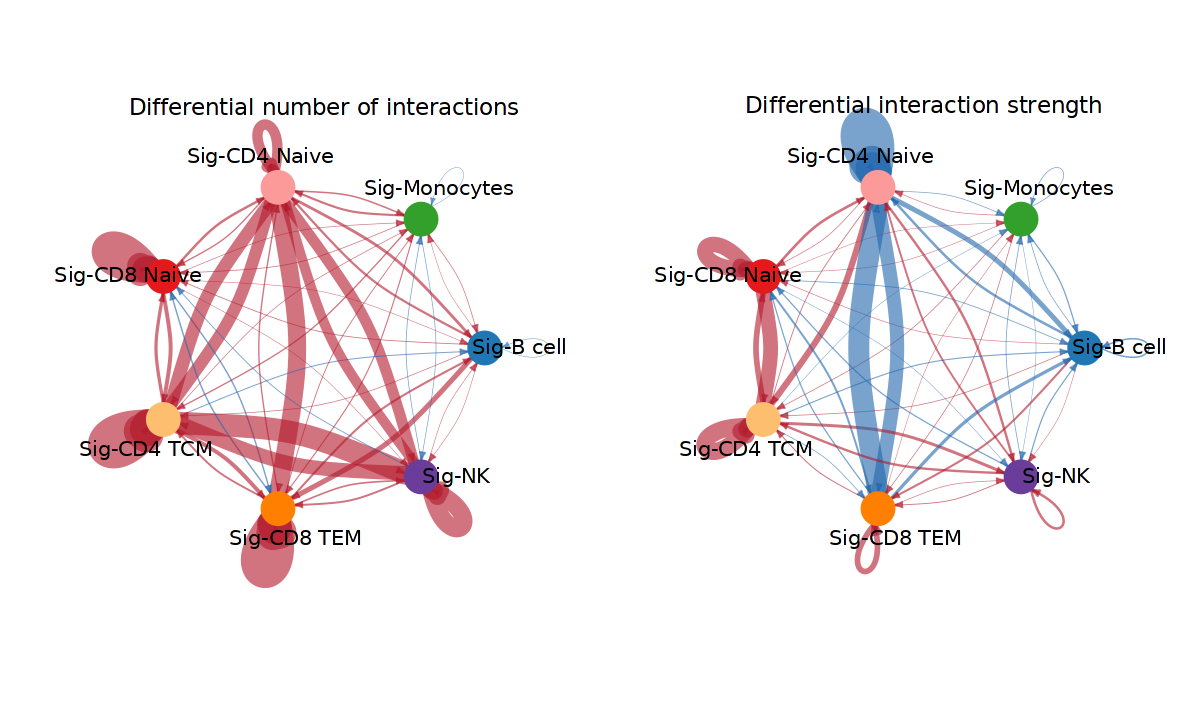

In [100]:
options(repr.plot.width=10, repr.plot.height=6)
par(mfrow = c(1,2), xpd=TRUE)
g1 <- netVisual_diffInteraction(cellchat, weight.scale = T, measure = 'count.merged', color.use = colors, edge.width.max=20)
g2 <- netVisual_diffInteraction(cellchat, weight.scale = T, measure = "weight.merged", color.use = colors, edge.width.max = 20)

We can also directly show the number of interactions or interaction strength of two groups. To better control the edge weights across different networks, CellChat computes the maximum number of interactions (interaction weights) across datasets.

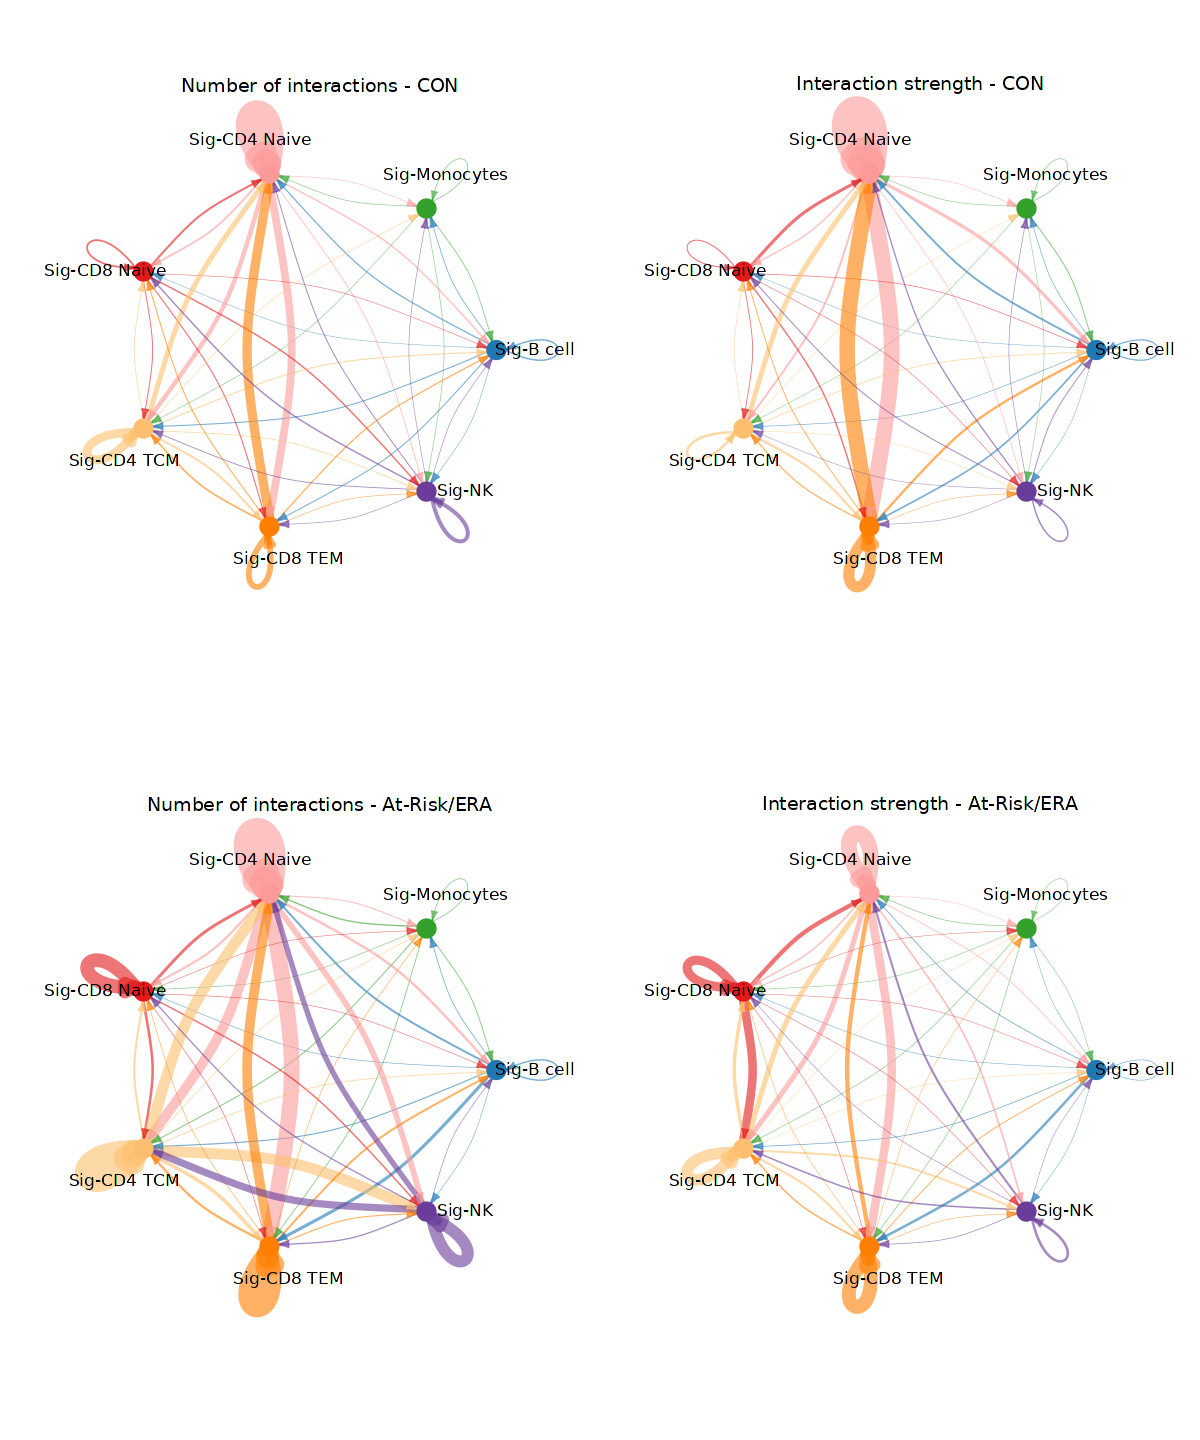

In [103]:
options(repr.plot.width=10, repr.plot.height=12)
weight.max <- getMaxWeight(object.list3, attribute = c("count.merged","weight.merged"))
par(mfrow = c(2,2), xpd=TRUE)
for (i in 1:length(object.list3)) {
  netVisual_circle(object.list3[[i]]@net$count.merged, weight.scale = T, label.edge= F, edge.weight.max = weight.max[1],  color.use = colors, edge.width.max = 20, title.name = paste0("Number of interactions - ", names(object.list3)[i]))
  netVisual_circle(object.list3[[i]]@net$weight.merged, weight.scale = T, label.edge= F, edge.weight.max = weight.max[2], color.use = colors, edge.width.max = 20, title.name = paste0("Interaction strength - ", names(object.list3)[i]))
}

# representative individual network

We selected participant 53 from control group and participant 9 from At-Risk/ERA group because they have the most diverse cell type distribution in signature clusters

In [104]:
# get sample name
patient.id <- c('CU1004','BR2036')
sample <- unlist(lapply(patient.id, function(x) {meta |> filter(subject.subjectGuid==x) |> pull(sample.sampleKitGuid) |> unique()}))
sample

[1] "KT00077" "KT00393"

In [109]:
# select cellchat objects
object.list3 <- object.list2[sample]
object.list3

$KT00077
An object of class CellChat created from a single dataset 
 33538 genes.
 7584 cells. 
CellChat analysis of single cell RNA-seq data! 

$KT00393
An object of class CellChat created from a single dataset 
 33538 genes.
 15952 cells. 
CellChat analysis of single cell RNA-seq data! 


In [118]:
# set color palatte
group.levels = c('B cell','Monocytes',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","NK") # exclude Treg and MAIT
group.levels2 = do.call(c,lapply(group.levels, function(x) c(paste0('Sig-',x), paste0('noSig-',x))))
colors = rep(RColorBrewer::brewer.pal('Paired',n=12)[c(2,4:8,10)],each = 2)
names(colors) = group.levels2

We use hierarchy plot to show the representative cellular networks. Color represents the cell type and edge thickness represents the interation strength. Solid and open circles represent source and target respectively. Circle size is proportional to the number of clusters.

Both edge thickness and circle size were normalized and comparable across different networks.

At-Risk patient showed much denser and stronger interactions than control sample.

       idents        weight weight.merged 
 2.962000e+03  7.507095e-03  1.639523e-02 


`summarise()` has grouped output by 'kmeans2'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'kmeans2'. You can override using the
`.groups` argument.


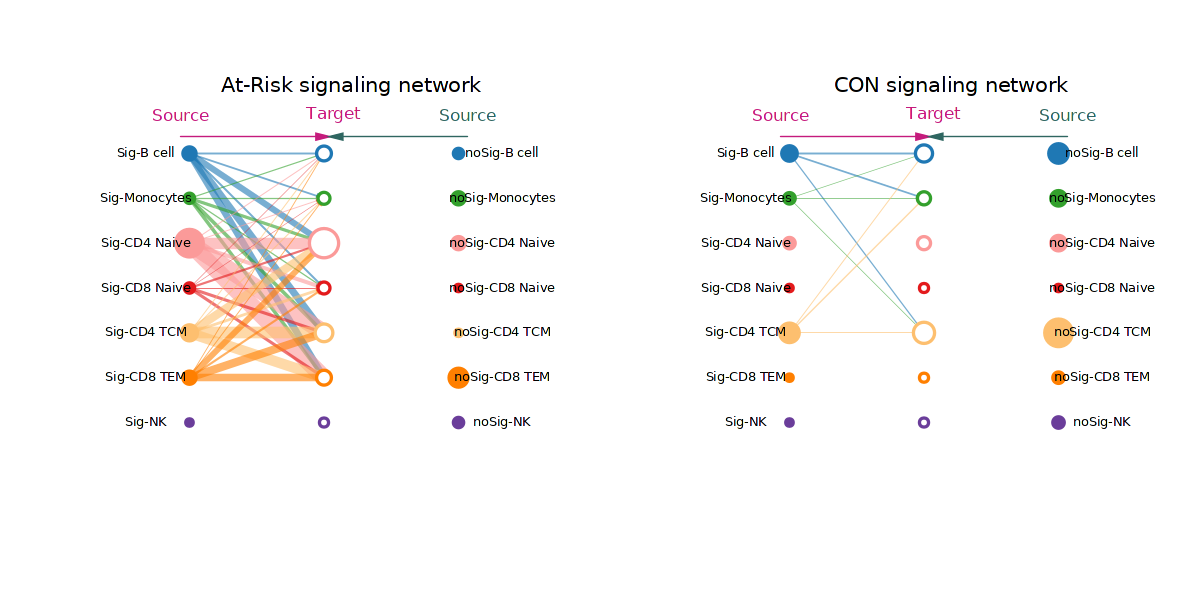

In [147]:
# only between signature groups with node size represents number of clusters
options(repr.plot.width=10, repr.plot.height=5)
weight.max <- getMaxWeight(object.list3, slot.name = c("idents", "net", "net"), attribute = c("idents","weight", "weight.merged"))
print(weight.max)
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list3)) {
    t = seq(1,13,2)
    tmp = meta |> filter(sample.sampleKitGuid==names(object.list3)[[i]]) |> mutate(kmeans2=ifelse(kmeans=='G2', 'Sig','noSig')) |> group_by(kmeans2, preClust2) |> summarise(n=n()) |> filter(preClust2 %in% group.levels) |> mutate(nodeName=paste0(kmeans2,'-',preClust2))
    node_names = rownames(object.list3[[1]]@net$weight.merged)
    node_weight = tmp$n[match(node_names, tmp$nodeName)]
    node_weight[is.na(node_weight)] <- 0
    netVisual_hierarchy1(object.list3[[i]]@net$weight.merged, vertex.receiver = t, sources.use = t, weight.scale = T, vertex.weight = node_weight, label.edge= F, edge.weight.max = weight.max[3], edge.width.max = 10, color.use = colors, title.name = ifelse(i==1,'At-Risk','CON'))
}


# identify altered signaling pathways

We can dive deeper to identify specific signaling pathways which contributed to the altered network. Cellchat can identify conserved and context-specific pathways by simply comparing the **information flow**, which is defined by the sum of communication probability among all pairs of cell groups.

We curated a gene list as candidate predictors for classfication model. See details in vignette about classification model. We'll focus on the pathways related to these pathogenic genes.

## conserved and context-specific pathways

In [152]:
match_patterns = paste0(intersect(unique(unlist(strsplit(unique(prob2$net),'_'))),genes_of_interest),collapse = '|')
selected_net <- prob2 |> filter(grepl(match_patterns,net) & sample.group=='At-Risk/ERA') |> pull(net) |> unique()
probp <- prob2 |> na.omit() |> filter(net %in% selected_net) |> mutate(prob=-1/(log(prob))) |> group_by(sample.group, net) |> summarise(weight=sum(prob), .groups = 'drop') 

In [153]:
tmp <- probp |> tidyr::pivot_wider(names_from = 'sample.group', values_from = 'weight', values_fill = 0) |> tibble::column_to_rownames("net") 
tmp['relative'] <- tmp[,2]/rowSums(tmp)
ordered_nets <- tmp |> arrange(relative) |> rownames()

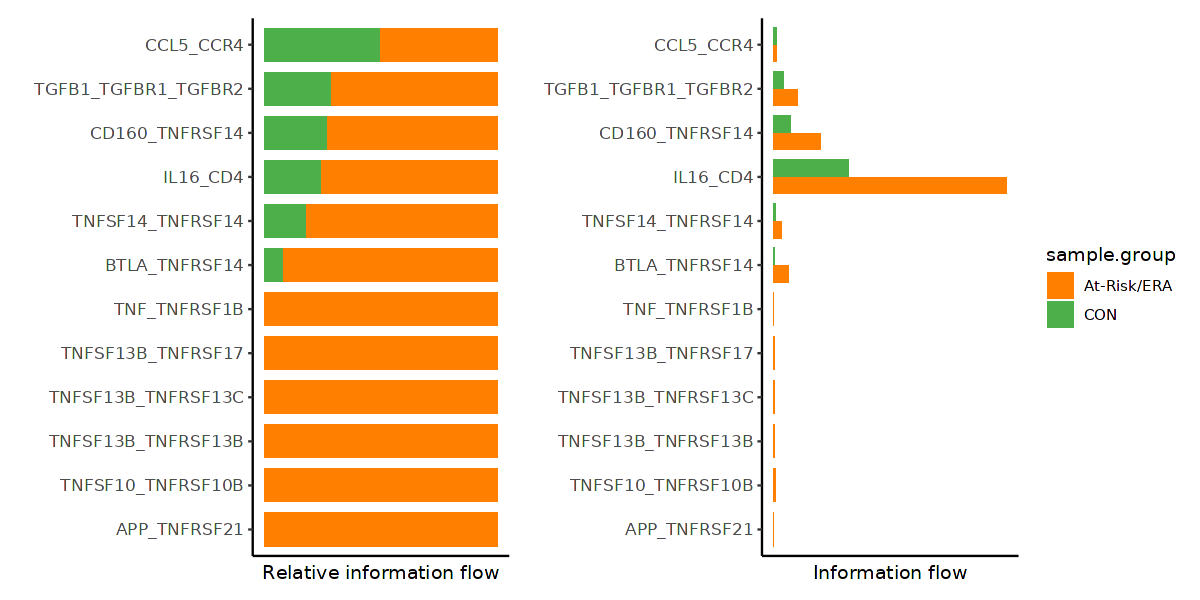

In [156]:
gg <- ggplot(probp, aes(x=factor(net, levels = ordered_nets), y=weight, fill=sample.group)) + geom_bar(stat="identity",width = 0.75, position = "fill") + scale_fill_manual(values = mycolors$subject.group2)+
      theme_classic() + theme(legend.position = "none",axis.text=element_text(size=10),axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.y = element_text(size=10)) +
      xlab("") + ylab('Relative information flow') + coord_flip()
gg2 <- ggplot(probp, aes(x=factor(net, levels = ordered_nets), y=weight, fill=sample.group)) + geom_bar(stat="identity",width = 0.75,position = position_dodge(0.8)) + scale_fill_manual(values = mycolors$subject.group2)+
      theme_classic() + theme(axis.text=element_text(size=10),axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.y = element_text(size=10)) +
      xlab("") + ylab('Information flow') + coord_flip()#+
gg+gg2

From the above plot, CCL5-CCR4 is context-conserved pathway. IL16-CD4, CD160-TNFRSF14, and TGFB1-TGFBR1-TGFBR2 pathways are significantly enriched in At-Risk/ERA group.

## major senders and receivers

CellChat used **out-degree** and **in-degree** respectively to identify dominant senders and receivers.
- out-degree: sum of communication probabilities of the outgoing signaling from a cell group
- in-degree: sum of the communication probabilities of the incoming signaling to a cell group.

In [240]:
# define function
get_data <- function(type,pathways.show,prob){
    # input:
    ## 1. type: signaling type. "incoming" or "outgoing"
    ## 2. pathways.show: pathways of interest, e.g. "TGFB". Choose from `prob$net`. "all" means considering all involved pathways
    ## 3. prob: ligand-receptor list prepared in section 4.2
    if (type=='incoming'){
        col = 'preClust.y'
    }else if (type=='outgoing'){
        col = 'preClust.x'
    }
    if (pathways.show!='all'){
        prob <- prob |> filter(grepl(pathways.show,net))
    }
    probp <- prob |> filter(preClust.x %in% selected_cell_states & preClust.y %in% selected_cell_states) |> 
        mutate(celltype=ifelse(!!as.name(col) %in% c('B naive','B memory'), 'B cell', ifelse(!!as.name(col)%in%c('CD14 Mono','CD16 Mono'), 'Monocytes', !!as.name(col)))) |>
        group_by(celltype, sample) |> summarise(sump=sum(prob)) |> tidyr::pivot_wider(names_from = sample, values_from = sump, values_fill = 0) |> tibble::column_to_rownames("celltype")
    probp <- -1/(log(probp)) # transform data following cellchat tradition
    probp
}

get_heatmap <- function(type, data, meta, breaksList, size=10){

    # reorganize it by disease state
    meta_p <- meta |> distinct(subject.subjectGuid, sample.sampleKitGuid, subject.group2) |> arrange(factor(subject.group2, levels = c('CON','At-Risk/ERA')))
    ss <- meta_p |> pull(sample.sampleKitGuid)
    data <- data[,intersect(ss, names(data))]

    # sort by pair frequency
    meta_p <- meta_p |> tibble::column_to_rownames('sample.sampleKitGuid')

    # only non-CON groups
    colors = list(subject.group3 = c('#E41A1C','#4DAF4A','#FFFF33'), subject.group2 = c('#4DAF4A','#FF7F00'))
    names(colors$subject.group3) = c("ERA","CON","At-Risk")
    names(colors$subject.group2) = c("CON","At-Risk/ERA")
    num <- meta_p[colnames(data),] |> filter(subject.group2=='CON') |> pull(subject.subjectGuid) |> length()
    palcolor <- ifelse(type=='incoming','Blues','Reds')
    p1 <- pheatmap::pheatmap(data, 
                             cellheight = size, fontsize = size, cellwidth = size, treeheight_row=size, treeheight_col=size, 
                             cluster_cols = F, cluster_rows = F, 
                             color = colorRampPalette((RColorBrewer::brewer.pal(n = 9, name = palcolor)))(length(breaksList)),
                             breaks = breaksList,
                             gaps_col=num,
                             annotation_legend = FALSE, 
                             annotation_col=meta_p, annotation_colors=colors
                            )      
    p1
}

In [205]:
# define cell states
selected_cell_states <- c('B naive','B memory','CD14 Mono','CD16 Mono',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","NK")

### in specific pathway

We want to test if a specific pathway is significantly changed between two groups

In [161]:
# statistics test for a specific pathway
pathways.show <- 'TGFB'
tmp <- prob2 |> filter(grepl(pathways.show,net) & preClust.x %in% selected_cell_states & preClust.y %in% selected_cell_states) 
l1 <- tmp |> filter(sample.group=='At-Risk/ERA') |> pull(prob)
l2 <- tmp |> filter(sample.group=='CON') |> pull(prob)
wilcox.test(l1,l2)


	Wilcoxon rank sum test with continuity correction

data:  l1 and l2
W = 1202, p-value = 0.00473
alternative hypothesis: true location shift is not equal to 0


We then prepare data for the heatmap visual of major senders/receivers of pathway of interest

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


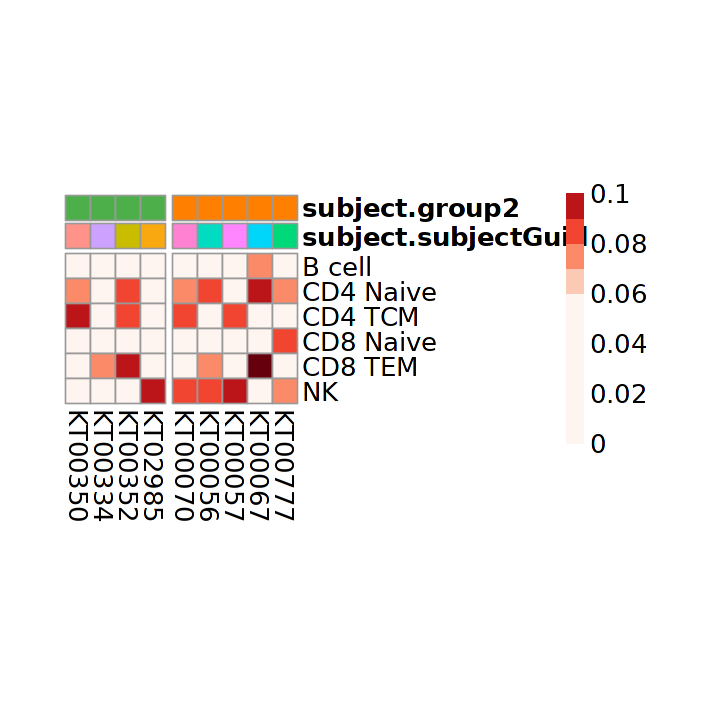

In [241]:
options(repr.plot.width = 6, repr.plot.height = 6) # adjust the window size
type <- 'outgoing'
data <- get_data(type,pathways.show,prob2)
p1 <- get_heatmap(type, data, meta, breaksList = c(seq(0,0.06,0.06),seq(0.07,0.1,0.01)), size=15)

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


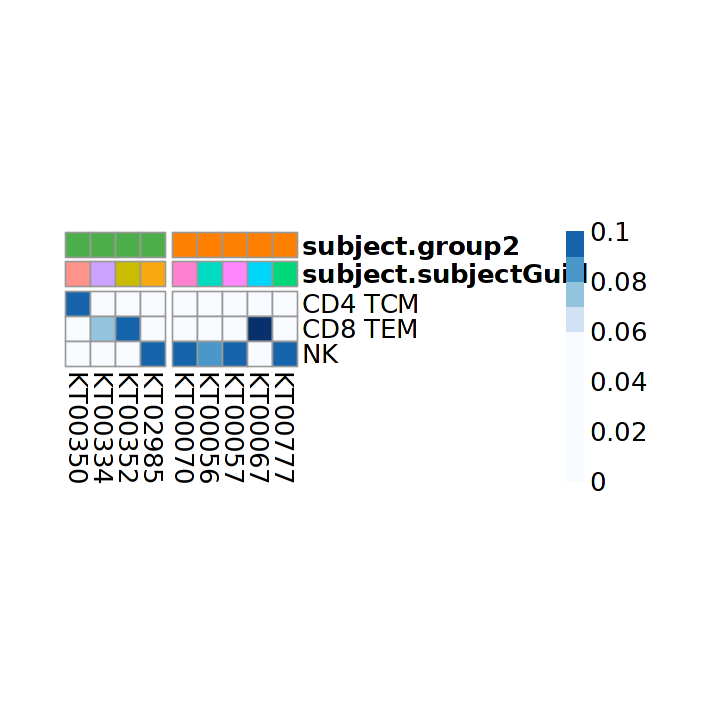

In [242]:
options(repr.plot.width = 6, repr.plot.height = 6) # adjust the window size
type <- 'incoming'
data <- get_data(type,pathways.show,prob2)
p1 <- get_heatmap(type, data, meta, breaksList = c(seq(0,0.06,0.06),seq(0.07,0.1,0.01)), size=15)

### in all pathways

In [243]:
pathways.show <- 'all'

In [208]:
# statistics test for a specific pathway
tmp <- prob2 |> filter(preClust.x %in% selected_cell_states & preClust.y %in% selected_cell_states) 
l1 <- tmp |> filter(sample.group=='At-Risk/ERA') |> pull(prob)
l2 <- tmp |> filter(sample.group=='CON') |> pull(prob)
wilcox.test(l1,l2)


	Wilcoxon rank sum test with continuity correction

data:  l1 and l2
W = 146511086, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


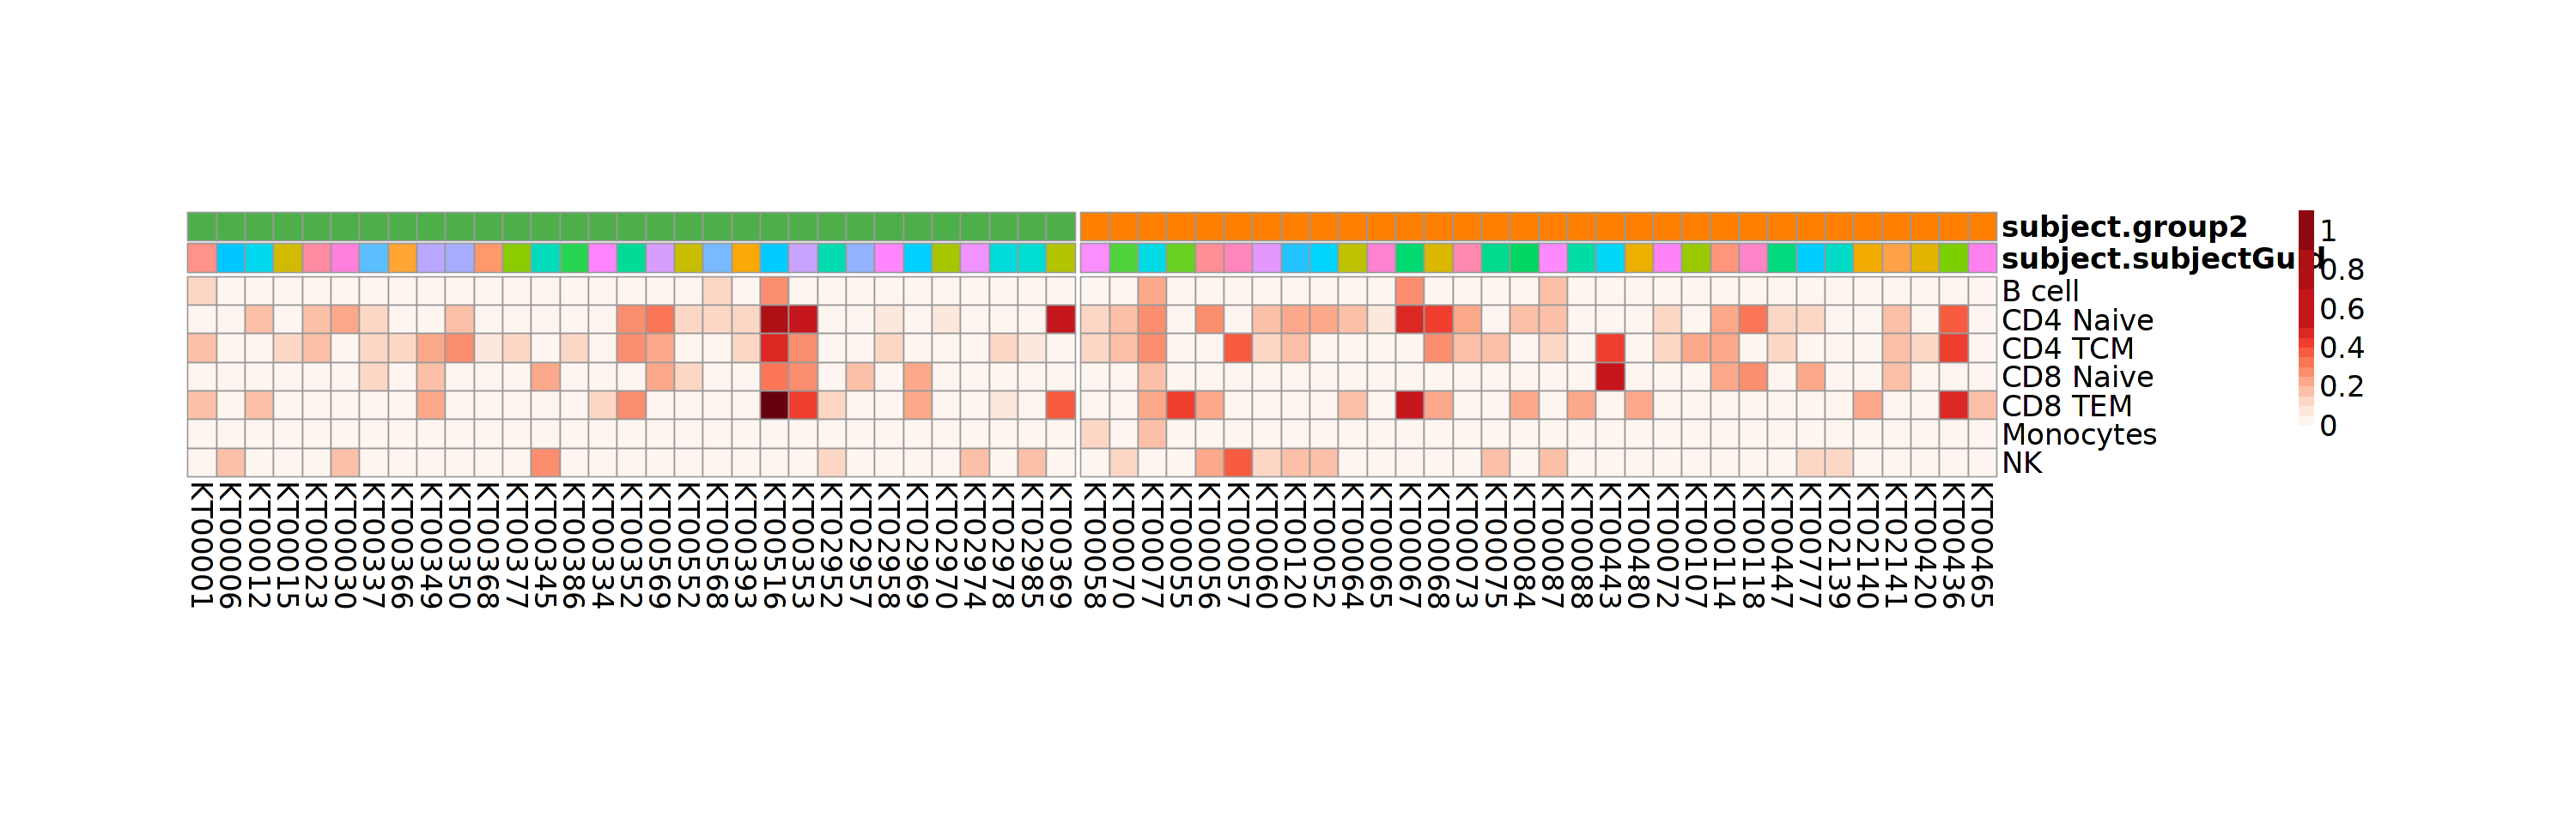

In [244]:
options(repr.plot.width = 25, repr.plot.height = 8) # adjust the window size
type <- 'outgoing'
data <- get_data(type,pathways.show,prob2)
p1 <- get_heatmap(type, data, meta, breaksList = c(seq(0,0.5,0.05),seq(0.7,1.2,0.2)), size=20)

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


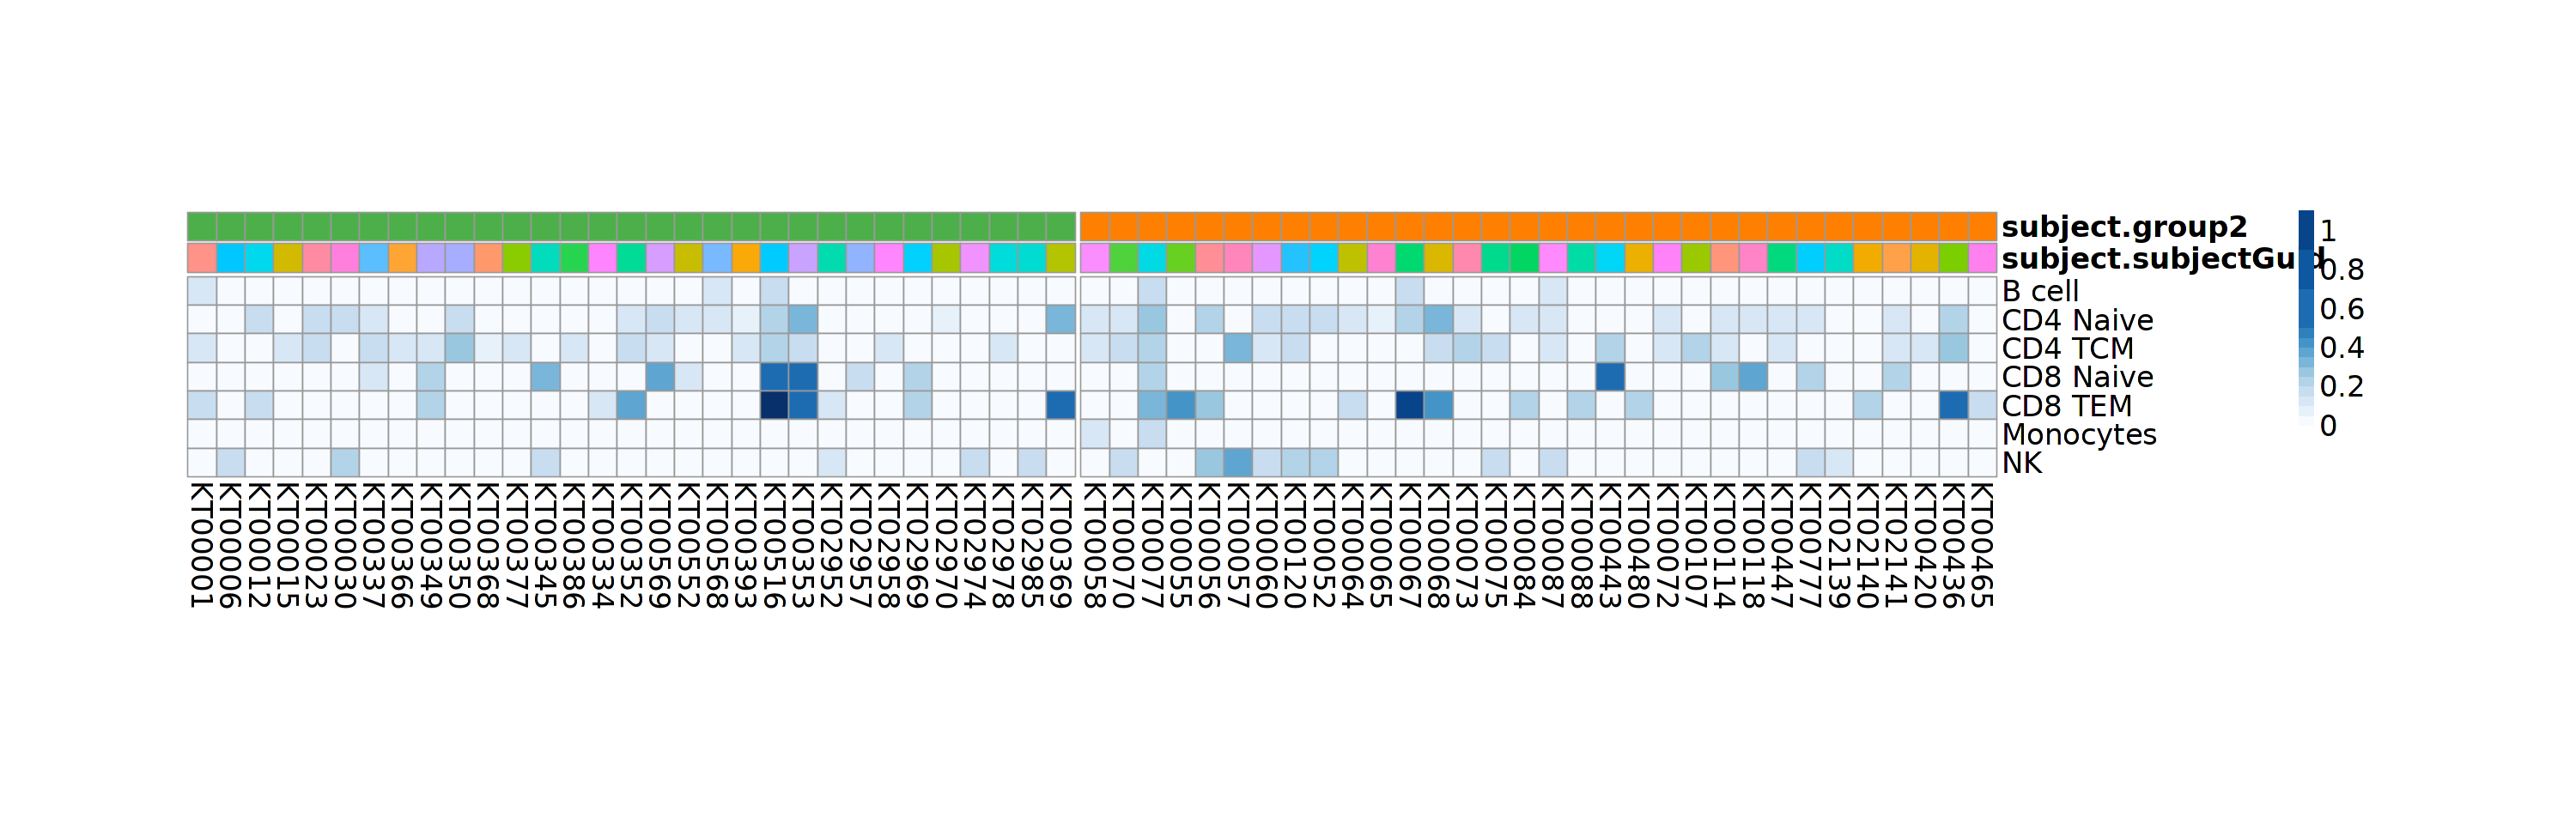

In [245]:
options(repr.plot.width = 25, repr.plot.height = 8) # adjust the window size
type <- 'incoming'
data <- get_data(type,pathways.show,prob2)
p1 <- get_heatmap(type, data, meta, breaksList = c(seq(0,0.5,0.05),seq(0.7,1.2,0.2)), size=20)

## hierarchy network plot for specific signaling pathway

We want to see the visualiztion of cellular communication network in a specific signaling pathway using hierarchy plot. 

Make sure you run [section 4.2.3](#circle-network-plot) to get `object.list2`

We're interested in TGF-$\beta$ pathway. Checking the heatmap in [section 6.2.1](#in-specific-pathway), we selected KT00067 from At-Risk/ERA group becaues this sample has B cell cluster. To make a fair comparison, we selected KT00352 from control group because it has similar cell type distribution.

In [251]:
# select cellchat objects
sample <- c('KT00067','KT00352')
pathways.show <- 'TGFb'
object.list3 <- object.list2[sample]
names(object.list3) <- c('ARK','CON')
print(object.list3)
lr <- rownames(searchPair(signaling = pathways.show, pairLR.use = object.list3[[1]]@LR$LRsig, key = "pathway_name", matching.exact = T, pair.only = T))

$ARK
An object of class CellChat created from a single dataset 
 33538 genes.
 9417 cells. 
CellChat analysis of single cell RNA-seq data! 

$CON
An object of class CellChat created from a single dataset 
 33538 genes.
 13905 cells. 
CellChat analysis of single cell RNA-seq data! 



       TGFb 
7.95744e-06 


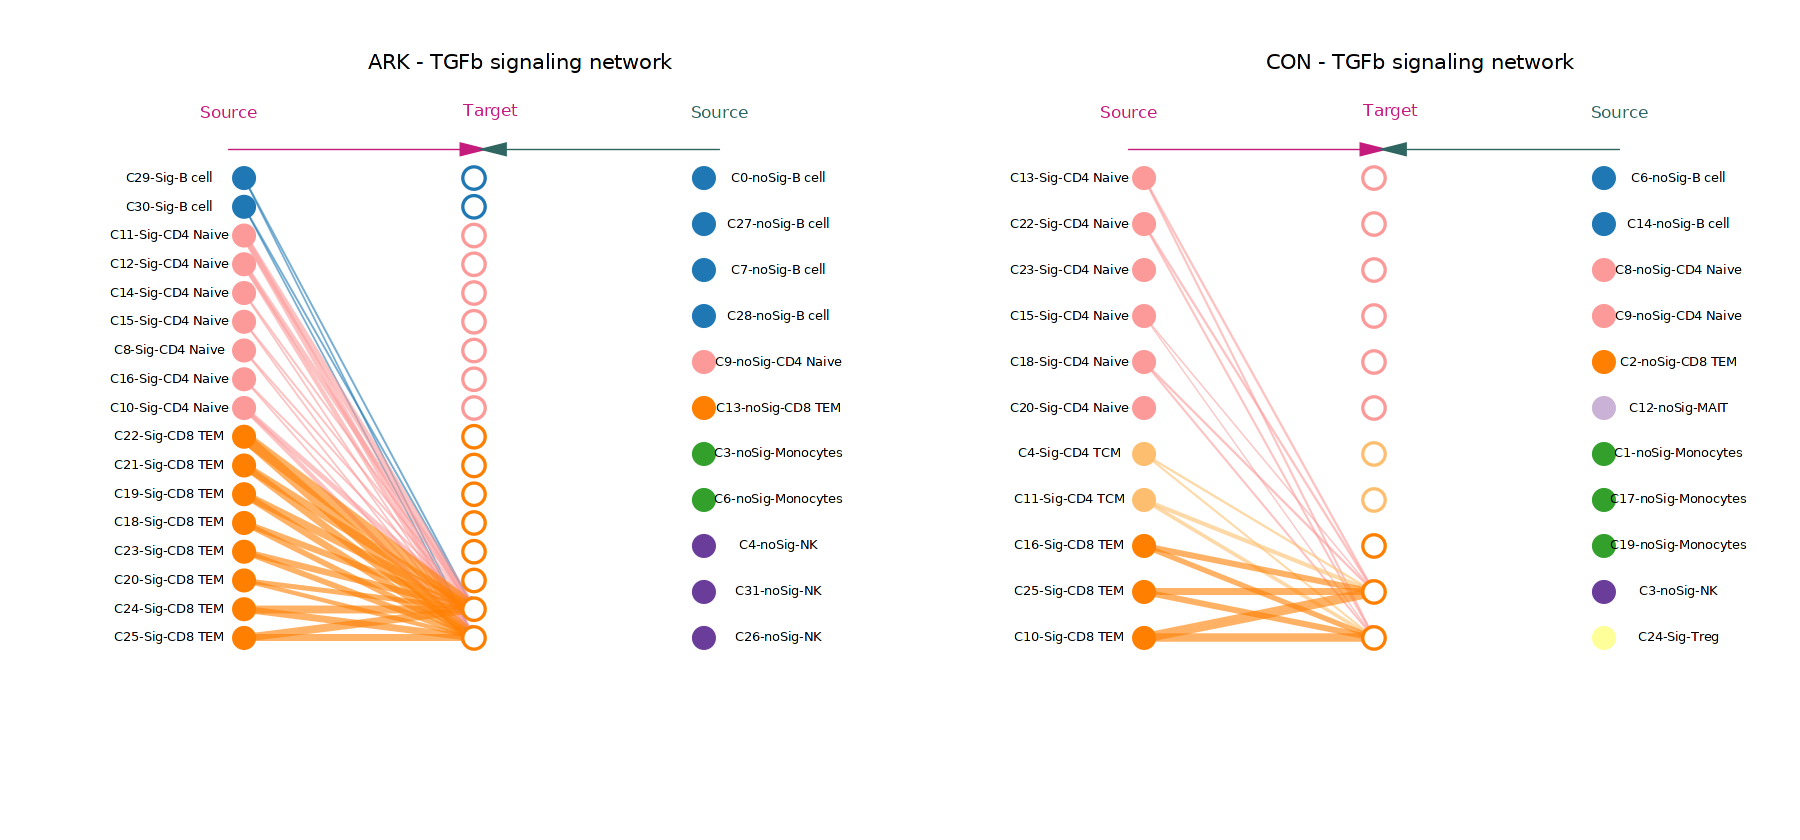

In [261]:
# get plot
weight.max <- getMaxWeight(object.list3, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
print(weight.max)

options(repr.plot.width=15, repr.plot.height=7)
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list3)) {
    # source = grep(paste0(group.levels, collapse = '|'),levels(object.list3[[i]]@idents))
    # t = grep('-Sig',levels(object.list3[[i]]@idents)[source])
    t = grep('-Sig',levels(object.list3[[i]]@idents))
    # print(object.list3[[i]]@net$prob[t,t,lr])
    t = setdiff(t, grep('Treg',levels(object.list3[[i]]@idents))) # exclude Treg cells
    colors_tmp = data.frame(colors=RColorBrewer::brewer.pal('Paired',n=12)[c(2,4:12,1)], group=c('B cell','Monocytes',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","Treg","pDC","HSPC")) 
    colors_tmp = data.frame(name=levels(object.list3[[i]]@idents)) |> mutate(group=sub('.*-','',name)) |> left_join(colors_tmp, by='group') |> pull(colors,name)
    netVisual_hierarchy1(
                         # object.list3[[i]]@netP$prob[,,pathways.show], 
                         object.list3[[i]]@net$prob[,,lr],  # somehow slightly different result using 'net' and 'netP'
                         vertex.receiver = t, sources.use = t, color.use = colors_tmp, weight.scale = T, label.edge= F, 
                         edge.weight.max = weight.max[1], edge.width.max = 10, 
                         vertex.weight.max = 30, 
                         title.name = paste0(names(object.list3)[[i]],' - ', pathways.show))
}


Another example pathway is IL16

In [265]:
# select cellchat objects
sample <- c('KT00077','KT00516')
pathways.show <- 'IL16'
object.list3 <- object.list2[sample]
names(object.list3) <- c('ARK','CON')
print(object.list3)
lr <- rownames(searchPair(signaling = pathways.show, pairLR.use = object.list3[[1]]@LR$LRsig, key = "pathway_name", matching.exact = T, pair.only = T))

$ARK
An object of class CellChat created from a single dataset 
 33538 genes.
 7584 cells. 
CellChat analysis of single cell RNA-seq data! 

$CON
An object of class CellChat created from a single dataset 
 33538 genes.
 4963 cells. 
CellChat analysis of single cell RNA-seq data! 



        IL16 
2.295631e-05 


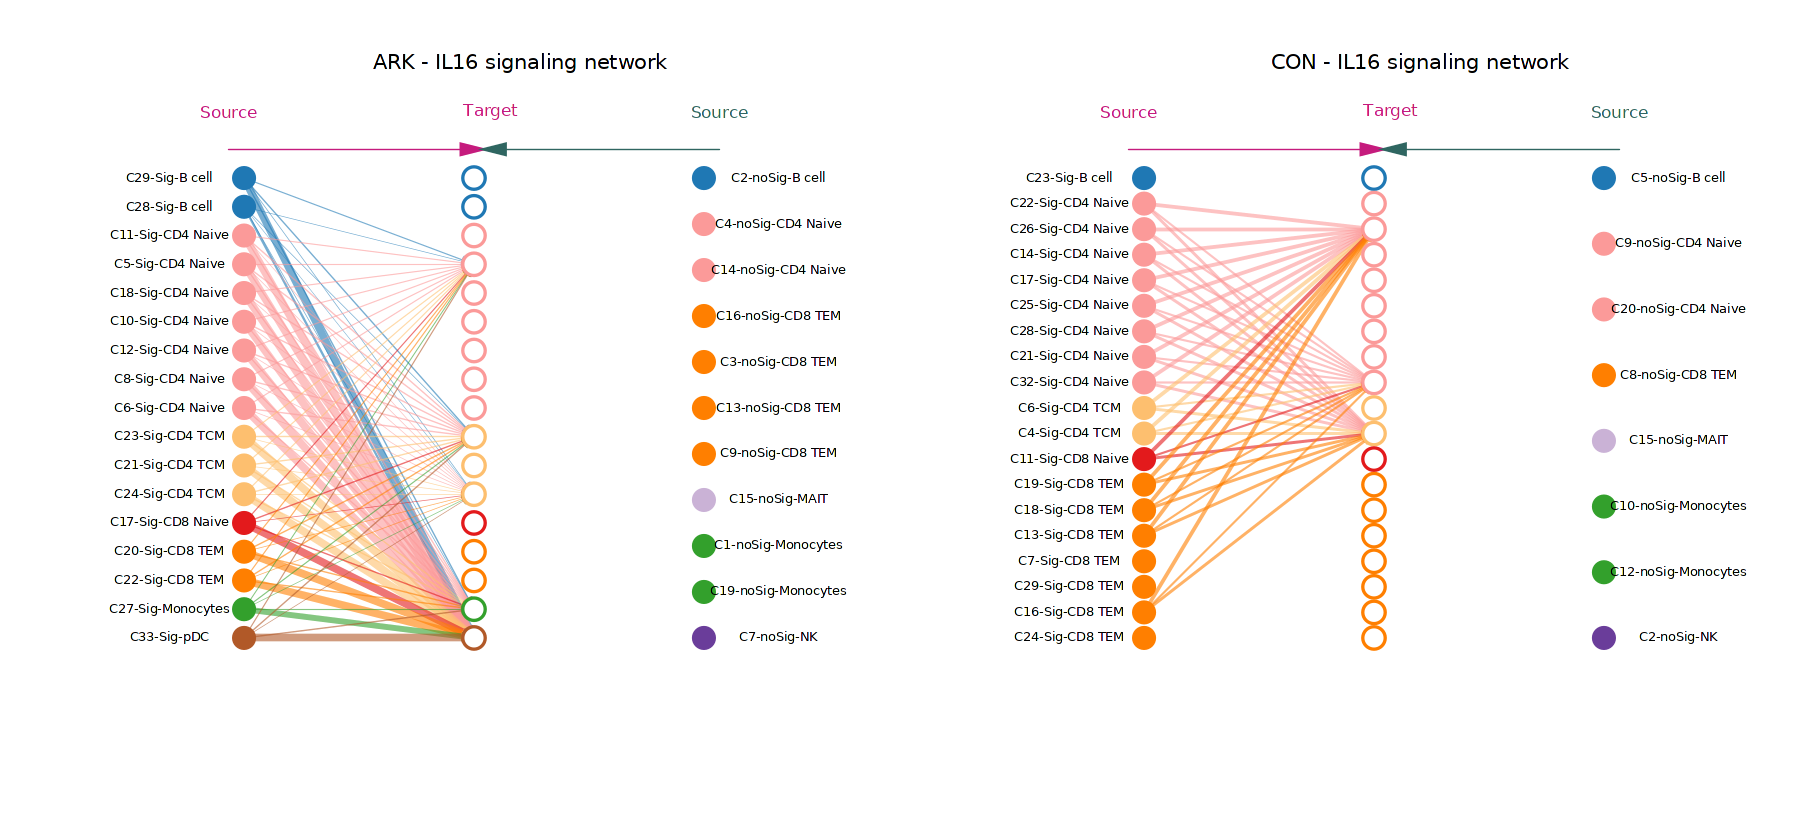

In [266]:
# get plot
weight.max <- getMaxWeight(object.list3, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
print(weight.max)

options(repr.plot.width=15, repr.plot.height=7)
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list3)) {
    # source = grep(paste0(group.levels, collapse = '|'),levels(object.list3[[i]]@idents))
    # t = grep('-Sig',levels(object.list3[[i]]@idents)[source])
    t = grep('-Sig',levels(object.list3[[i]]@idents))
    # print(object.list3[[i]]@net$prob[t,t,lr])
    t = setdiff(t, grep('Treg',levels(object.list3[[i]]@idents))) # exclude Treg cells
    colors_tmp = data.frame(colors=RColorBrewer::brewer.pal('Paired',n=12)[c(2,4:12,1)], group=c('B cell','Monocytes',"CD4 Naive","CD8 Naive","CD4 TCM","CD8 TEM","MAIT","NK","Treg","pDC","HSPC")) 
    colors_tmp = data.frame(name=levels(object.list3[[i]]@idents)) |> mutate(group=sub('.*-','',name)) |> left_join(colors_tmp, by='group') |> pull(colors,name)
    netVisual_hierarchy1(
                         # object.list3[[i]]@netP$prob[,,pathways.show], 
                         object.list3[[i]]@net$prob[,,lr],  # somehow slightly different result using 'net' and 'netP'
                         vertex.receiver = t, sources.use = t, color.use = colors_tmp, weight.scale = T, label.edge= F, 
                         edge.weight.max = weight.max[1], edge.width.max = 10, 
                         vertex.weight.max = 30, 
                         title.name = paste0(names(object.list3)[[i]],' - ', pathways.show))
}


# session info

In [248]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] purrr_1.0.2         CellChat_2.1.2      Biobase_2.58.0     
[4] BiocGenerics_0.44.0 igraph_2.0.3        ggplot2_3.4.4      
[7] dplyr_1.1.4        

loaded via a namespace (and not attached):
  [1] colorspace_2.1-0      ggsignif_0.6.4        rjson_0.2.21         
  [4] ellipsis_0.3.2        c